<a href="https://colab.research.google.com/github/jamesBaker361/colab/blob/master/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [1]:
!pip install torchvision tensorboardx jupyter matplotlib nump

  ERROR: Could not find a version that satisfies the requirement nump (from versions: none)
ERROR: No matching distribution found for nump


In [2]:
!pip install numpy


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [15]:
test_noise

tensor([[ 2.4182,  0.5768,  0.3508,  ..., -0.3789,  1.6057, -0.7924],
        [-1.5413,  0.0101,  0.5512,  ..., -0.2499,  2.0515,  0.6763],
        [ 1.5849,  0.4309, -1.9961,  ...,  1.2267,  1.2104, -0.6891],
        ...,
        [ 0.0990,  0.0199,  0.7726,  ..., -0.0998,  1.2460,  1.5572],
        [ 0.1964, -0.8693,  1.6145,  ...,  0.6222, -0.2311, -0.0577],
        [ 0.3502,  1.0842, -1.7581,  ...,  0.6351,  0.1807, -0.0492]])

In [16]:
!pip install tensorboardX
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:

num_batches = len(data_loader)
logger = Logger(model_name='VGAN', data_name='MNIST')

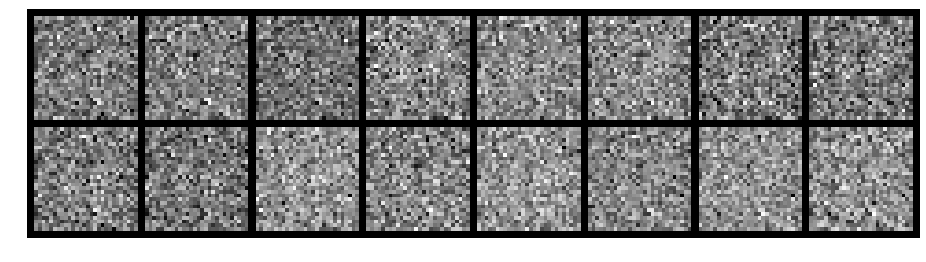

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.2117, Generator Loss: 0.6971
D(x): 0.5922, D(G(z)): 0.4970


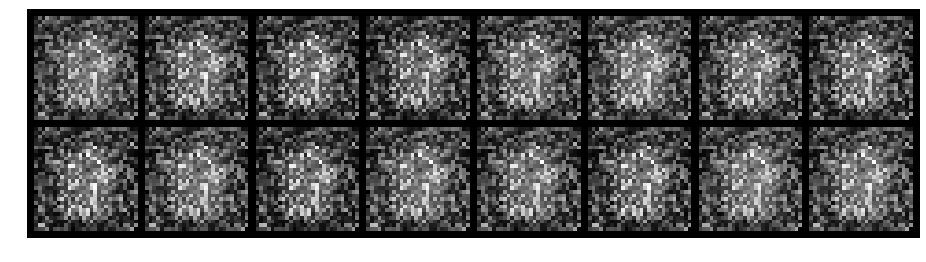

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.8770, Generator Loss: 0.6745
D(x): 0.7111, D(G(z)): 0.7449


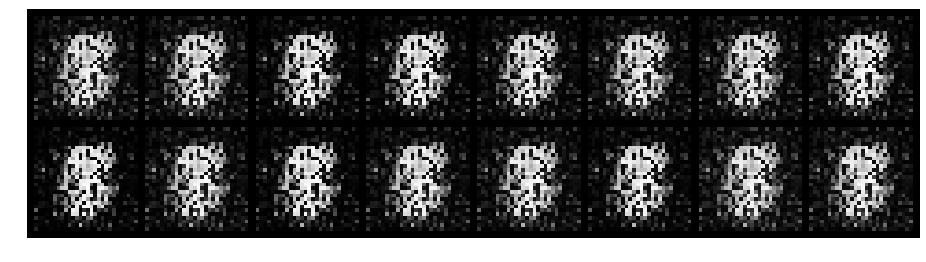

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.6377, Generator Loss: 3.1620
D(x): 0.7815, D(G(z)): 0.2621


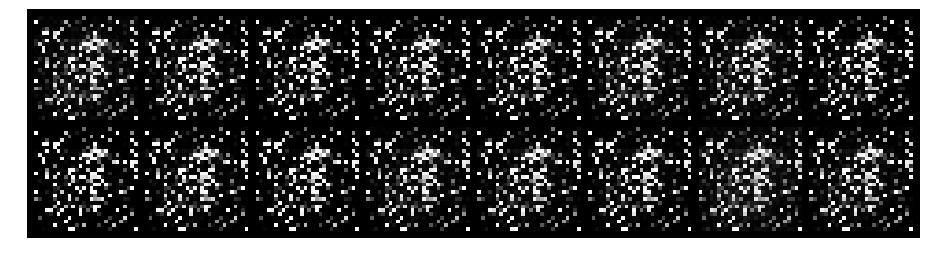

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.5464, Generator Loss: 4.4872
D(x): 0.8497, D(G(z)): 0.2289


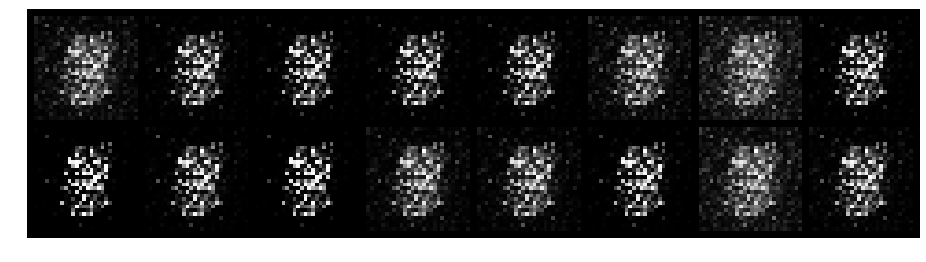

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 3.7576, Generator Loss: 0.1194
D(x): 0.4984, D(G(z)): 0.9395


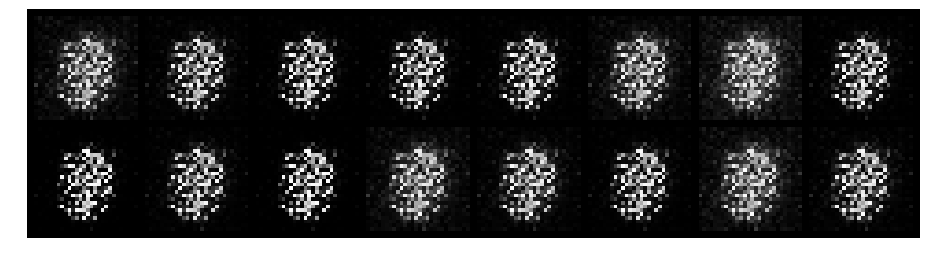

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.2074, Generator Loss: 5.0040
D(x): 0.9343, D(G(z)): 0.0954


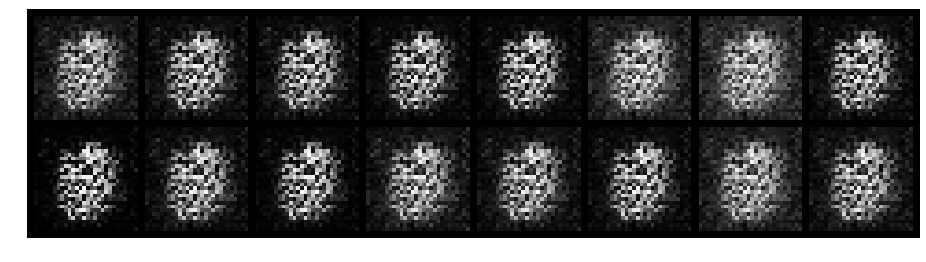

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 1.5486, Generator Loss: 0.7284
D(x): 0.5648, D(G(z)): 0.5707


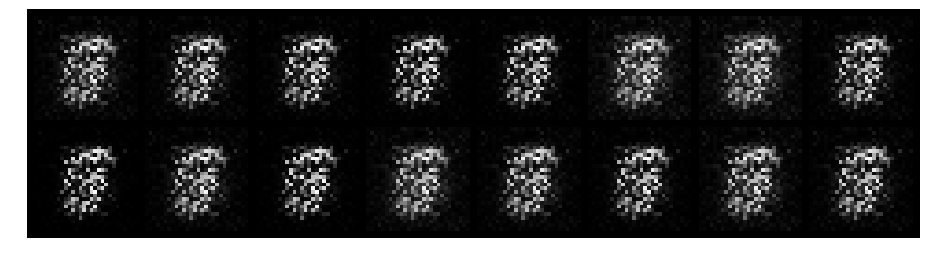

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 1.2023, Generator Loss: 1.0648
D(x): 0.5461, D(G(z)): 0.4202


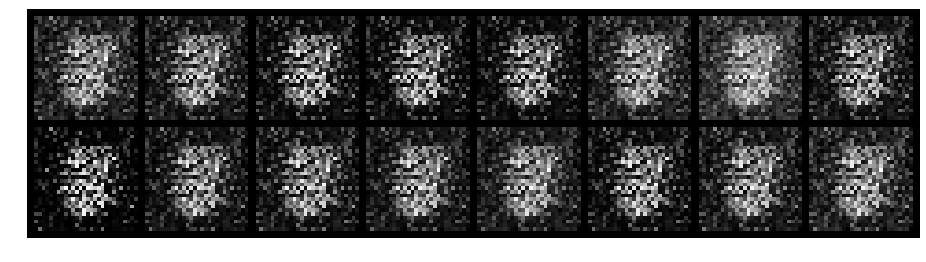

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 1.4184, Generator Loss: 1.7117
D(x): 0.5212, D(G(z)): 0.4136


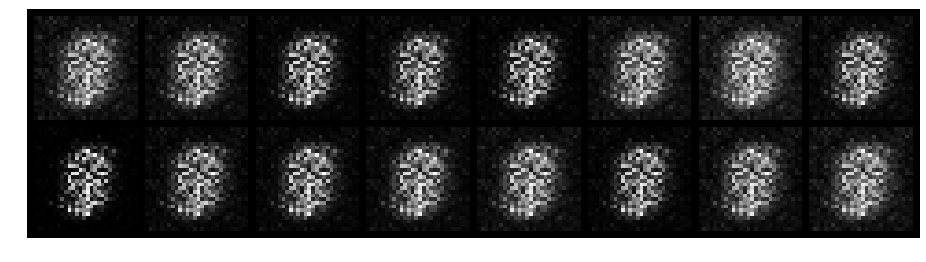

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.7576, Generator Loss: 2.3744
D(x): 0.7435, D(G(z)): 0.2883


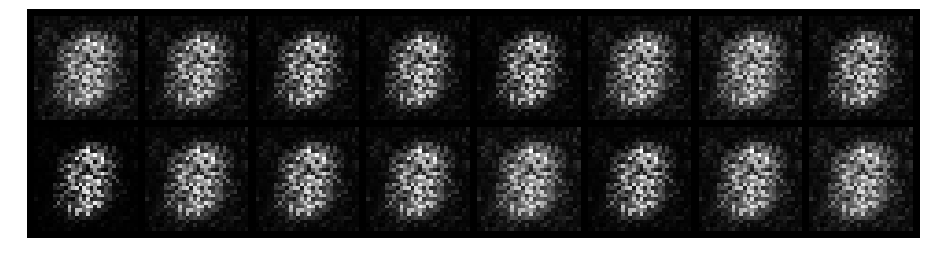

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.7214, Generator Loss: 2.0023
D(x): 0.7390, D(G(z)): 0.2593


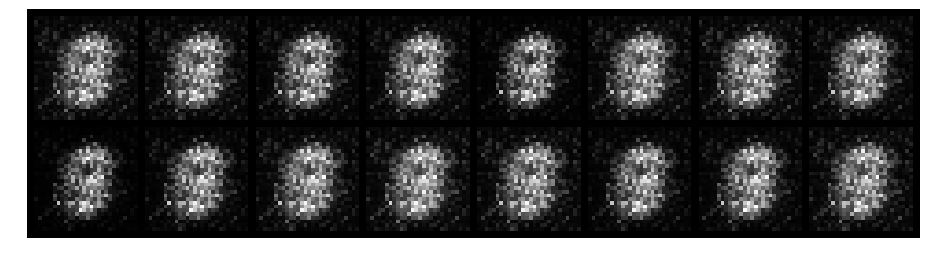

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 1.4792, Generator Loss: 0.9915
D(x): 0.5531, D(G(z)): 0.4827


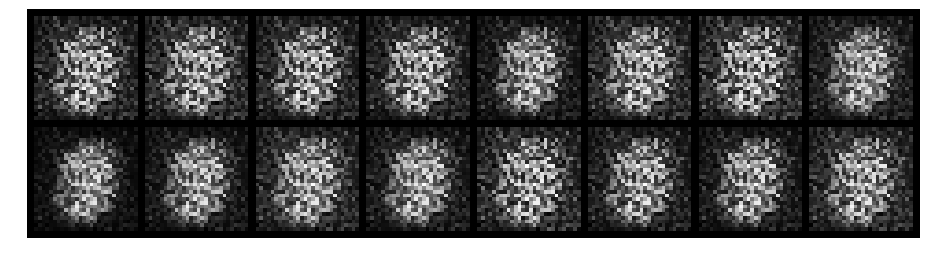

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.0635, Generator Loss: 2.2627
D(x): 0.8236, D(G(z)): 0.4357


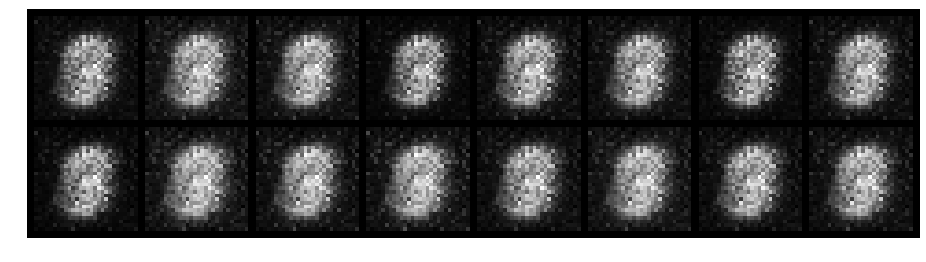

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.7962, Generator Loss: 1.5710
D(x): 0.6974, D(G(z)): 0.2681


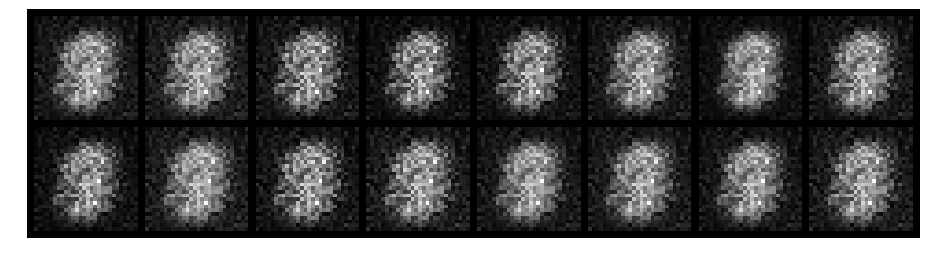

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.9044, Generator Loss: 3.4428
D(x): 0.6971, D(G(z)): 0.2233


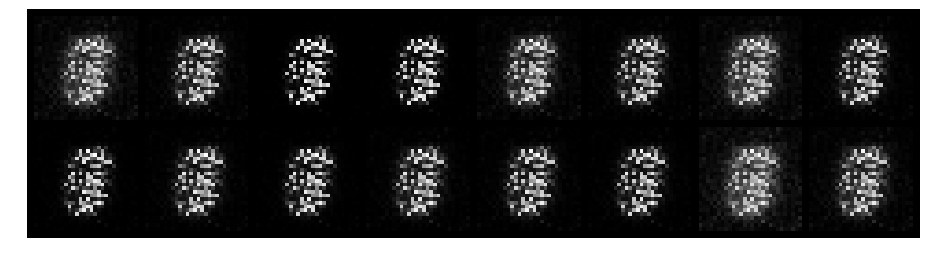

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.5663, Generator Loss: 4.3690
D(x): 0.7994, D(G(z)): 0.1904


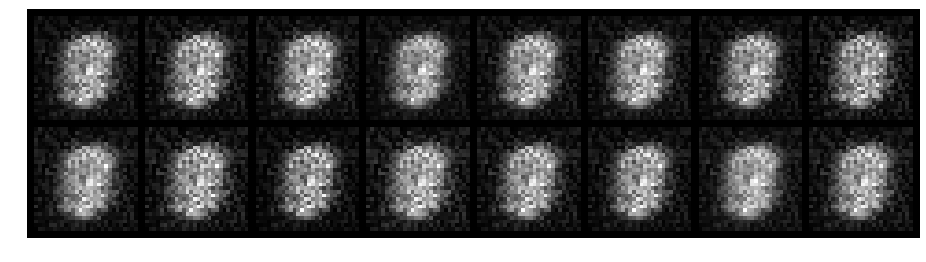

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 1.5850, Generator Loss: 0.5145
D(x): 0.5630, D(G(z)): 0.6288


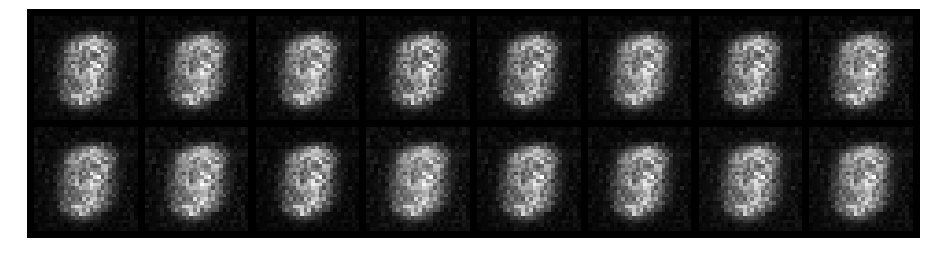

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 1.2813, Generator Loss: 0.8479
D(x): 0.5483, D(G(z)): 0.4461


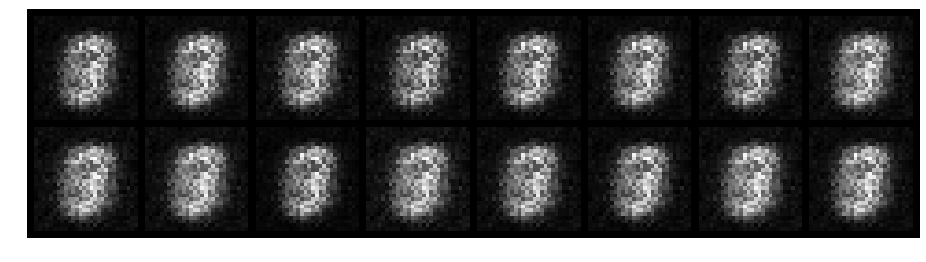

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.9312, Generator Loss: 1.2093
D(x): 0.6269, D(G(z)): 0.3427


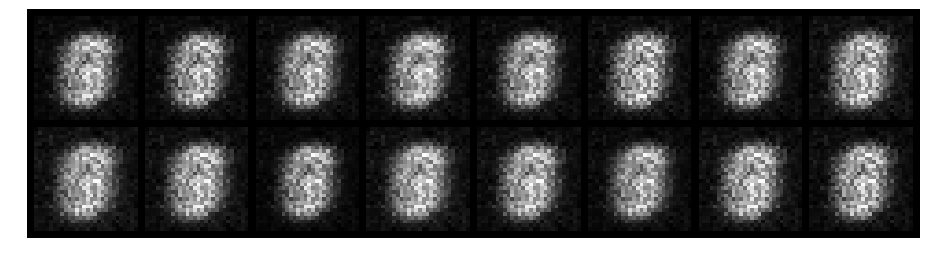

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.9385, Generator Loss: 1.0358
D(x): 0.6511, D(G(z)): 0.3735


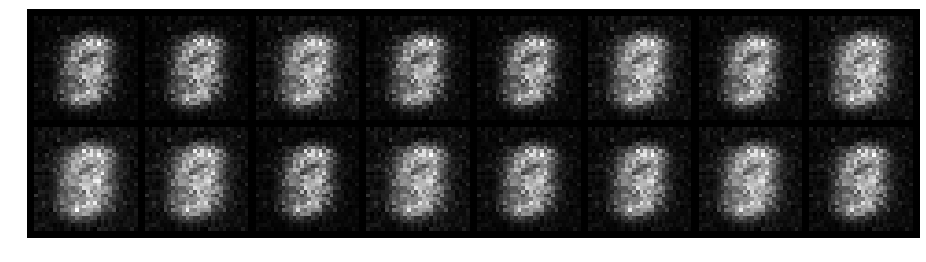

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.3578, Generator Loss: 2.2415
D(x): 0.8684, D(G(z)): 0.1454


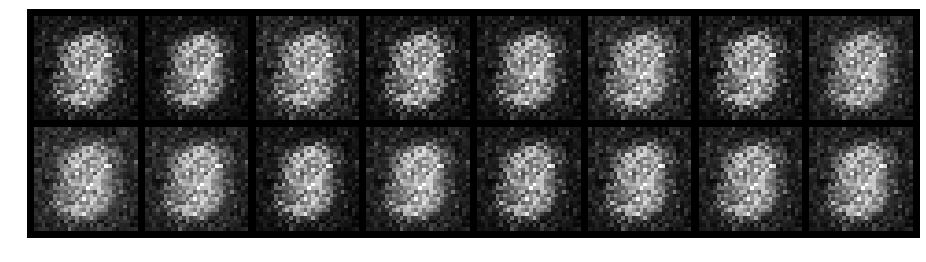

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.5954, Generator Loss: 2.8840
D(x): 0.7492, D(G(z)): 0.1898


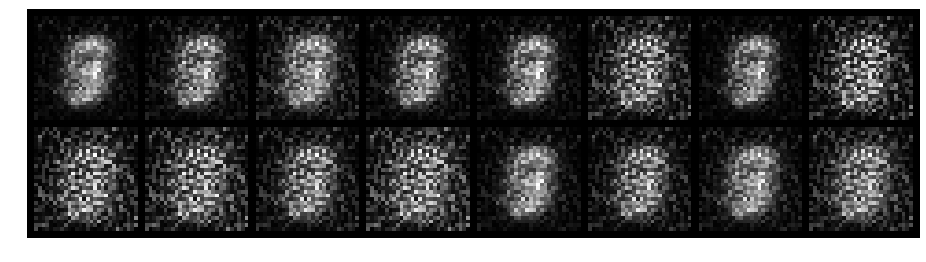

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.6383, Generator Loss: 3.1868
D(x): 0.8155, D(G(z)): 0.2664


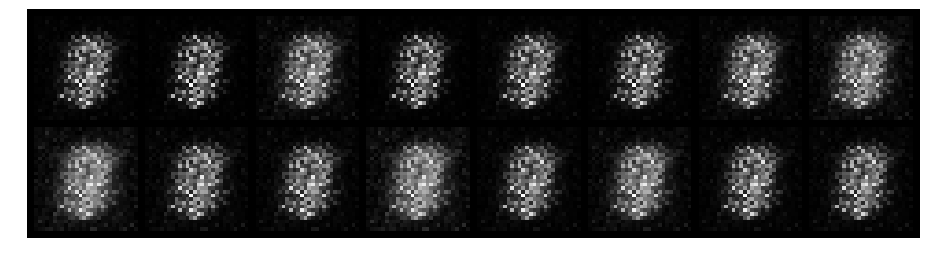

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.6220, Generator Loss: 2.6496
D(x): 0.8261, D(G(z)): 0.2276


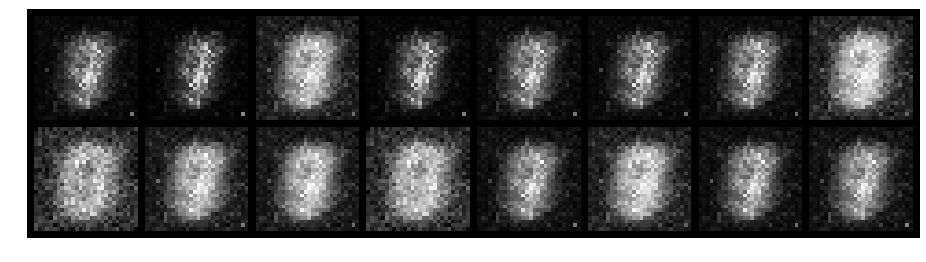

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.5179, Generator Loss: 2.4362
D(x): 0.8614, D(G(z)): 0.2067


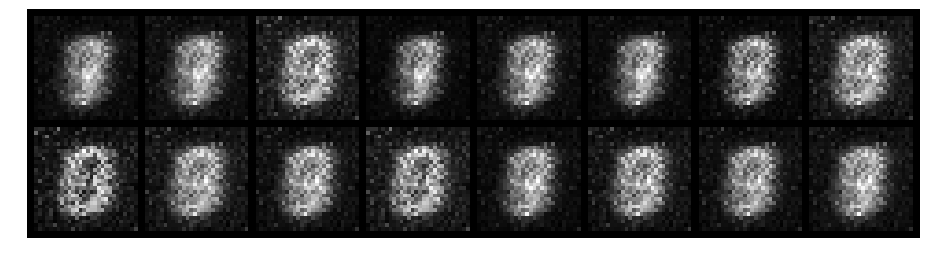

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 1.0600, Generator Loss: 2.0431
D(x): 0.7456, D(G(z)): 0.3627


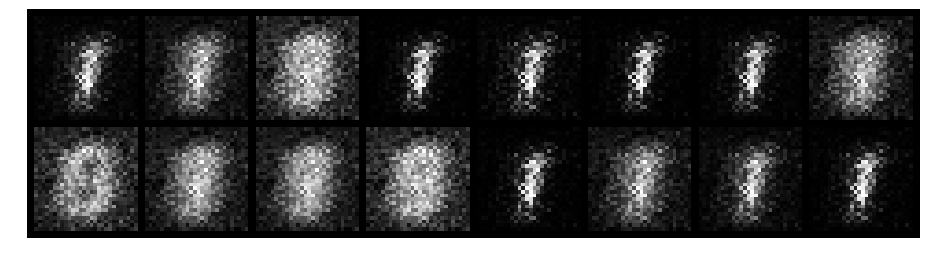

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.5352, Generator Loss: 2.6894
D(x): 0.7809, D(G(z)): 0.1406


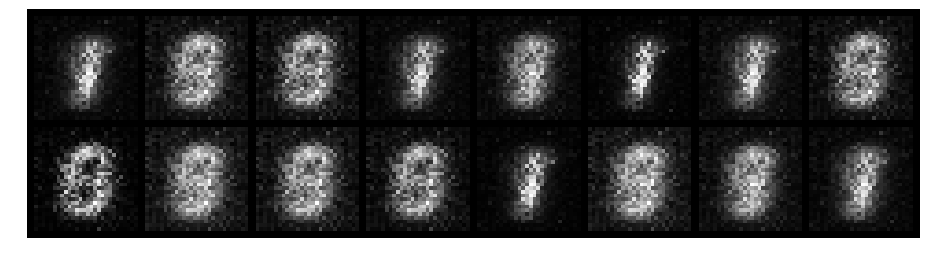

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.5416, Generator Loss: 1.8732
D(x): 0.8155, D(G(z)): 0.2222


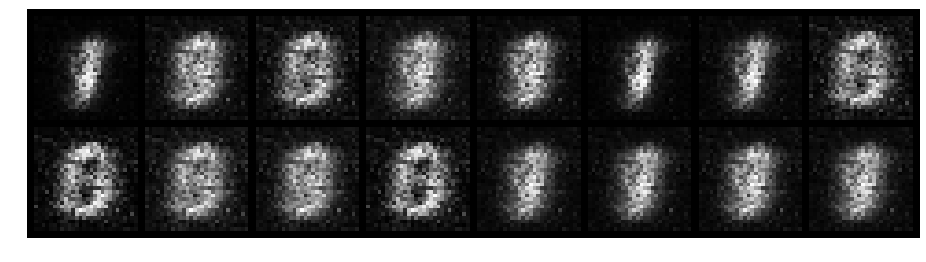

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.5467, Generator Loss: 3.2373
D(x): 0.8115, D(G(z)): 0.0888


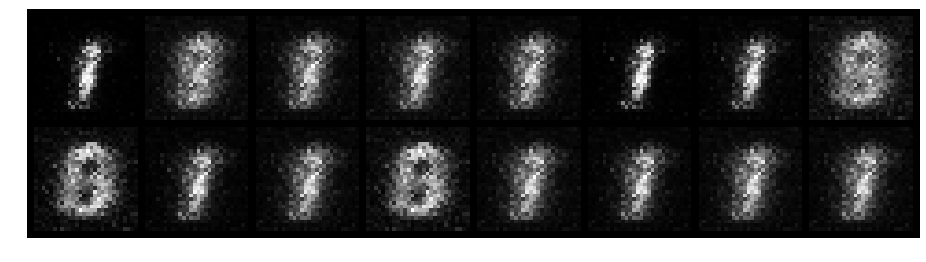

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.4918, Generator Loss: 2.4035
D(x): 0.8606, D(G(z)): 0.1737


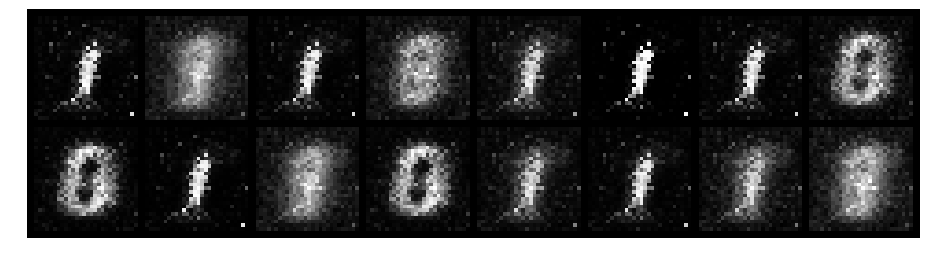

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.5433, Generator Loss: 3.1243
D(x): 0.8749, D(G(z)): 0.1662


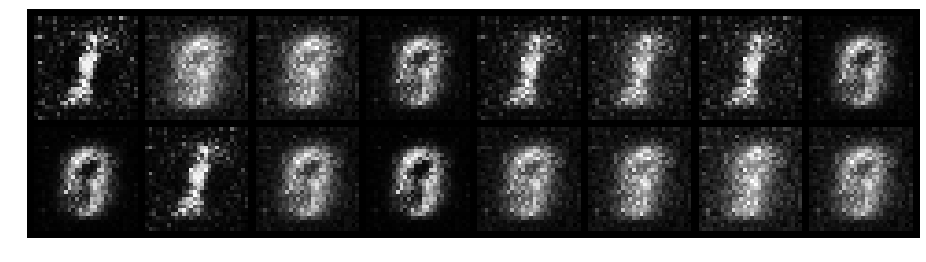

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.2345, Generator Loss: 5.1210
D(x): 0.9312, D(G(z)): 0.0828


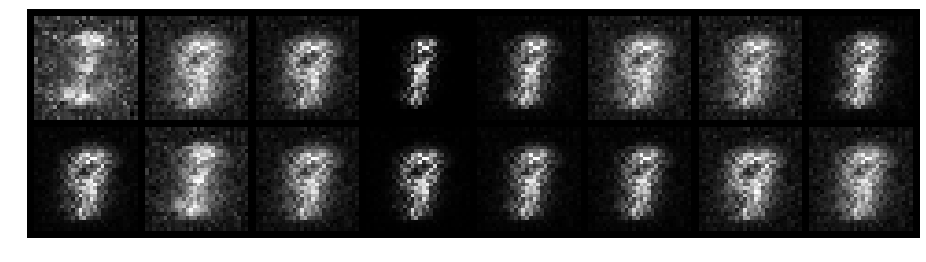

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.6677, Generator Loss: 3.6976
D(x): 0.8715, D(G(z)): 0.1555


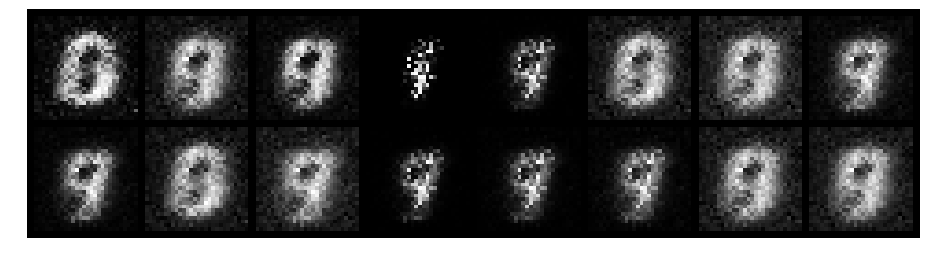

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.6310, Generator Loss: 2.0051
D(x): 0.8029, D(G(z)): 0.2217


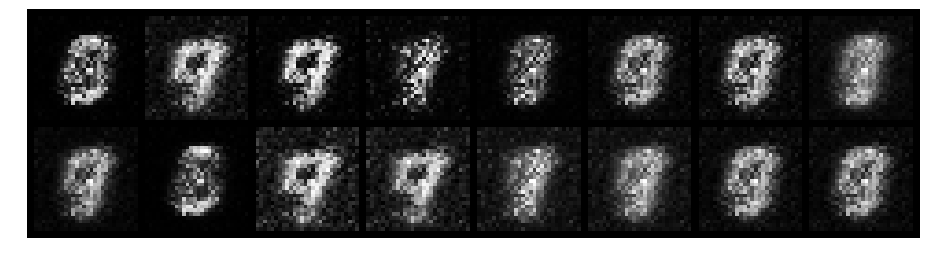

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.8024, Generator Loss: 2.4120
D(x): 0.8307, D(G(z)): 0.3005


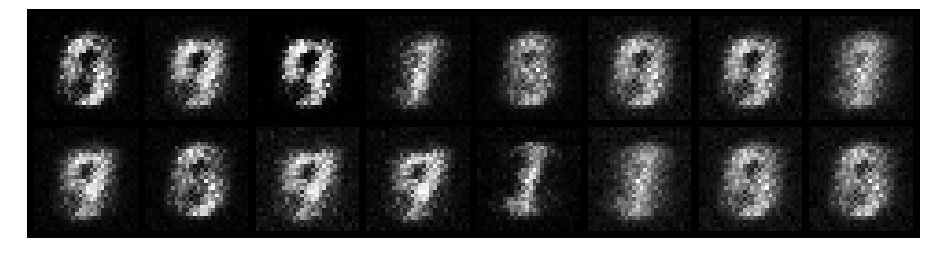

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.3795, Generator Loss: 4.2131
D(x): 0.8603, D(G(z)): 0.0947


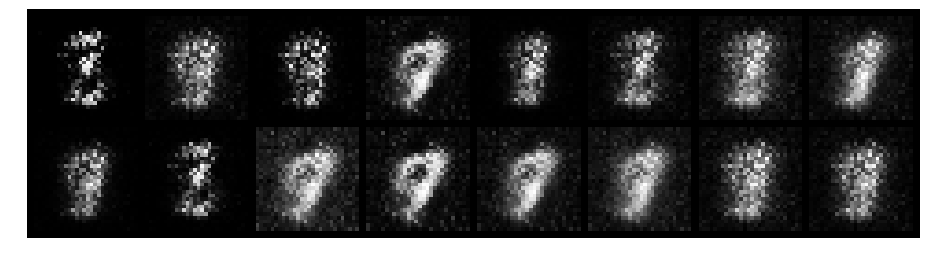

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.6270, Generator Loss: 2.4034
D(x): 0.8002, D(G(z)): 0.2299


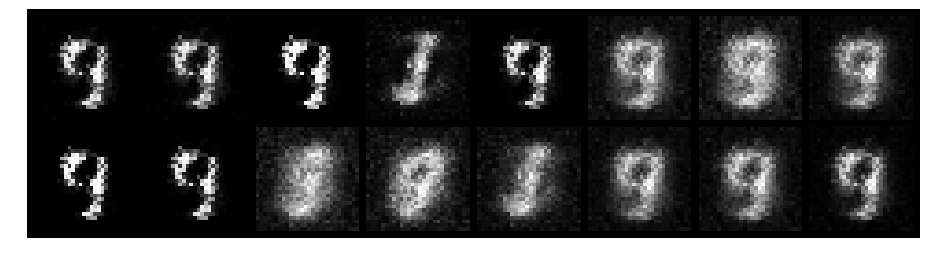

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.7937, Generator Loss: 1.9653
D(x): 0.7592, D(G(z)): 0.2601


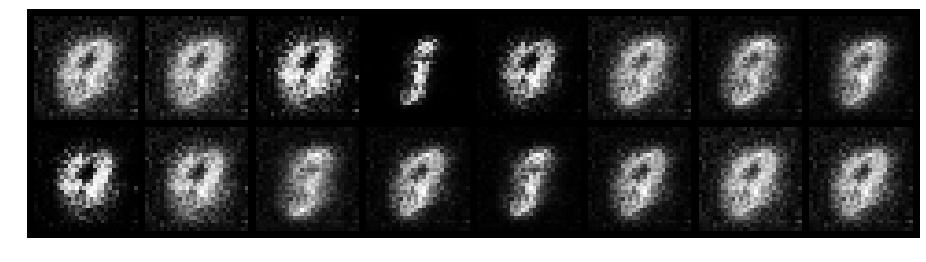

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.4313, Generator Loss: 2.9901
D(x): 0.8546, D(G(z)): 0.1159


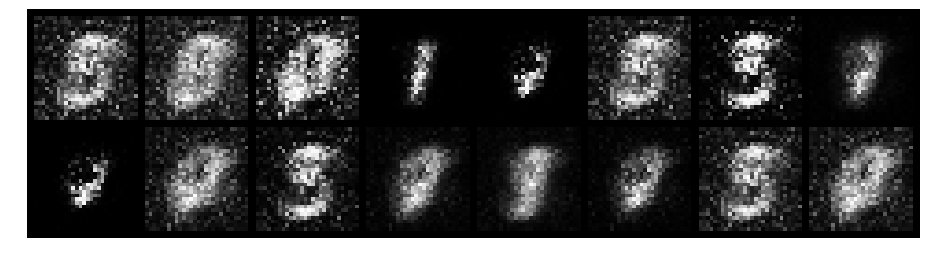

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.4445, Generator Loss: 2.7244
D(x): 0.8948, D(G(z)): 0.1836


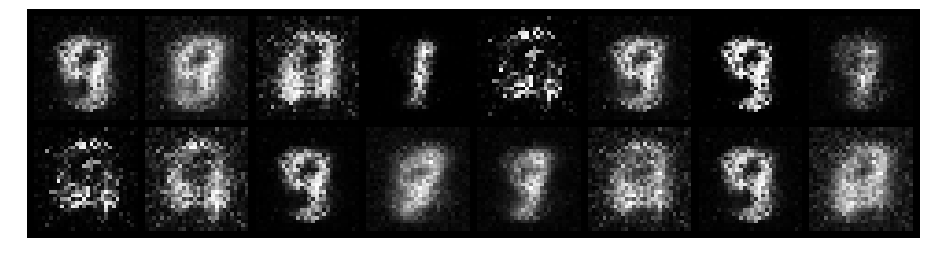

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.7092, Generator Loss: 2.6000
D(x): 0.7967, D(G(z)): 0.1838


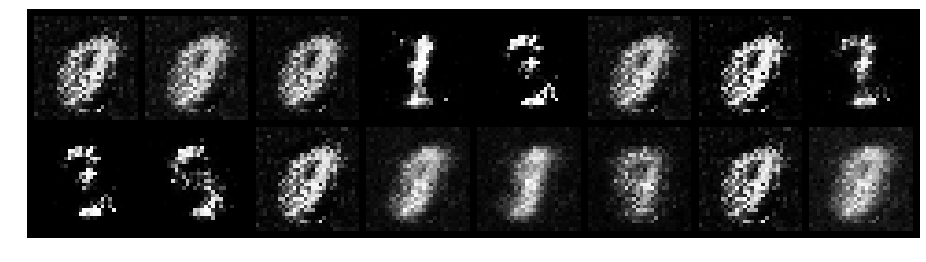

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.5015, Generator Loss: 2.5500
D(x): 0.8588, D(G(z)): 0.1828


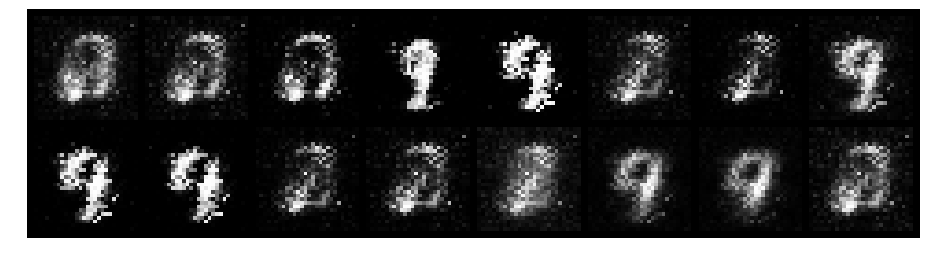

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.5993, Generator Loss: 2.9153
D(x): 0.7707, D(G(z)): 0.1363


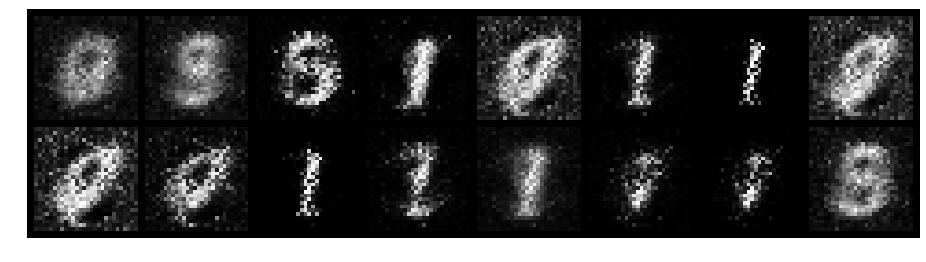

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.6089, Generator Loss: 3.5148
D(x): 0.8056, D(G(z)): 0.1323


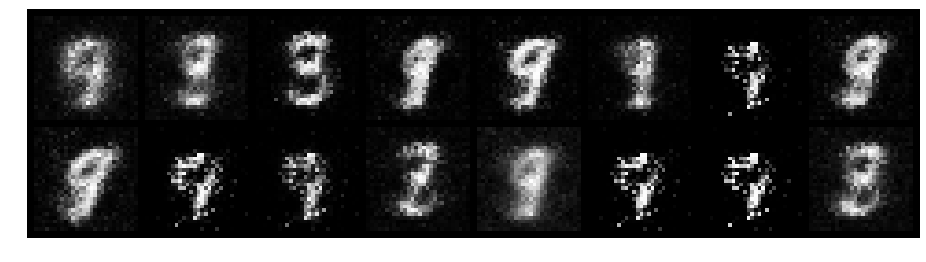

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.3493, Generator Loss: 4.3650
D(x): 0.8519, D(G(z)): 0.0635


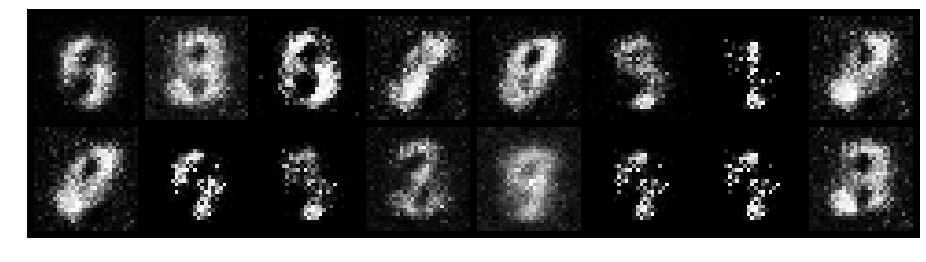

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.3954, Generator Loss: 3.3268
D(x): 0.8852, D(G(z)): 0.1359


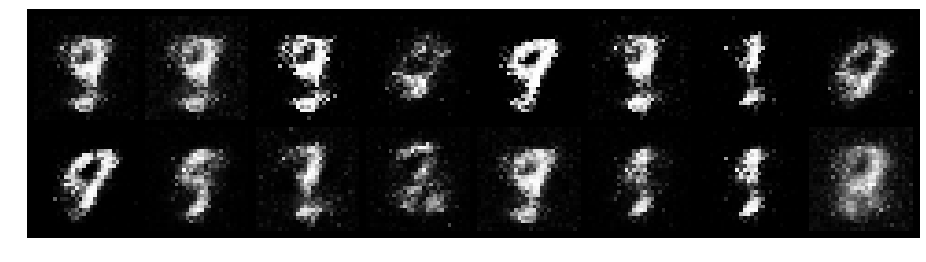

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.6281, Generator Loss: 3.0617
D(x): 0.8061, D(G(z)): 0.1150


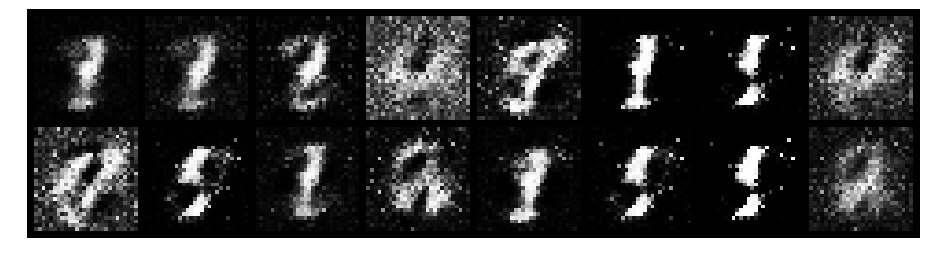

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.8068, Generator Loss: 2.8760
D(x): 0.8753, D(G(z)): 0.2525


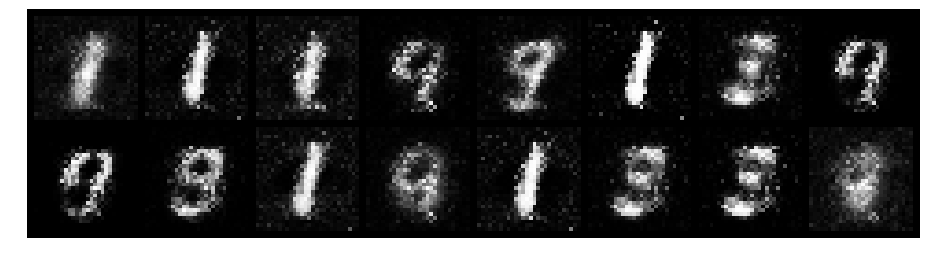

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.4562, Generator Loss: 3.4115
D(x): 0.8030, D(G(z)): 0.0735


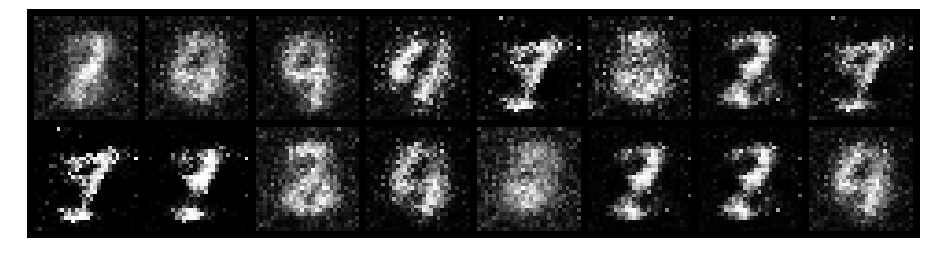

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.7466, Generator Loss: 3.1427
D(x): 0.8239, D(G(z)): 0.1931


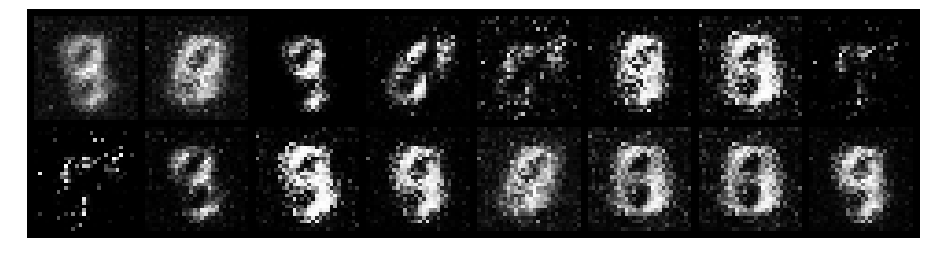

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 1.0234, Generator Loss: 1.7644
D(x): 0.6544, D(G(z)): 0.3456


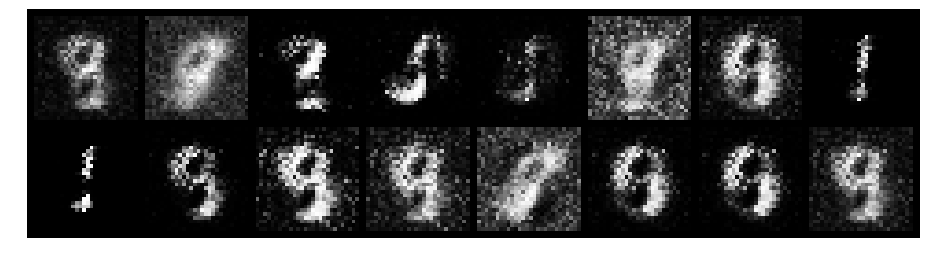

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.7221, Generator Loss: 2.3579
D(x): 0.7614, D(G(z)): 0.1845


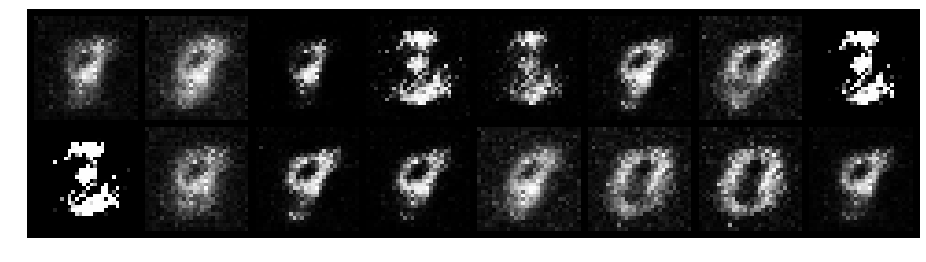

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.3170, Generator Loss: 4.3314
D(x): 0.9125, D(G(z)): 0.1038


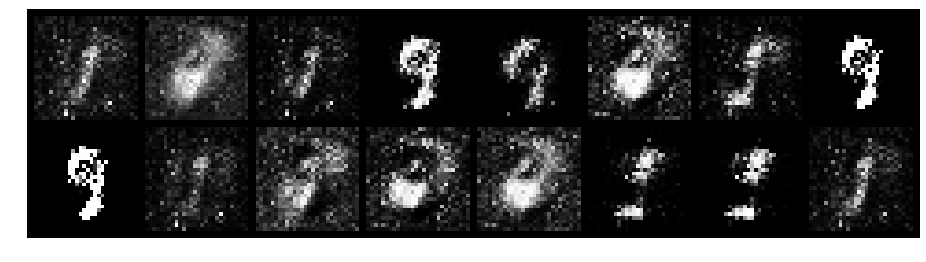

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.3401, Generator Loss: 3.3066
D(x): 0.8801, D(G(z)): 0.1117


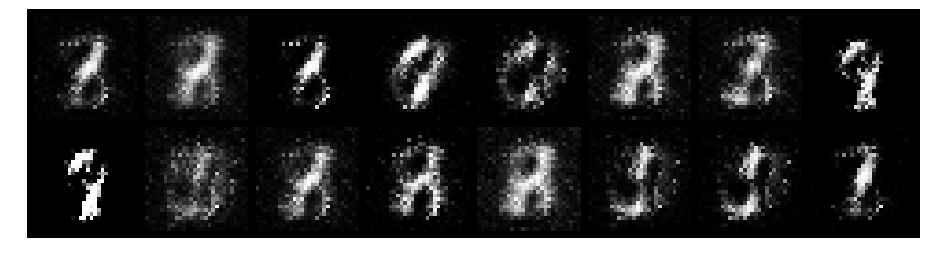

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.4031, Generator Loss: 3.2314
D(x): 0.9069, D(G(z)): 0.1414


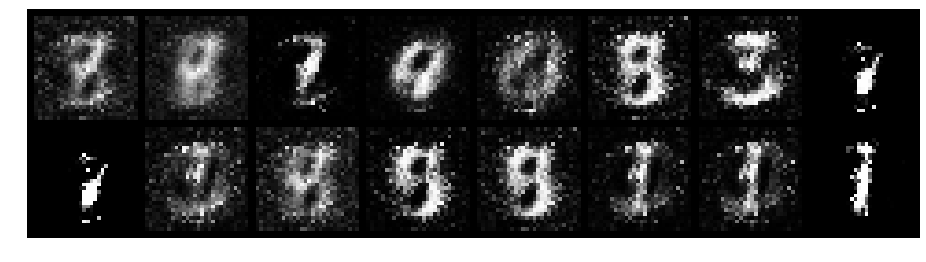

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.4779, Generator Loss: 3.1628
D(x): 0.8495, D(G(z)): 0.1395


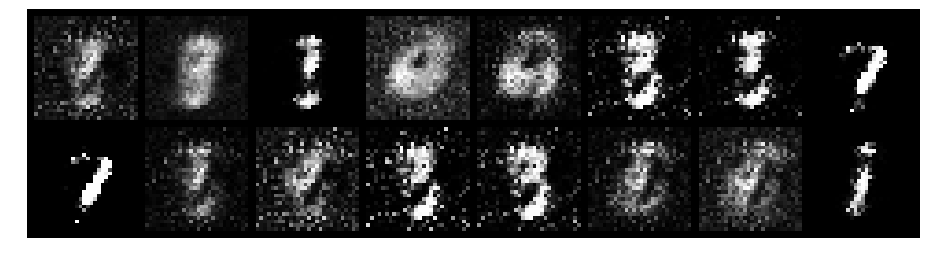

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.7473, Generator Loss: 2.7036
D(x): 0.8213, D(G(z)): 0.2675


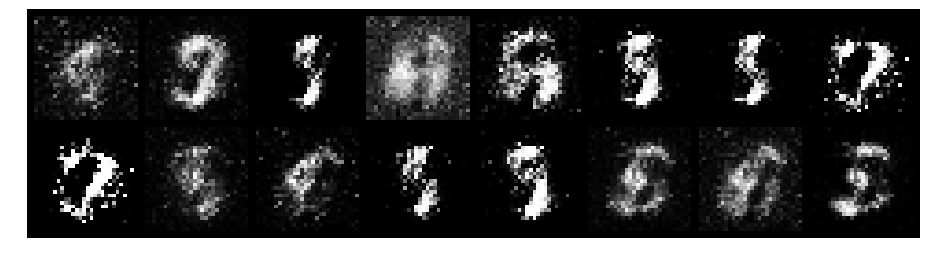

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.4401, Generator Loss: 2.9325
D(x): 0.8434, D(G(z)): 0.1739


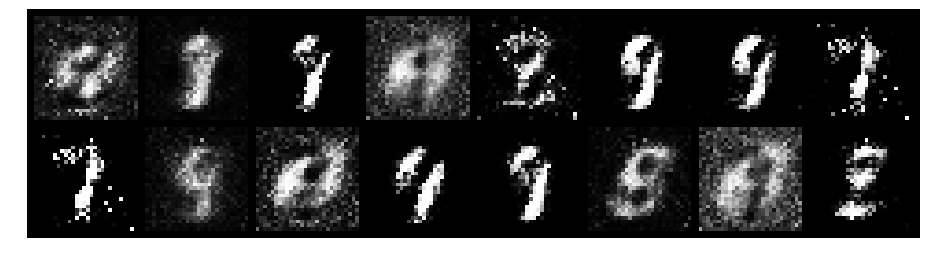

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.4570, Generator Loss: 2.7637
D(x): 0.8730, D(G(z)): 0.2050


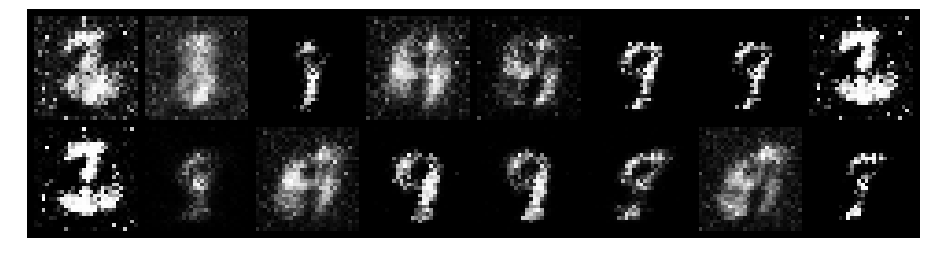

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.5448, Generator Loss: 2.4734
D(x): 0.8463, D(G(z)): 0.1852


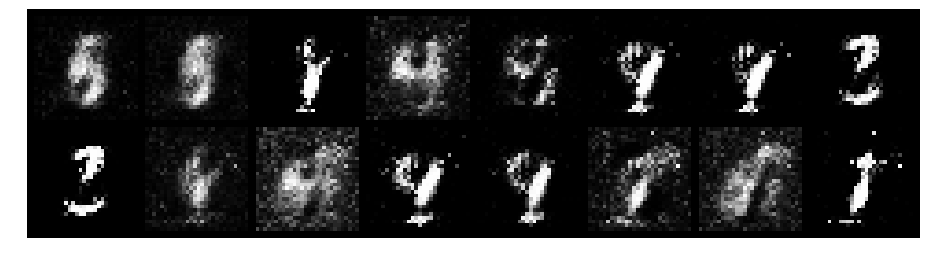

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.7769, Generator Loss: 2.1856
D(x): 0.8212, D(G(z)): 0.2830


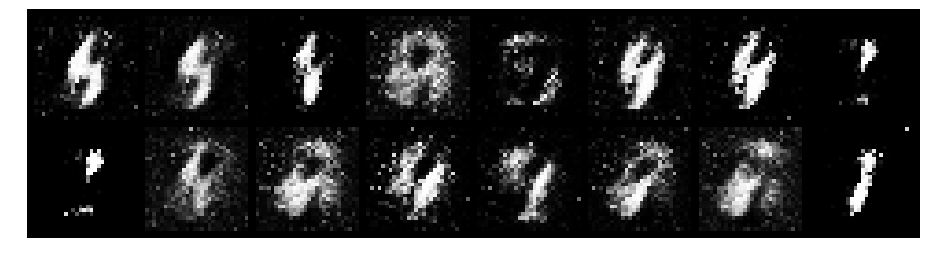

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.4450, Generator Loss: 3.2599
D(x): 0.8455, D(G(z)): 0.1212


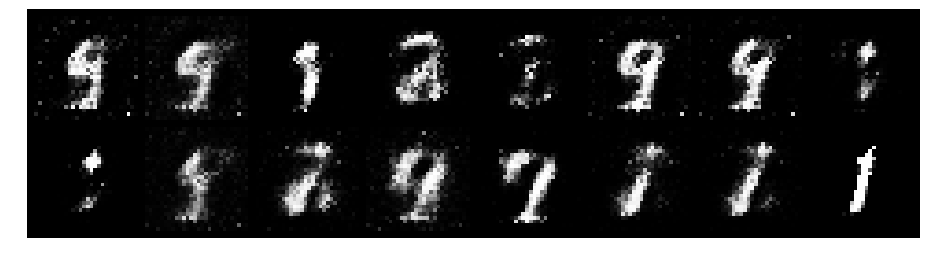

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.5978, Generator Loss: 3.3948
D(x): 0.7855, D(G(z)): 0.1283


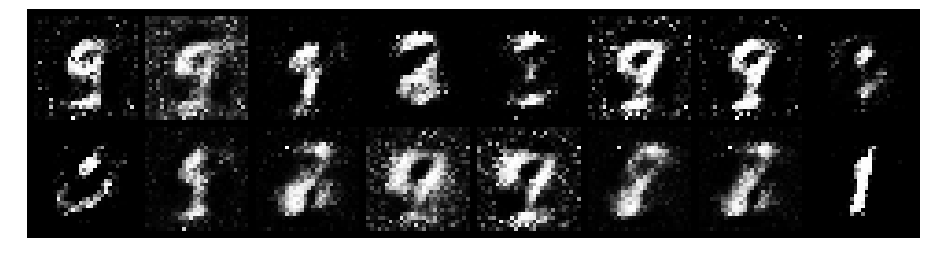

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.5765, Generator Loss: 3.5982
D(x): 0.7575, D(G(z)): 0.0823


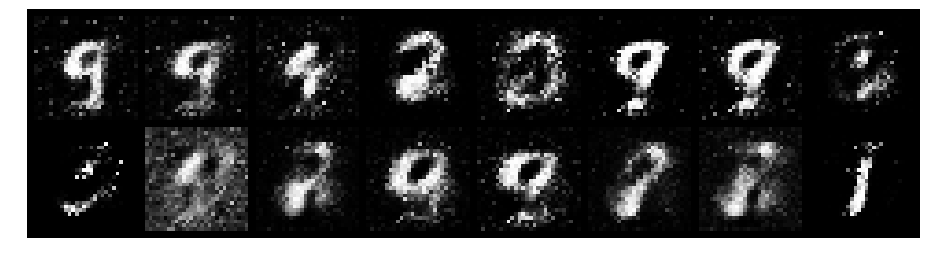

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.4761, Generator Loss: 2.3574
D(x): 0.8402, D(G(z)): 0.1165


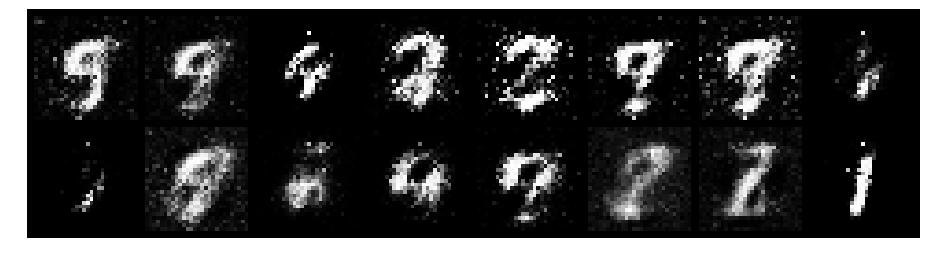

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.6365, Generator Loss: 2.2080
D(x): 0.7721, D(G(z)): 0.1958


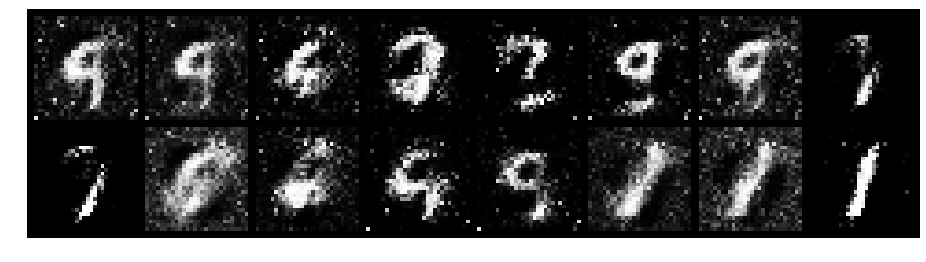

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.7311, Generator Loss: 1.8088
D(x): 0.7461, D(G(z)): 0.2329


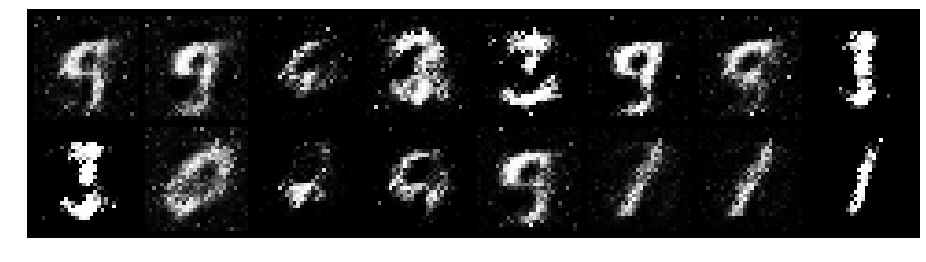

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.6431, Generator Loss: 3.6093
D(x): 0.8043, D(G(z)): 0.1737


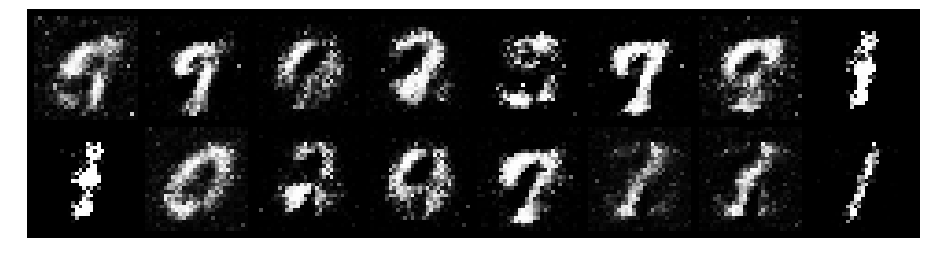

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.4653, Generator Loss: 3.4367
D(x): 0.7990, D(G(z)): 0.0954


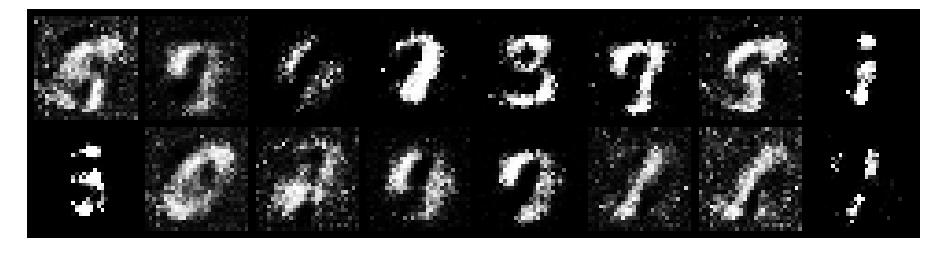

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.8416, Generator Loss: 2.3779
D(x): 0.6685, D(G(z)): 0.1582


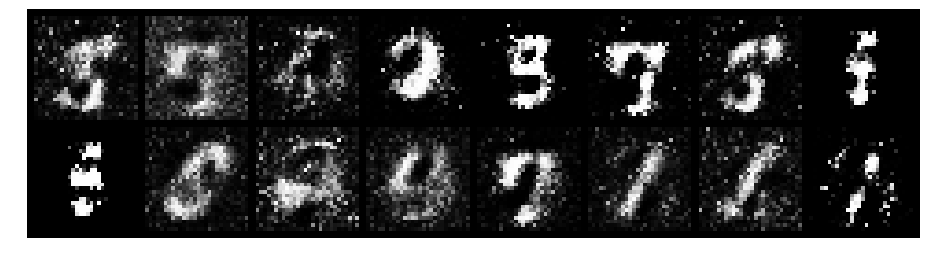

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.4879, Generator Loss: 2.7151
D(x): 0.8569, D(G(z)): 0.2069


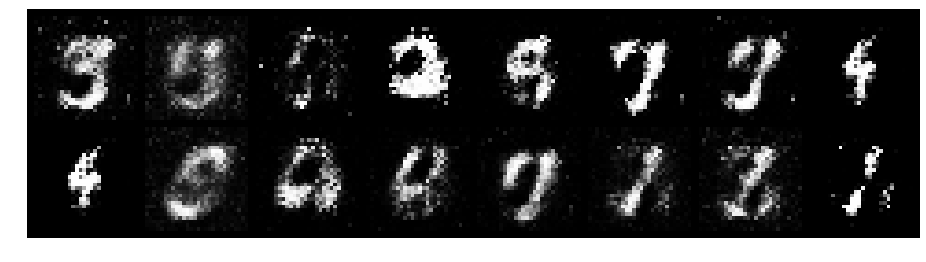

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.5062, Generator Loss: 2.5982
D(x): 0.8196, D(G(z)): 0.1565


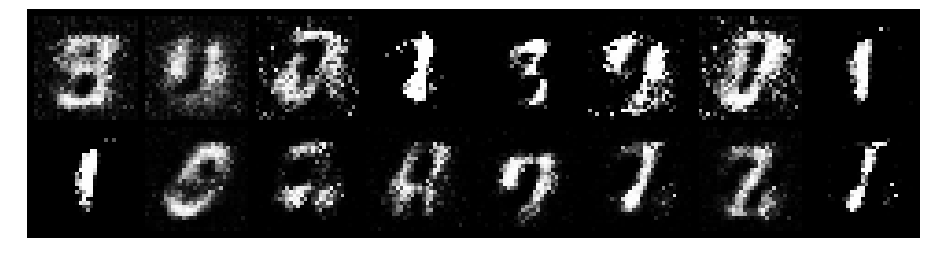

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.5751, Generator Loss: 2.6866
D(x): 0.8422, D(G(z)): 0.1911


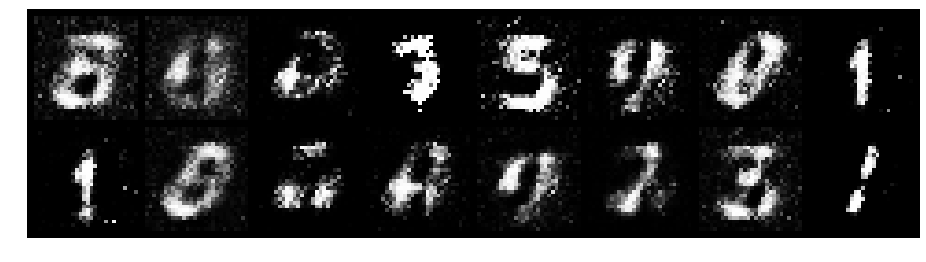

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.5417, Generator Loss: 3.5518
D(x): 0.8741, D(G(z)): 0.2149


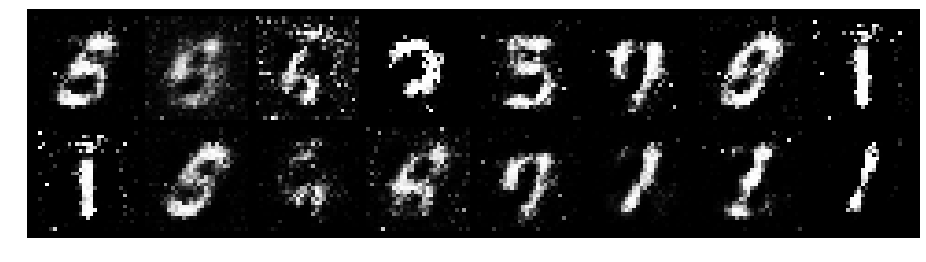

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.8021, Generator Loss: 2.2758
D(x): 0.7899, D(G(z)): 0.2836


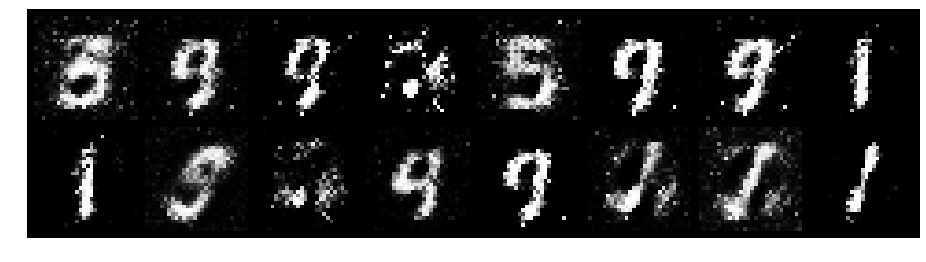

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.8312, Generator Loss: 1.4596
D(x): 0.7560, D(G(z)): 0.2905


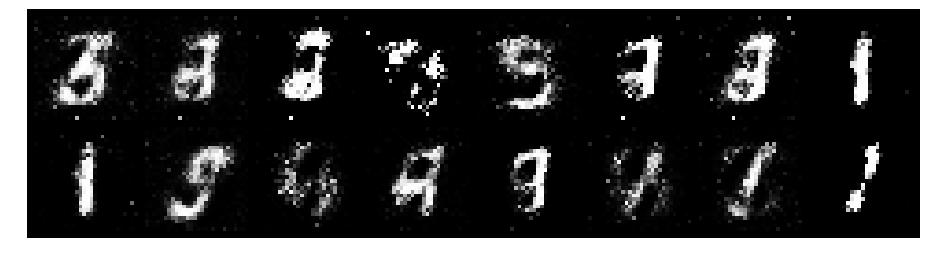

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.4853, Generator Loss: 2.8578
D(x): 0.7992, D(G(z)): 0.1404


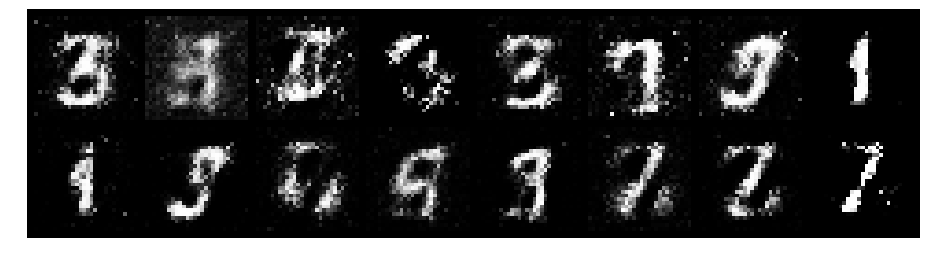

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.7649, Generator Loss: 2.0400
D(x): 0.7756, D(G(z)): 0.2619


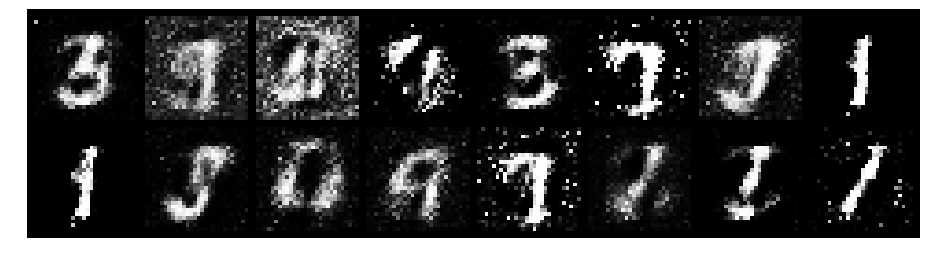

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.7908, Generator Loss: 2.0880
D(x): 0.7999, D(G(z)): 0.2872


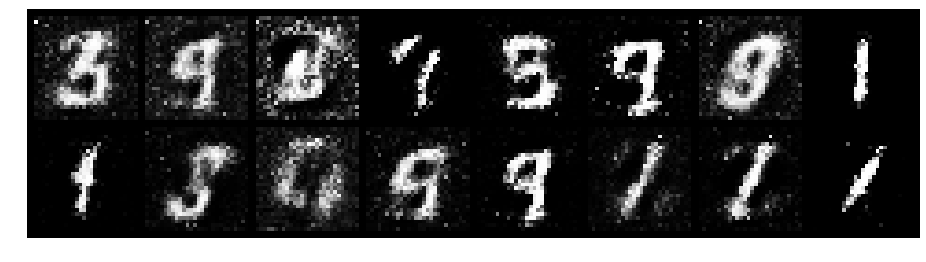

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.9944, Generator Loss: 1.6550
D(x): 0.7501, D(G(z)): 0.3267


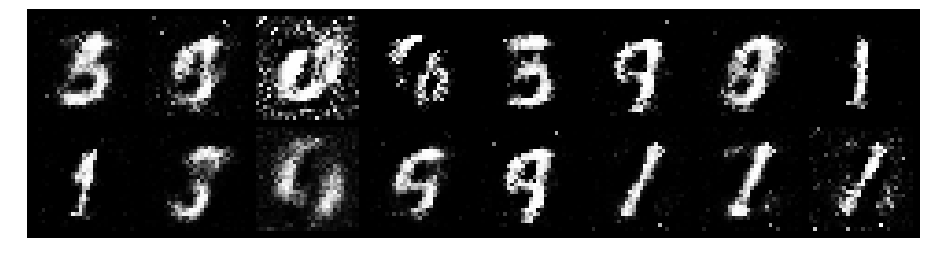

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.6911, Generator Loss: 2.1100
D(x): 0.7753, D(G(z)): 0.2011


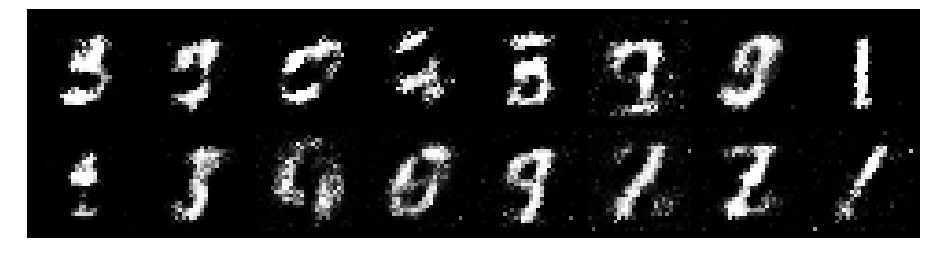

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.9836, Generator Loss: 1.6172
D(x): 0.7334, D(G(z)): 0.3308


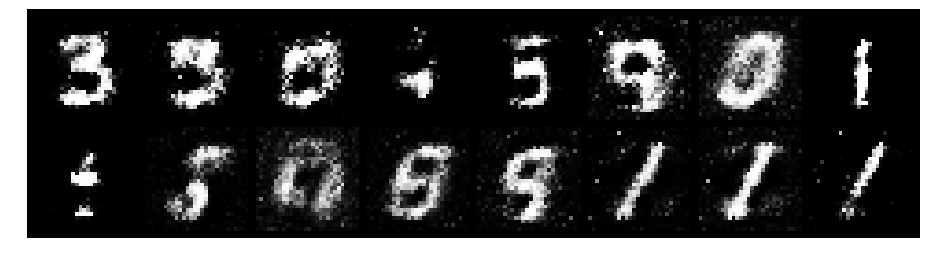

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.6518, Generator Loss: 2.4845
D(x): 0.7636, D(G(z)): 0.1872


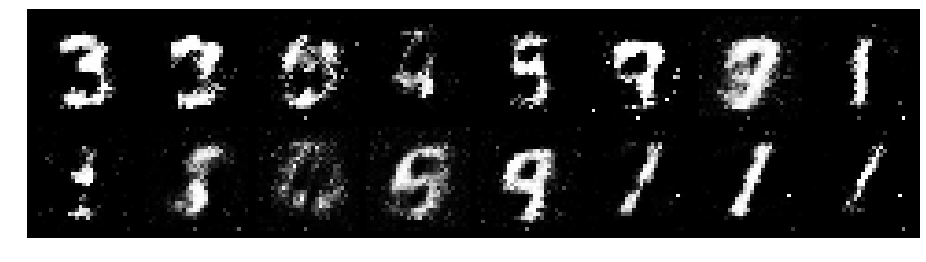

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.5369, Generator Loss: 2.6289
D(x): 0.8233, D(G(z)): 0.1677


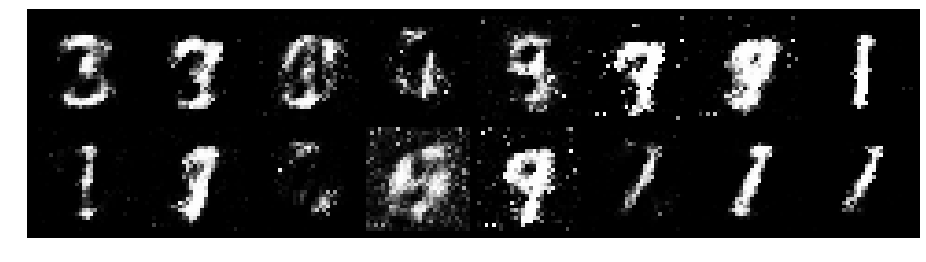

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.6681, Generator Loss: 1.7806
D(x): 0.7995, D(G(z)): 0.2204


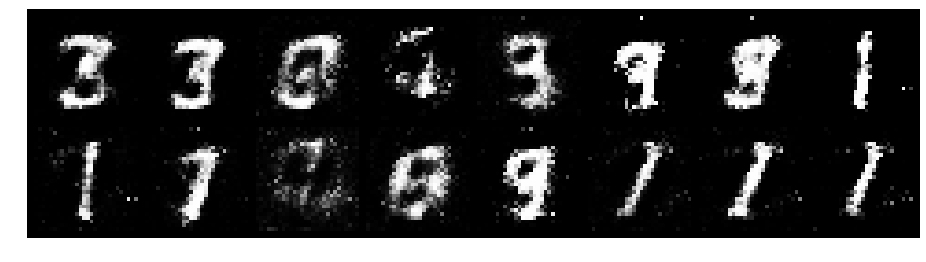

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.6101, Generator Loss: 2.2596
D(x): 0.8176, D(G(z)): 0.2056


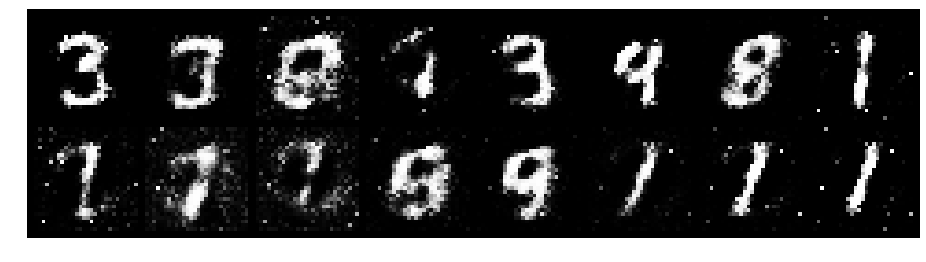

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.6248, Generator Loss: 1.8535
D(x): 0.8155, D(G(z)): 0.2599


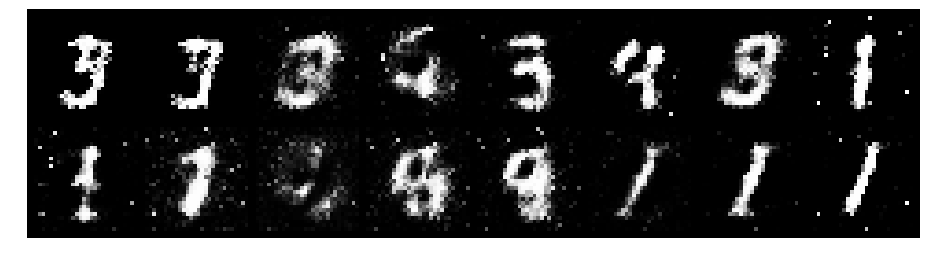

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.8261, Generator Loss: 2.0540
D(x): 0.7596, D(G(z)): 0.2608


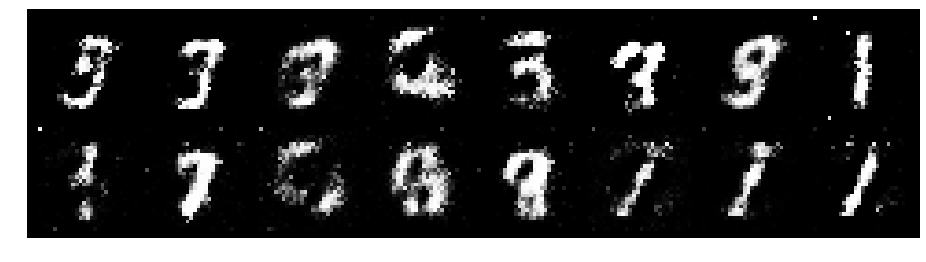

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.7302, Generator Loss: 1.7456
D(x): 0.7625, D(G(z)): 0.2612


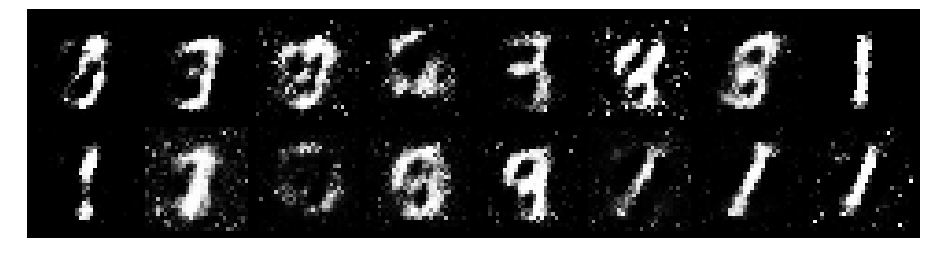

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.8468, Generator Loss: 2.3500
D(x): 0.7345, D(G(z)): 0.2546


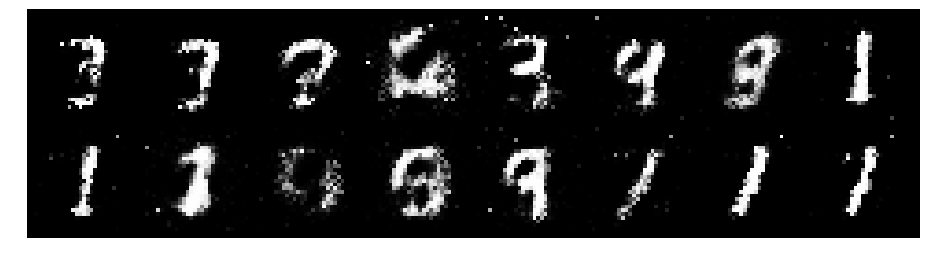

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.7969, Generator Loss: 1.6233
D(x): 0.7124, D(G(z)): 0.2590


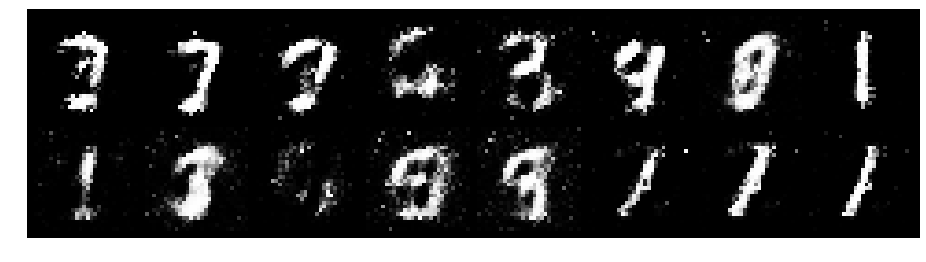

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.8858, Generator Loss: 1.5578
D(x): 0.7308, D(G(z)): 0.2879


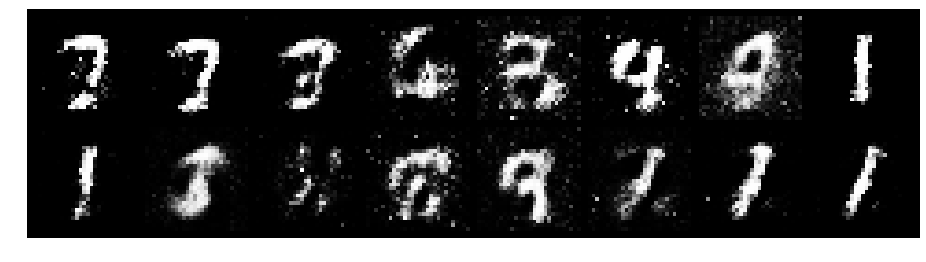

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.7106, Generator Loss: 2.3384
D(x): 0.7991, D(G(z)): 0.2171


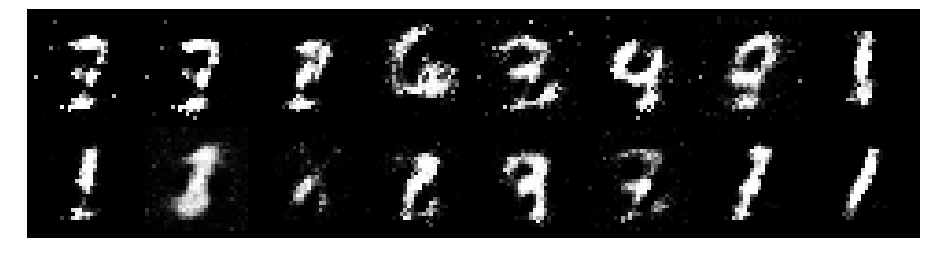

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.4925, Generator Loss: 1.7521
D(x): 0.8552, D(G(z)): 0.2248


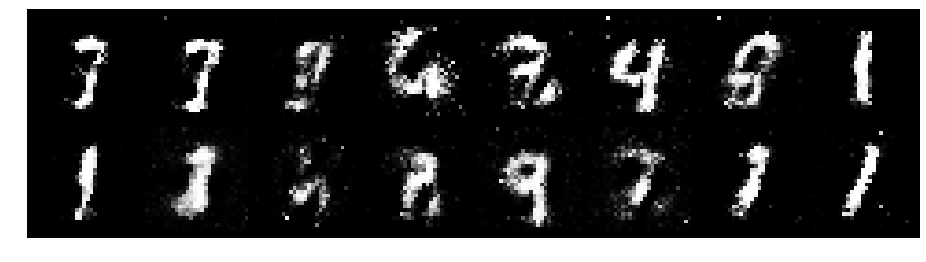

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.7029, Generator Loss: 1.9221
D(x): 0.7910, D(G(z)): 0.2697


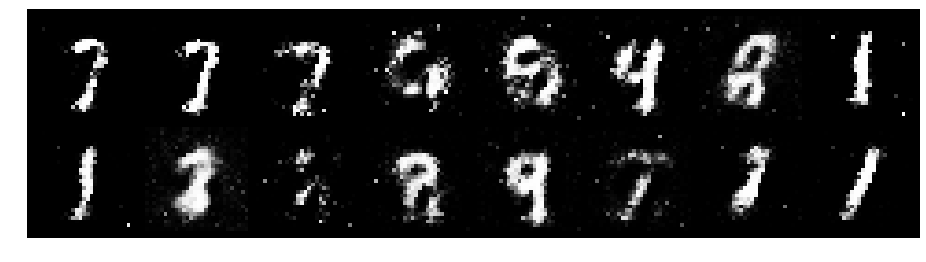

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.7269, Generator Loss: 2.0569
D(x): 0.7850, D(G(z)): 0.2774


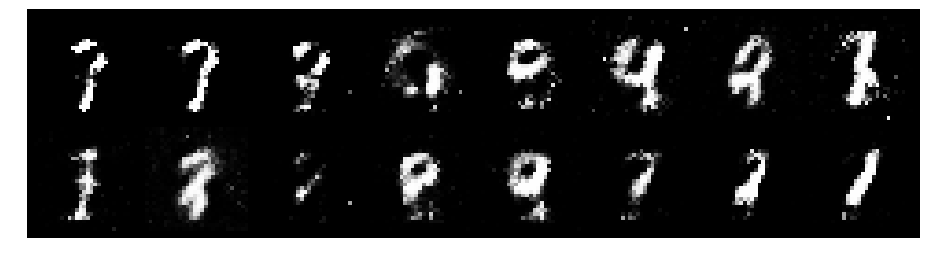

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.8473, Generator Loss: 1.8138
D(x): 0.6638, D(G(z)): 0.2049


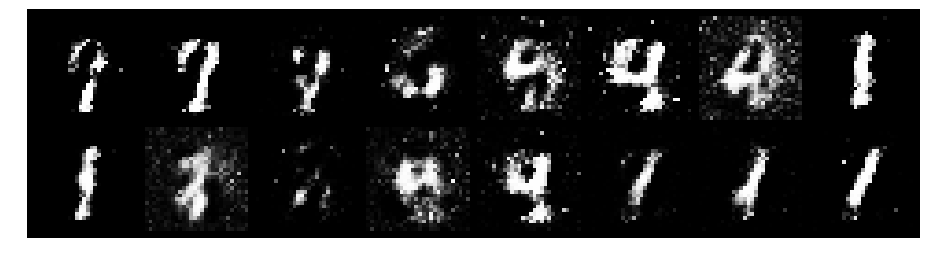

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.8750, Generator Loss: 1.7390
D(x): 0.7326, D(G(z)): 0.2982


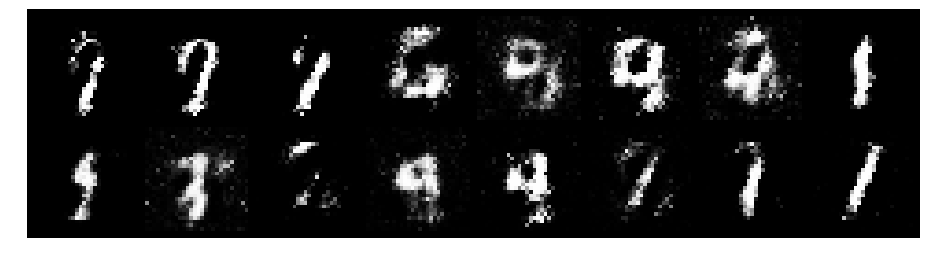

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.9032, Generator Loss: 1.9359
D(x): 0.6687, D(G(z)): 0.2229


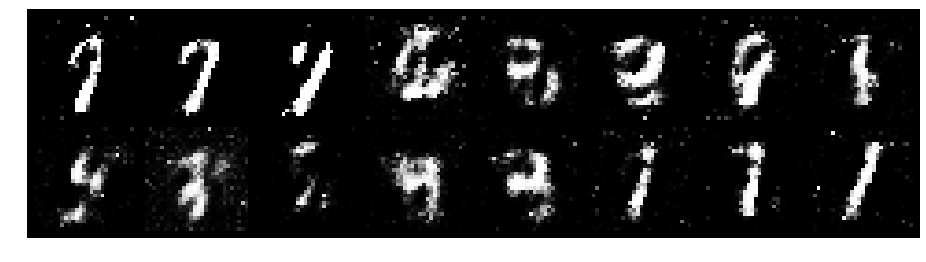

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.7749, Generator Loss: 1.5745
D(x): 0.7820, D(G(z)): 0.2770


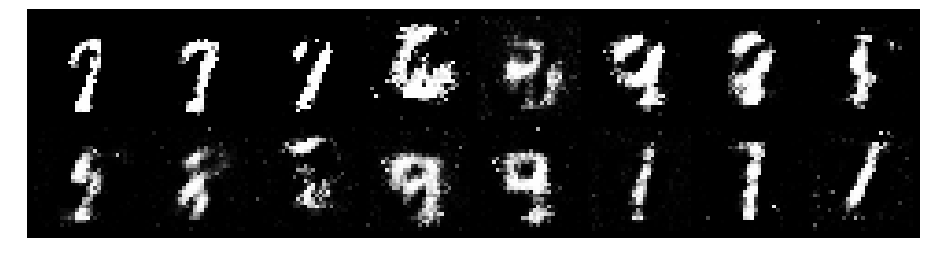

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.6541, Generator Loss: 1.9078
D(x): 0.8518, D(G(z)): 0.3021


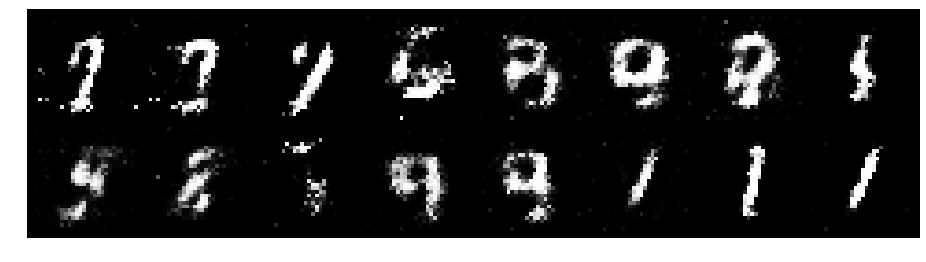

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.6890, Generator Loss: 1.9865
D(x): 0.7077, D(G(z)): 0.1632


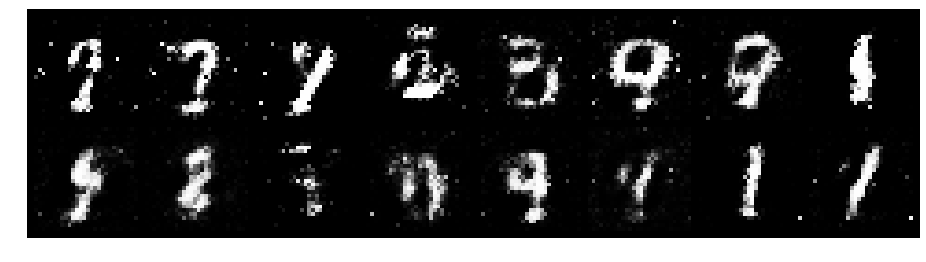

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.5282, Generator Loss: 2.1905
D(x): 0.7681, D(G(z)): 0.1480


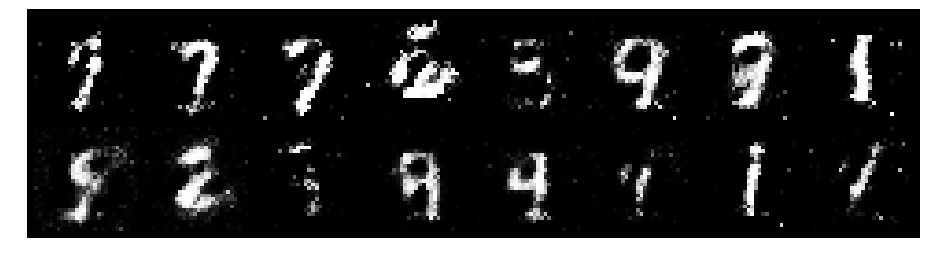

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.7376, Generator Loss: 2.4812
D(x): 0.7301, D(G(z)): 0.1225


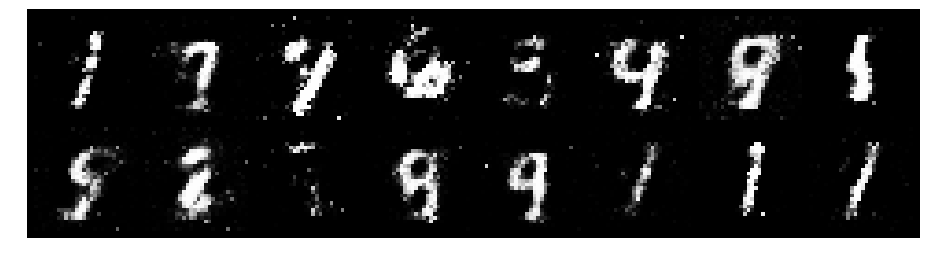

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.8118, Generator Loss: 2.1059
D(x): 0.7552, D(G(z)): 0.2592


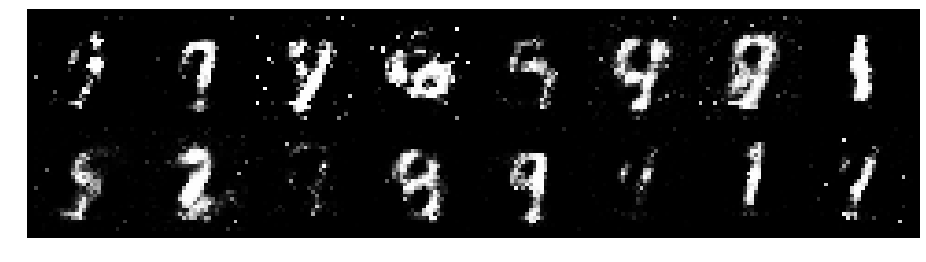

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.6967, Generator Loss: 2.1492
D(x): 0.7363, D(G(z)): 0.2144


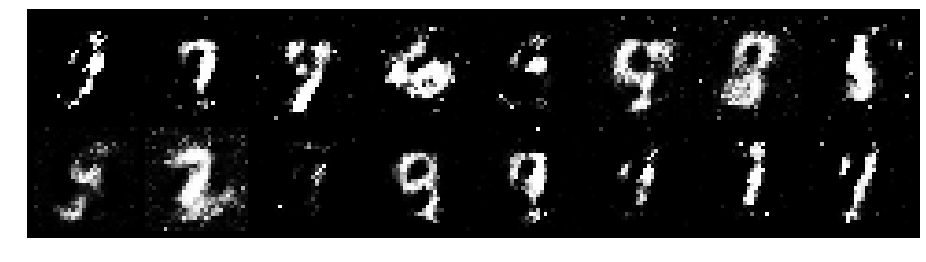

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.7264, Generator Loss: 1.6475
D(x): 0.7716, D(G(z)): 0.2564


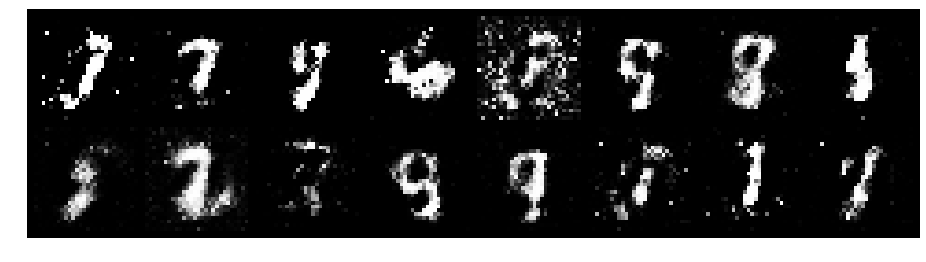

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.8301, Generator Loss: 1.5050
D(x): 0.7373, D(G(z)): 0.3160


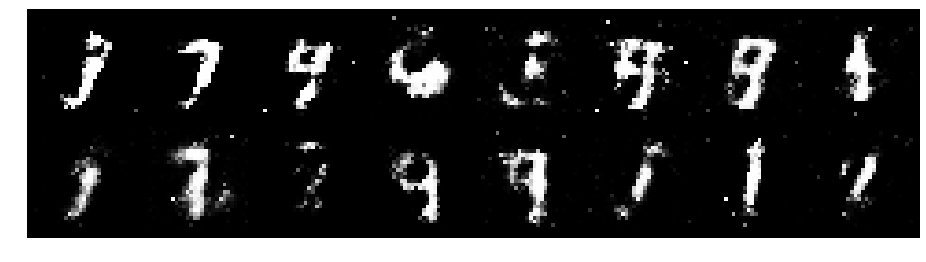

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.9689, Generator Loss: 1.3332
D(x): 0.7184, D(G(z)): 0.3493


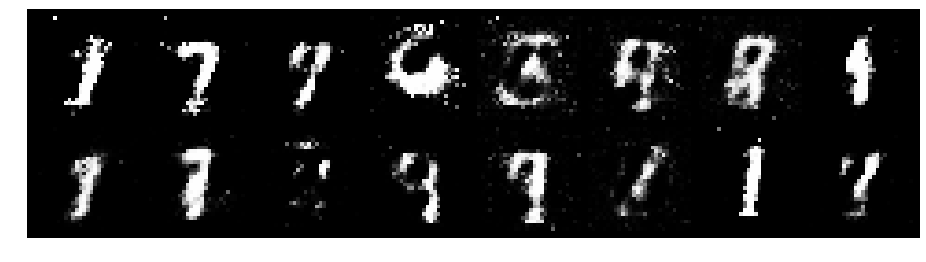

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.9958, Generator Loss: 1.2346
D(x): 0.7904, D(G(z)): 0.4236


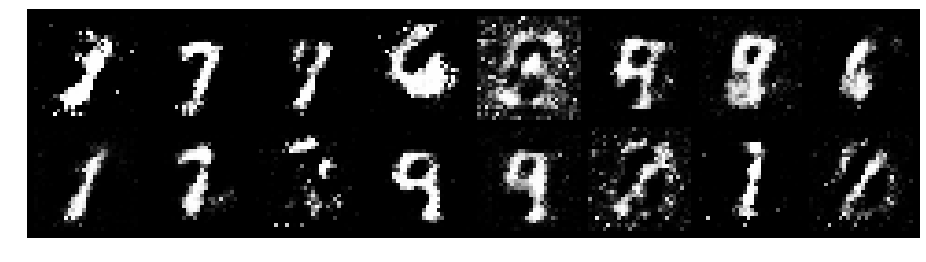

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.9684, Generator Loss: 1.9043
D(x): 0.8100, D(G(z)): 0.3642


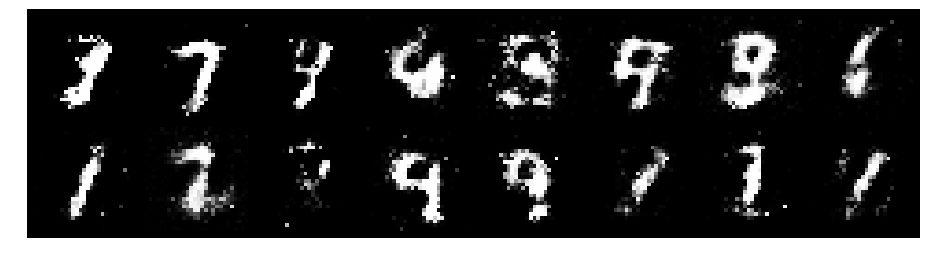

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.8031, Generator Loss: 1.6009
D(x): 0.7591, D(G(z)): 0.2728


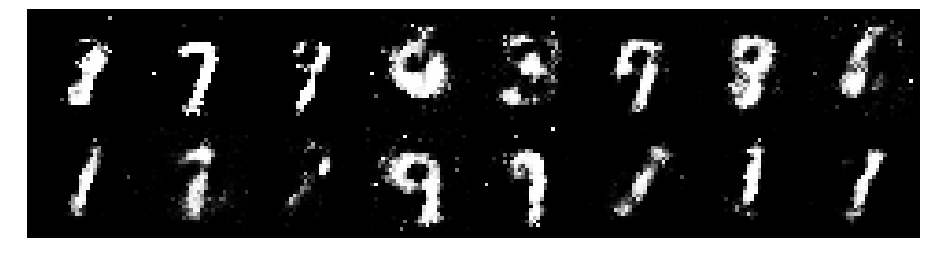

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.7263, Generator Loss: 1.9136
D(x): 0.7809, D(G(z)): 0.2893


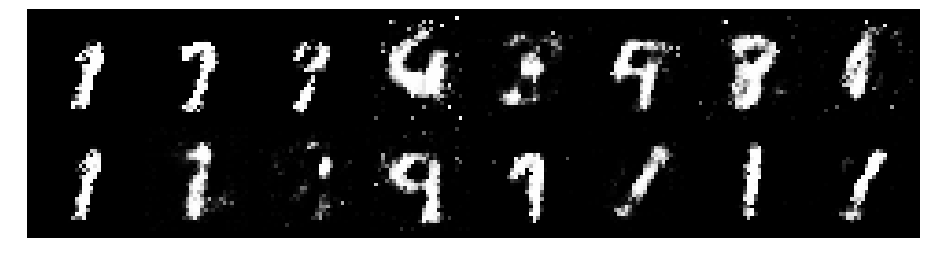

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.6202, Generator Loss: 2.0909
D(x): 0.8179, D(G(z)): 0.2144


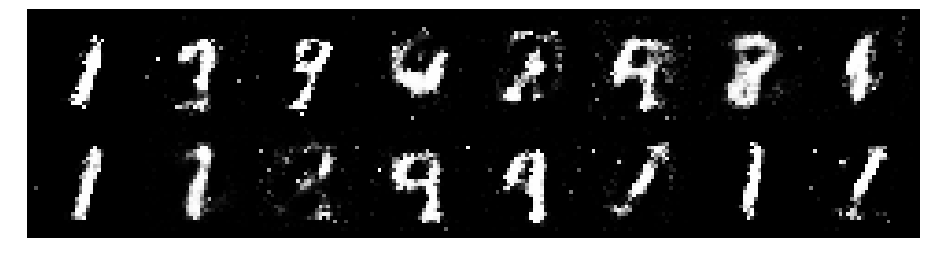

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.7261, Generator Loss: 1.8255
D(x): 0.7430, D(G(z)): 0.2428


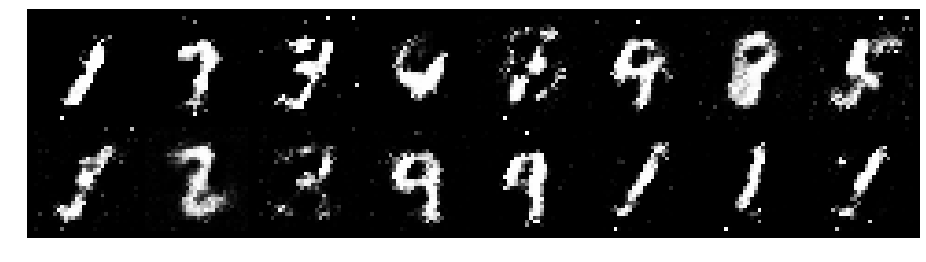

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.7253, Generator Loss: 1.5904
D(x): 0.7345, D(G(z)): 0.2190


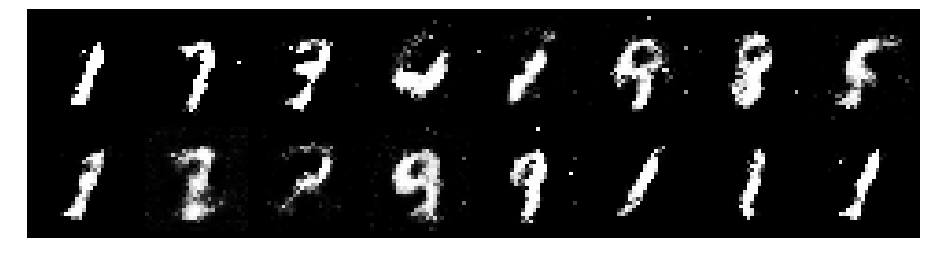

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.8595, Generator Loss: 2.1307
D(x): 0.6844, D(G(z)): 0.1979


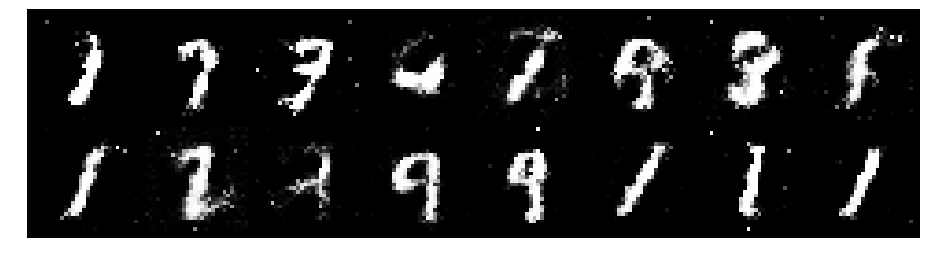

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.9854, Generator Loss: 1.8180
D(x): 0.6434, D(G(z)): 0.2080


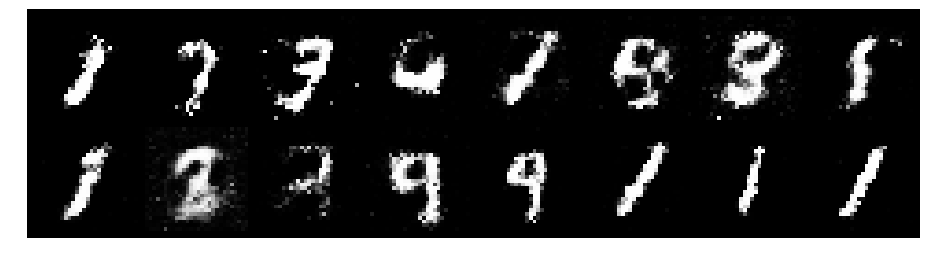

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 1.0946, Generator Loss: 1.6792
D(x): 0.6766, D(G(z)): 0.3198


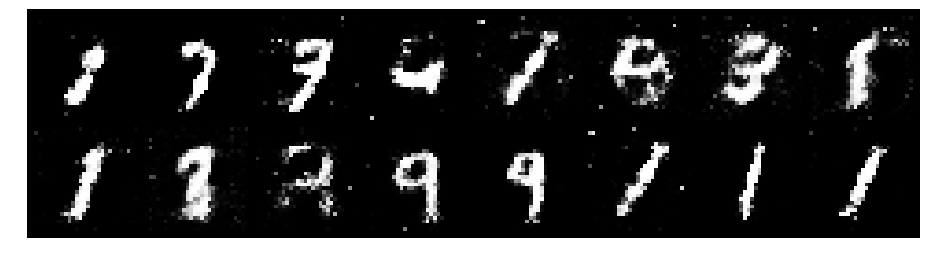

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.9495, Generator Loss: 1.3881
D(x): 0.7064, D(G(z)): 0.2848


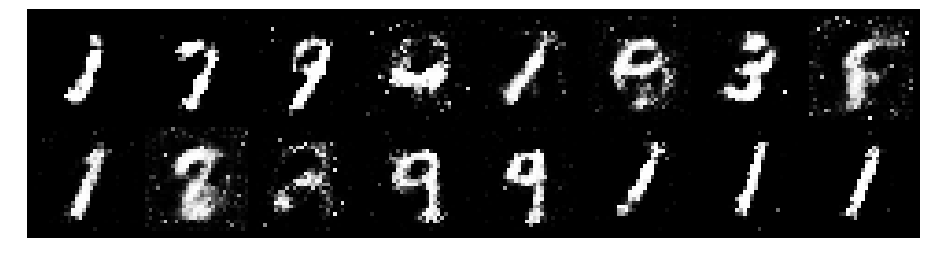

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.8839, Generator Loss: 1.5345
D(x): 0.6798, D(G(z)): 0.2381


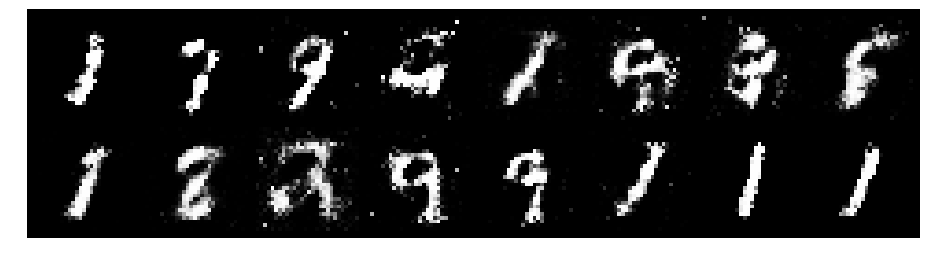

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 1.0595, Generator Loss: 1.5244
D(x): 0.7301, D(G(z)): 0.3471


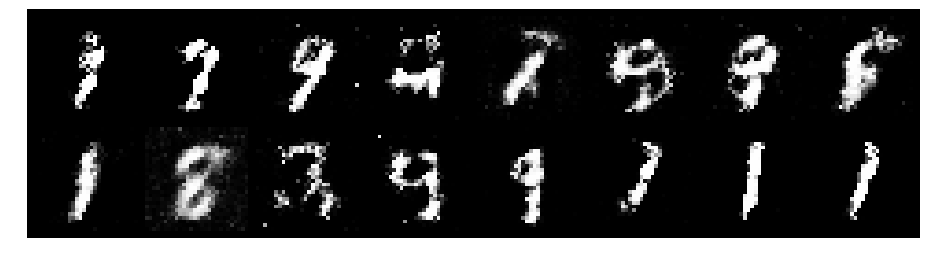

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.6973, Generator Loss: 1.7844
D(x): 0.8145, D(G(z)): 0.2907


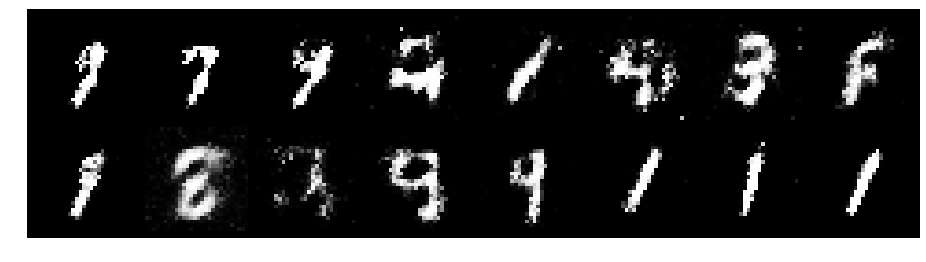

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.6300, Generator Loss: 2.2142
D(x): 0.7844, D(G(z)): 0.2167


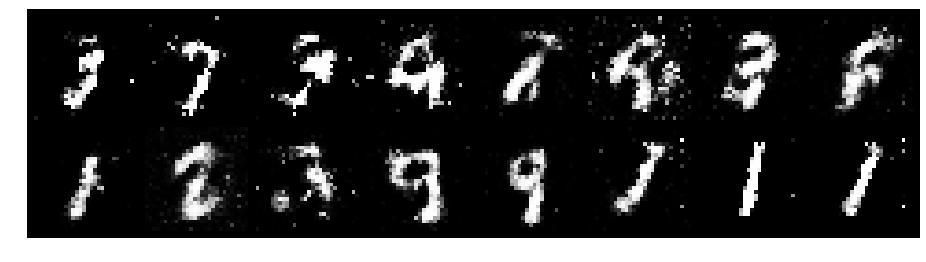

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.6926, Generator Loss: 1.6484
D(x): 0.7462, D(G(z)): 0.2125


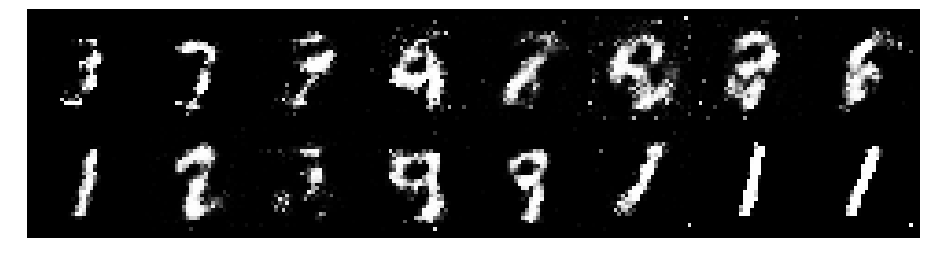

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.5139, Generator Loss: 1.8928
D(x): 0.8259, D(G(z)): 0.1971


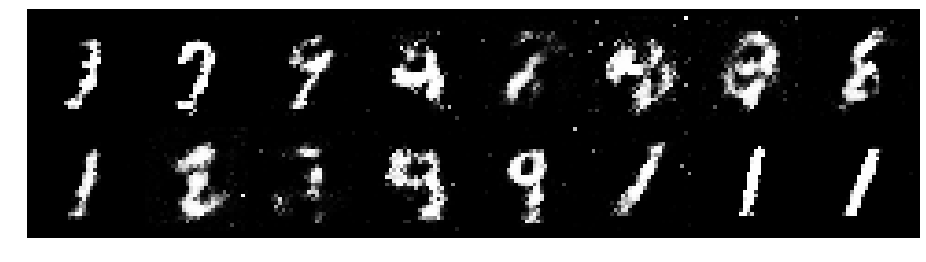

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.6485, Generator Loss: 1.5326
D(x): 0.8265, D(G(z)): 0.2974


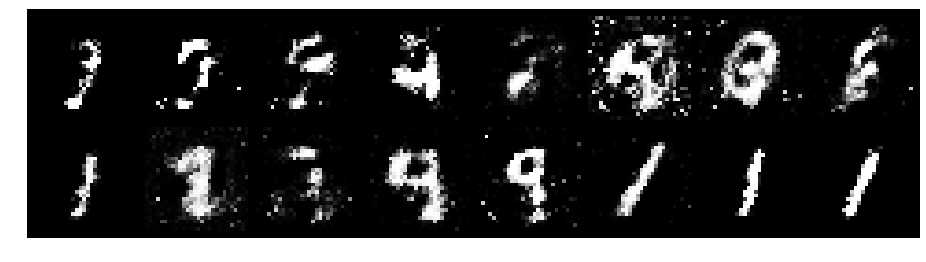

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.7816, Generator Loss: 1.9797
D(x): 0.7184, D(G(z)): 0.2194


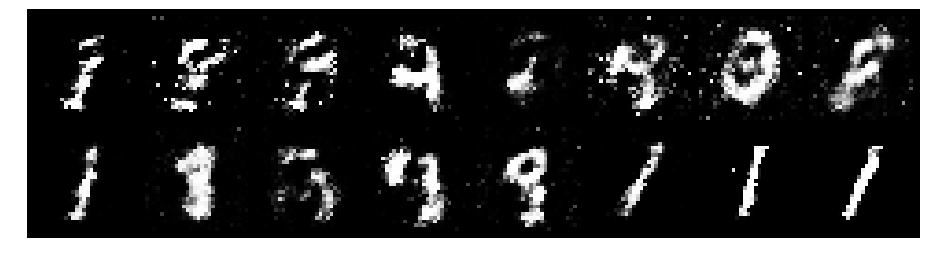

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.6564, Generator Loss: 2.3645
D(x): 0.7756, D(G(z)): 0.2217


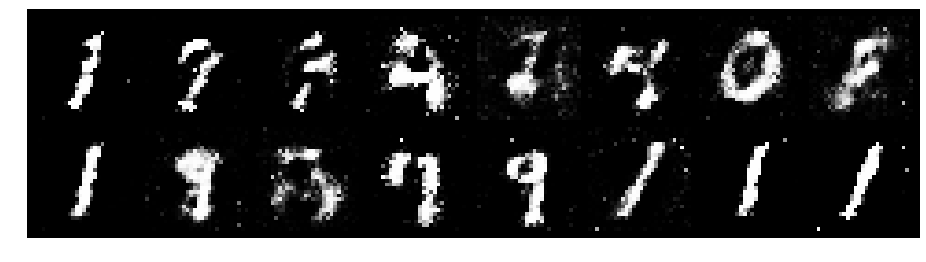

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 0.8574, Generator Loss: 1.5056
D(x): 0.7436, D(G(z)): 0.3210


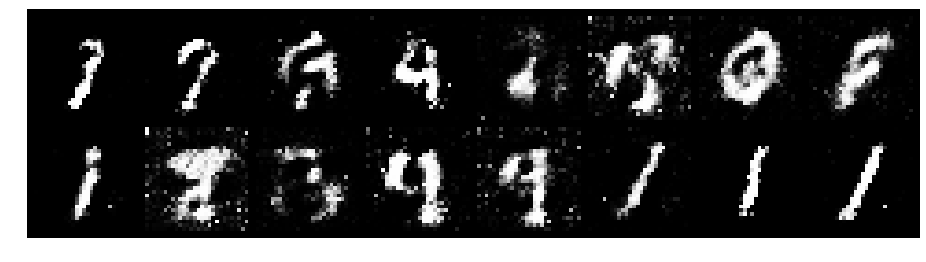

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 0.8521, Generator Loss: 1.5200
D(x): 0.8258, D(G(z)): 0.3779


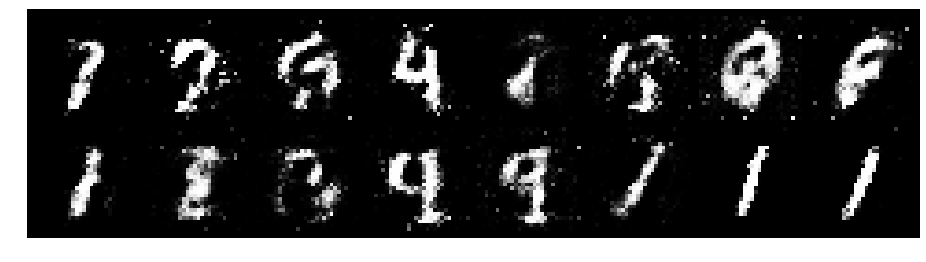

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 1.0762, Generator Loss: 1.2015
D(x): 0.6796, D(G(z)): 0.3543


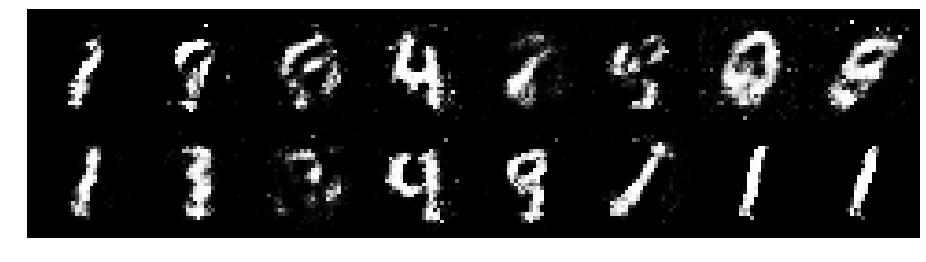

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 0.9055, Generator Loss: 1.6813
D(x): 0.7425, D(G(z)): 0.3267


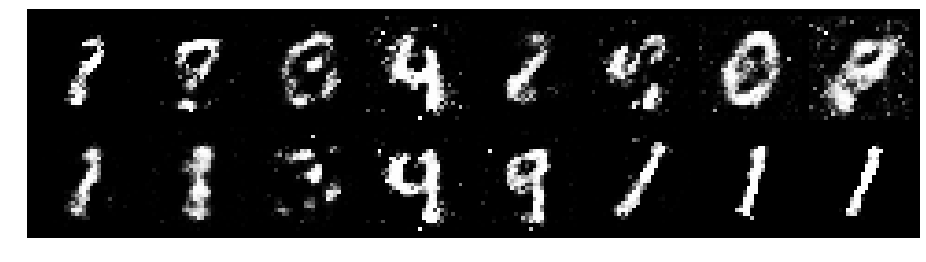

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 1.0710, Generator Loss: 1.5575
D(x): 0.5794, D(G(z)): 0.2510


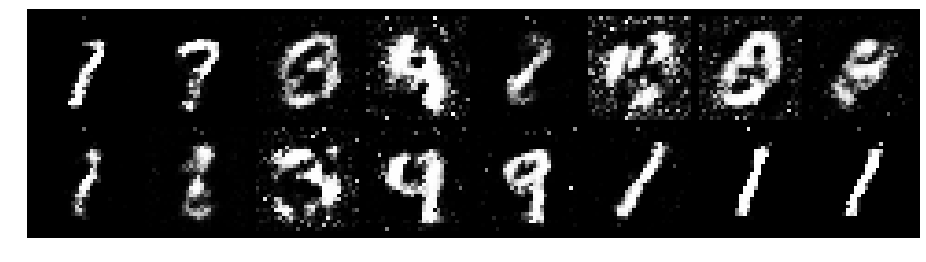

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.9024, Generator Loss: 1.5100
D(x): 0.7608, D(G(z)): 0.3653


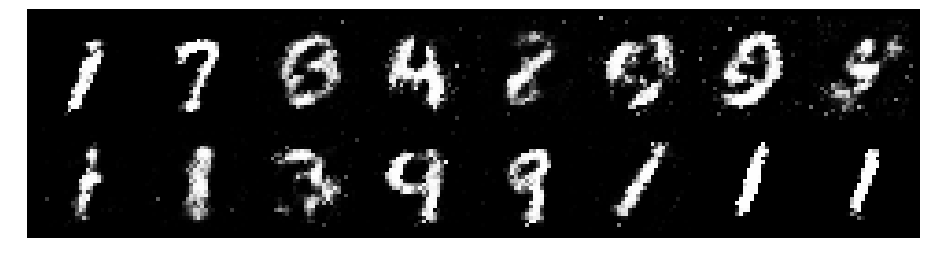

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.8169, Generator Loss: 1.7095
D(x): 0.6907, D(G(z)): 0.2492


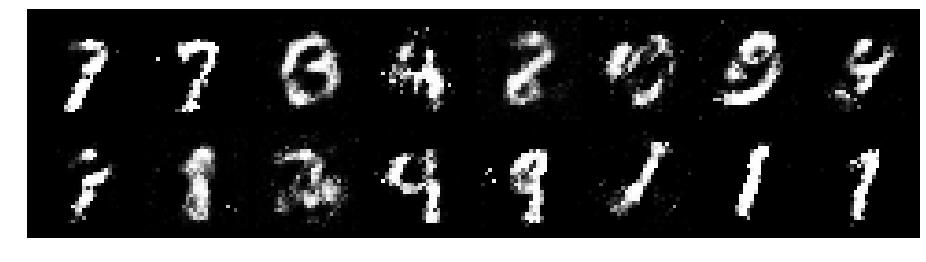

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.8551, Generator Loss: 1.6131
D(x): 0.6885, D(G(z)): 0.2741


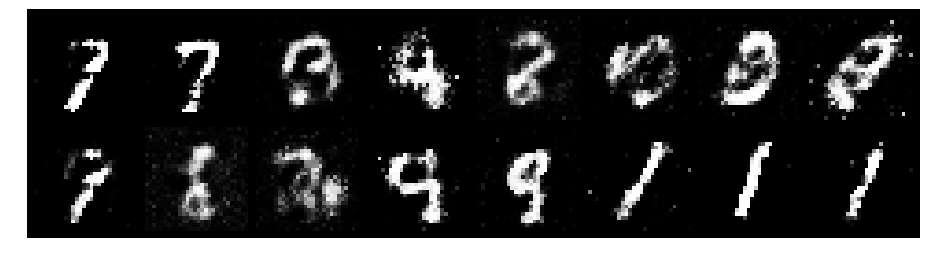

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.9546, Generator Loss: 1.4399
D(x): 0.6627, D(G(z)): 0.2994


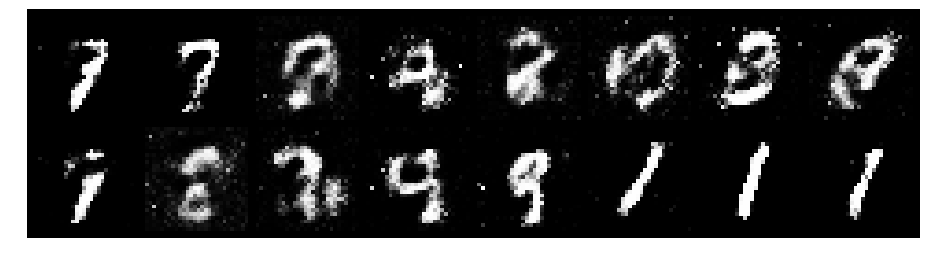

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.9886, Generator Loss: 1.3720
D(x): 0.7512, D(G(z)): 0.3854


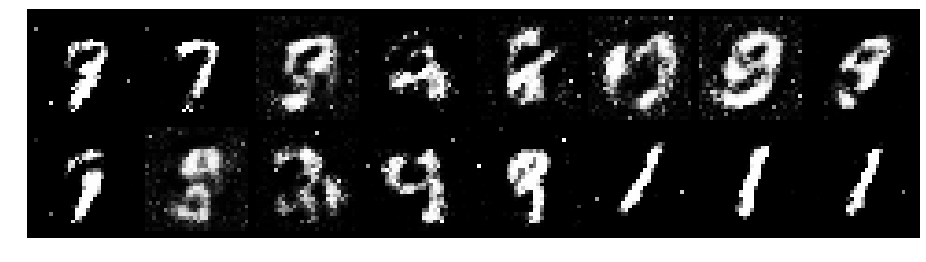

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 1.1001, Generator Loss: 1.3690
D(x): 0.5463, D(G(z)): 0.2855


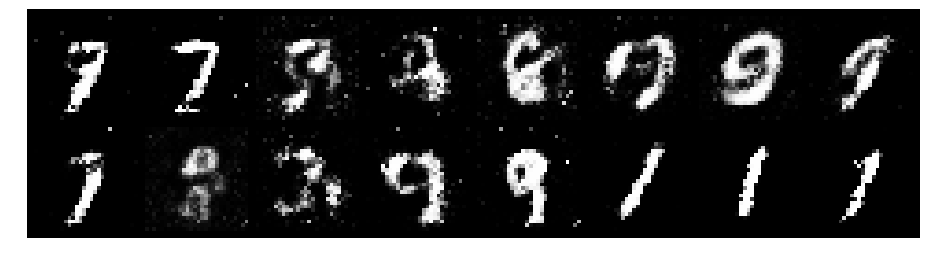

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 0.9168, Generator Loss: 1.6674
D(x): 0.6705, D(G(z)): 0.2839


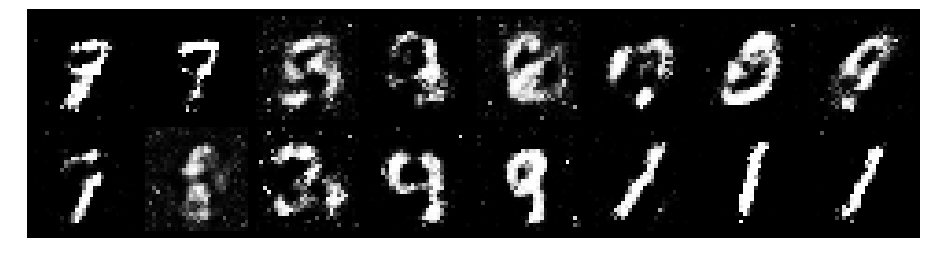

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 0.8955, Generator Loss: 1.5937
D(x): 0.7504, D(G(z)): 0.3534


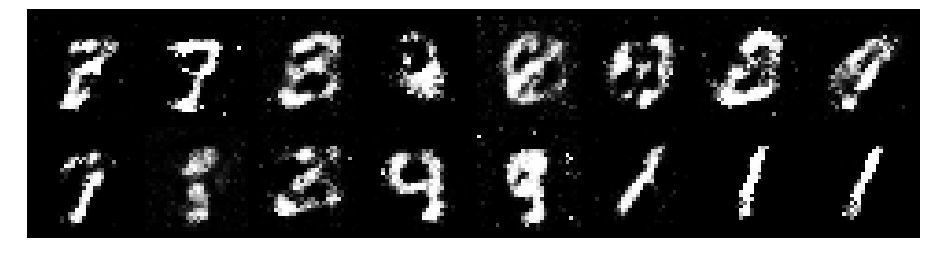

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.7190, Generator Loss: 2.3035
D(x): 0.7292, D(G(z)): 0.2242


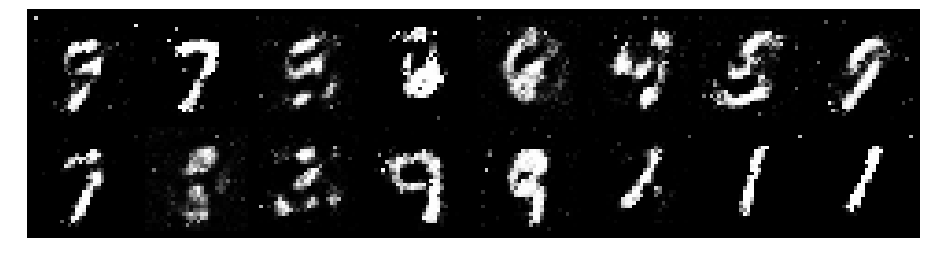

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 0.8960, Generator Loss: 1.6967
D(x): 0.6933, D(G(z)): 0.2228


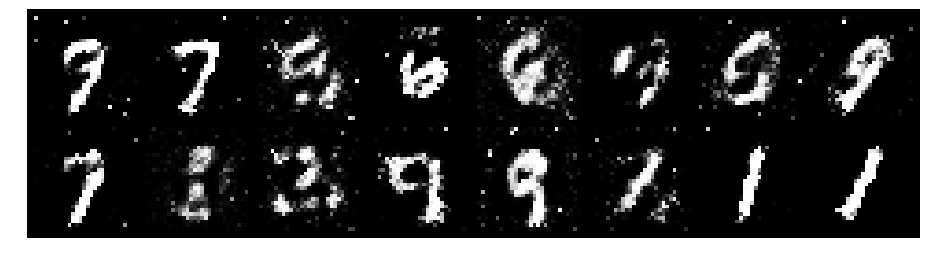

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 0.8734, Generator Loss: 1.4383
D(x): 0.6887, D(G(z)): 0.2794


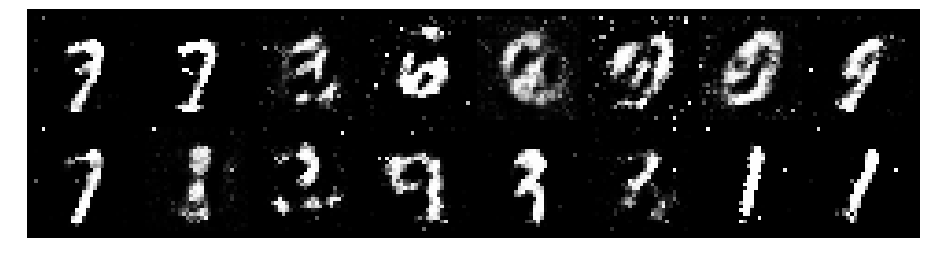

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 1.1013, Generator Loss: 1.6085
D(x): 0.6940, D(G(z)): 0.3855


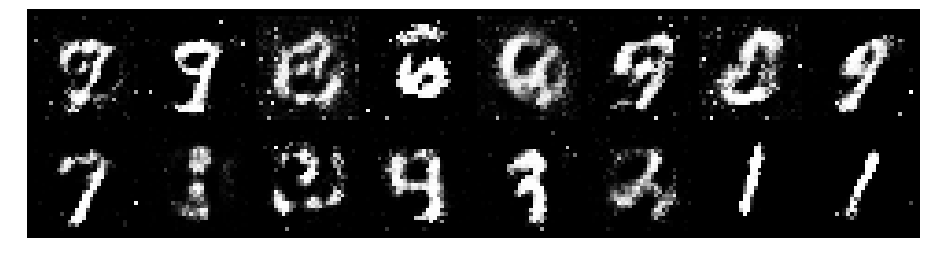

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 1.0186, Generator Loss: 1.4308
D(x): 0.6539, D(G(z)): 0.3299


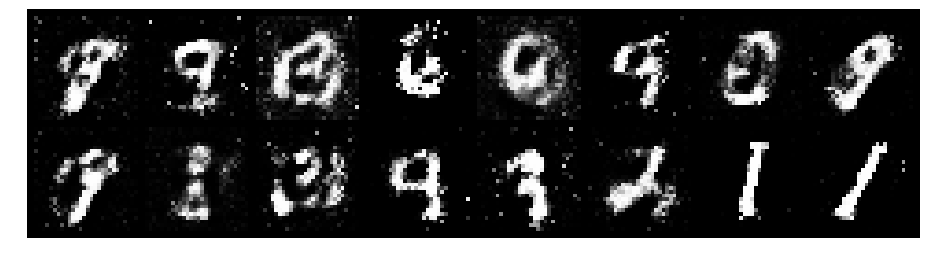

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 0.9800, Generator Loss: 1.7630
D(x): 0.6274, D(G(z)): 0.2717


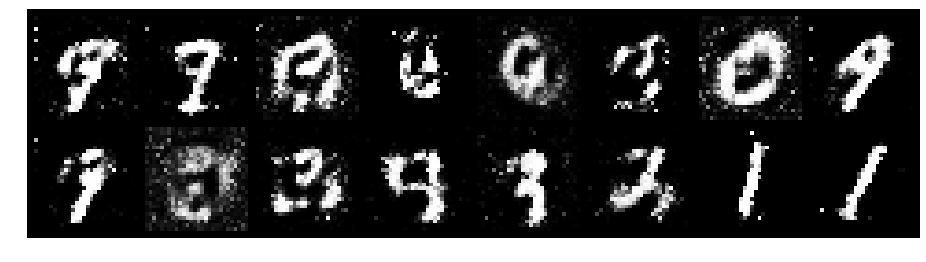

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 0.8548, Generator Loss: 1.4199
D(x): 0.8197, D(G(z)): 0.3723


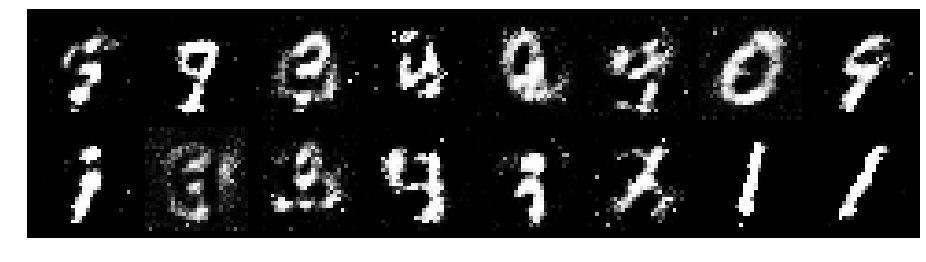

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 0.8909, Generator Loss: 1.9614
D(x): 0.7074, D(G(z)): 0.2919


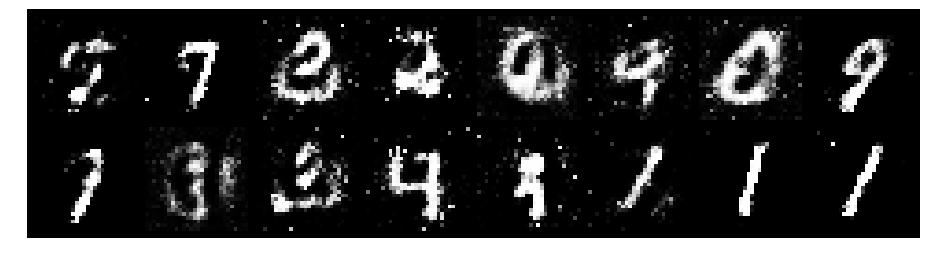

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.9465, Generator Loss: 1.4437
D(x): 0.6546, D(G(z)): 0.2880


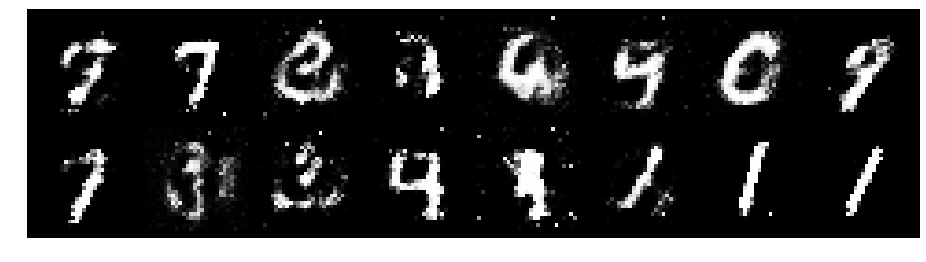

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 0.8761, Generator Loss: 1.5868
D(x): 0.6938, D(G(z)): 0.3195


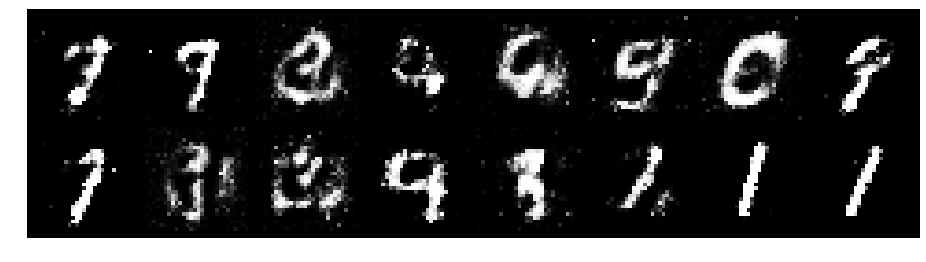

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 0.9849, Generator Loss: 1.4528
D(x): 0.6514, D(G(z)): 0.2942


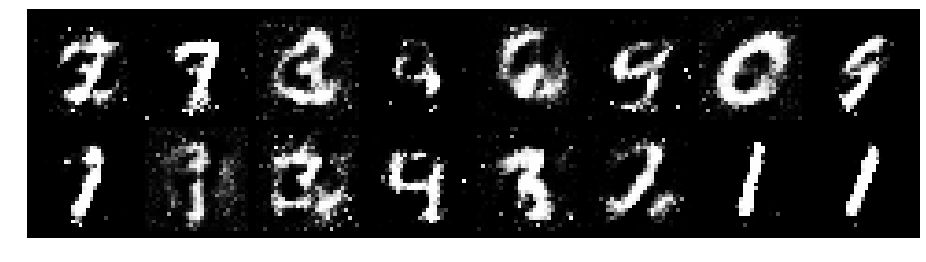

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 0.9686, Generator Loss: 1.6580
D(x): 0.7801, D(G(z)): 0.3524


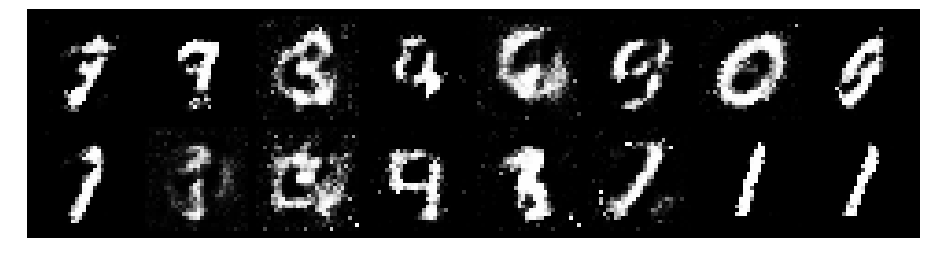

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 0.8251, Generator Loss: 1.3562
D(x): 0.7512, D(G(z)): 0.2986


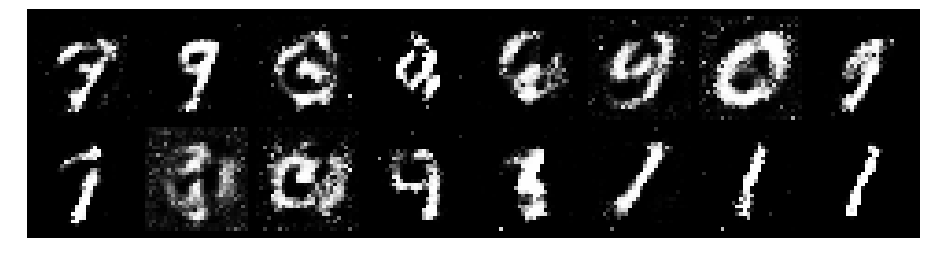

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 0.9910, Generator Loss: 1.4667
D(x): 0.7075, D(G(z)): 0.3602


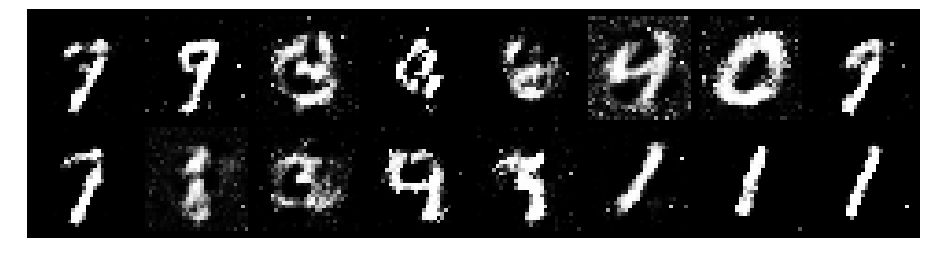

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 0.9943, Generator Loss: 1.2520
D(x): 0.6456, D(G(z)): 0.3337


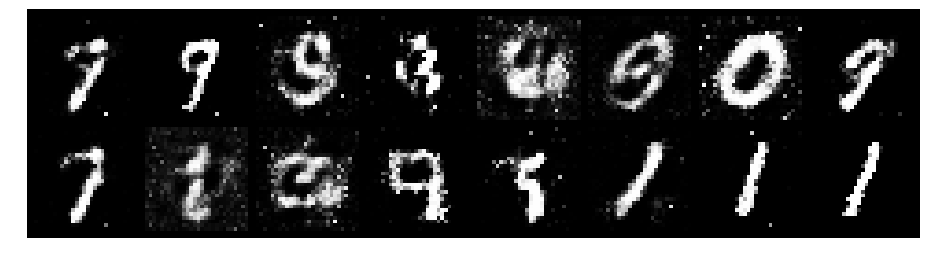

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 1.1684, Generator Loss: 1.1475
D(x): 0.5664, D(G(z)): 0.2976


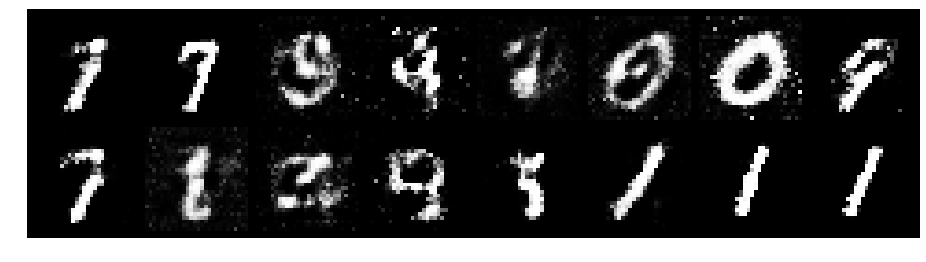

Epoch: [26/200], Batch Num: [200/600]
Discriminator Loss: 1.0809, Generator Loss: 1.5049
D(x): 0.6419, D(G(z)): 0.3064


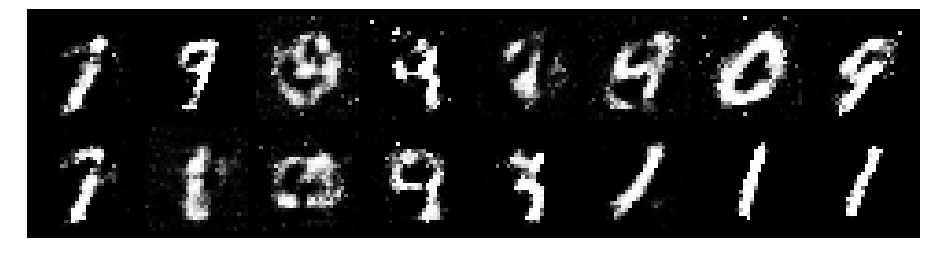

Epoch: [26/200], Batch Num: [300/600]
Discriminator Loss: 1.2398, Generator Loss: 1.2823
D(x): 0.6162, D(G(z)): 0.3670


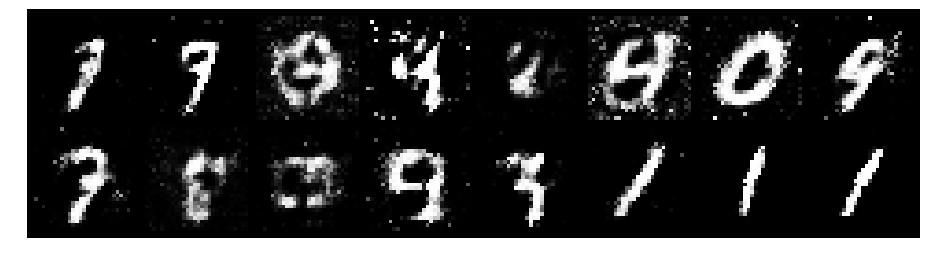

Epoch: [26/200], Batch Num: [400/600]
Discriminator Loss: 0.9643, Generator Loss: 1.6838
D(x): 0.6859, D(G(z)): 0.3108


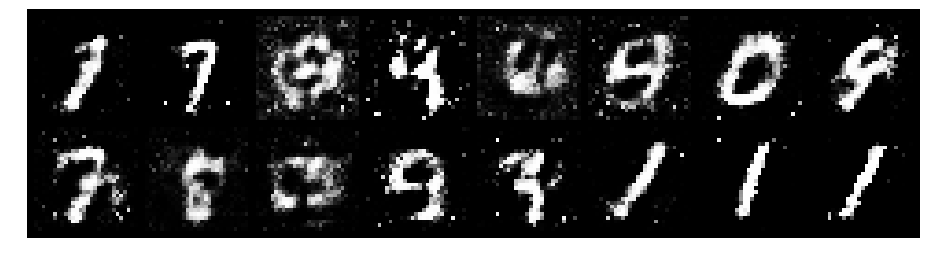

Epoch: [26/200], Batch Num: [500/600]
Discriminator Loss: 1.1183, Generator Loss: 1.1908
D(x): 0.5964, D(G(z)): 0.3267


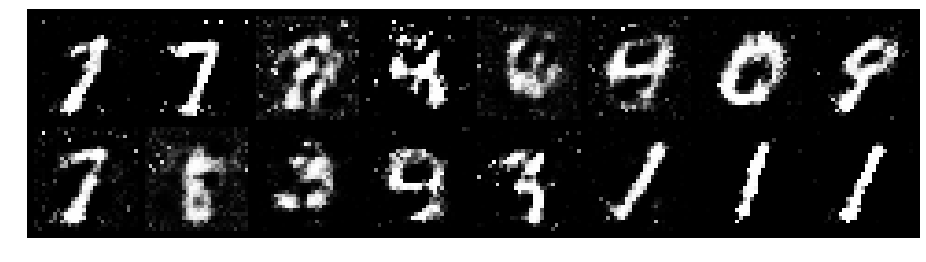

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 0.9159, Generator Loss: 1.5570
D(x): 0.7007, D(G(z)): 0.2878


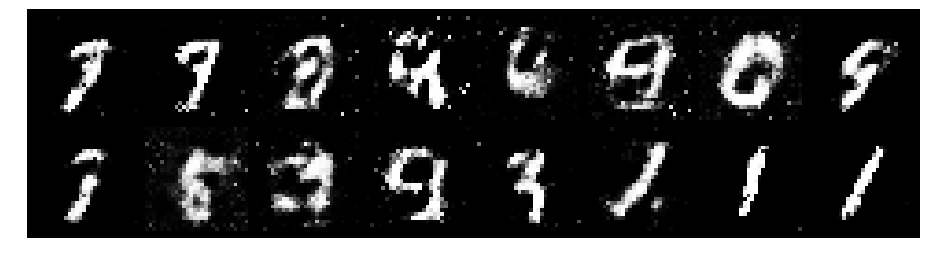

Epoch: [27/200], Batch Num: [100/600]
Discriminator Loss: 0.7314, Generator Loss: 1.7144
D(x): 0.8137, D(G(z)): 0.3077


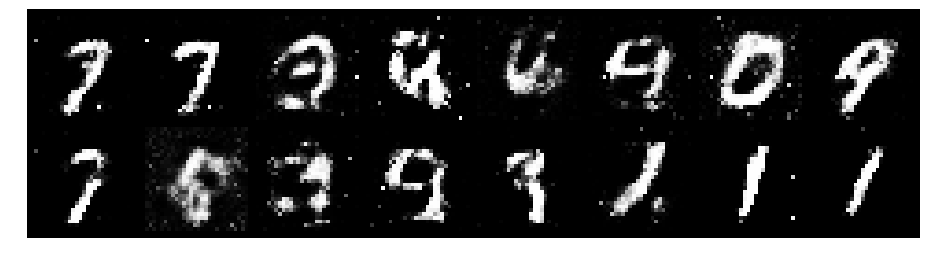

Epoch: [27/200], Batch Num: [200/600]
Discriminator Loss: 0.9408, Generator Loss: 1.2132
D(x): 0.7040, D(G(z)): 0.3507


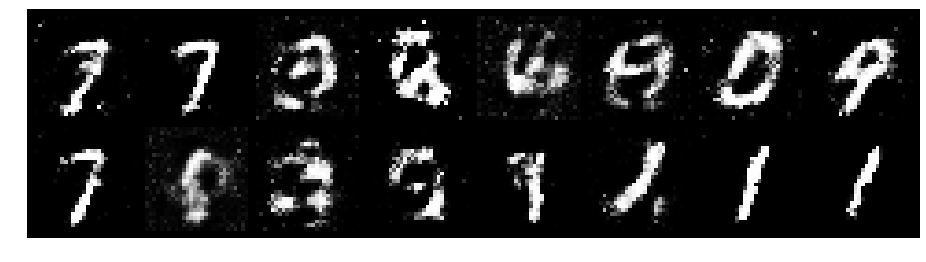

Epoch: [27/200], Batch Num: [300/600]
Discriminator Loss: 1.0664, Generator Loss: 1.2675
D(x): 0.6793, D(G(z)): 0.3854


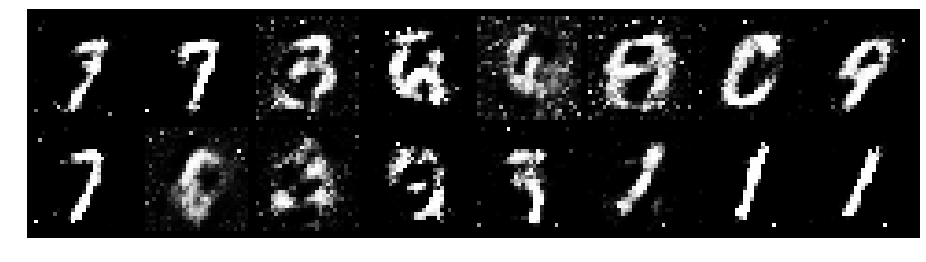

Epoch: [27/200], Batch Num: [400/600]
Discriminator Loss: 1.1377, Generator Loss: 1.1021
D(x): 0.5683, D(G(z)): 0.3694


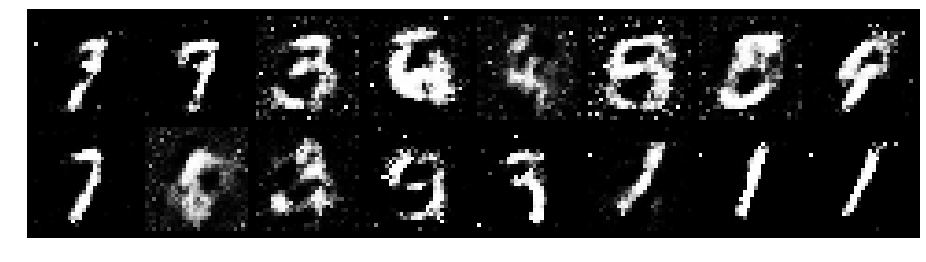

Epoch: [27/200], Batch Num: [500/600]
Discriminator Loss: 0.9064, Generator Loss: 1.3231
D(x): 0.6718, D(G(z)): 0.3064


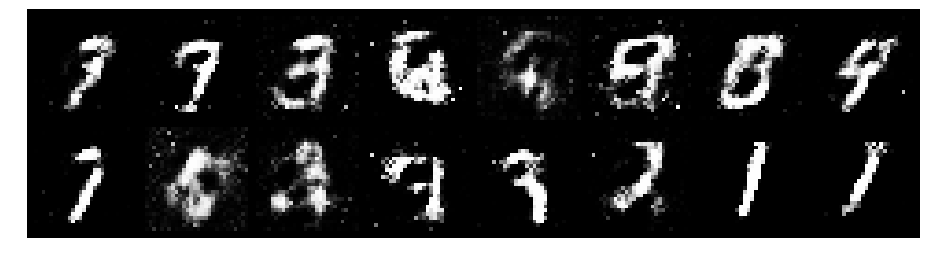

Epoch: [28/200], Batch Num: [0/600]
Discriminator Loss: 1.0090, Generator Loss: 1.2650
D(x): 0.6816, D(G(z)): 0.4009


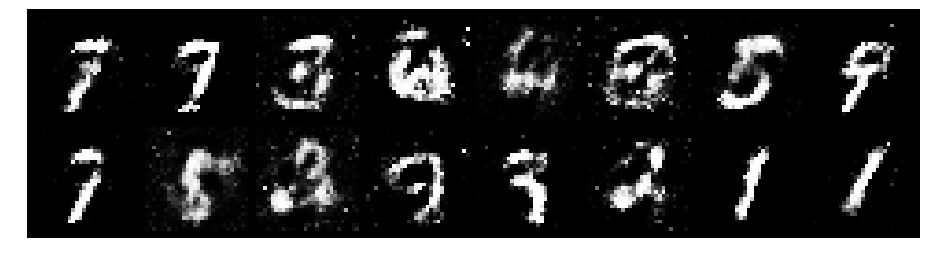

Epoch: [28/200], Batch Num: [100/600]
Discriminator Loss: 1.2152, Generator Loss: 1.2641
D(x): 0.5941, D(G(z)): 0.3707


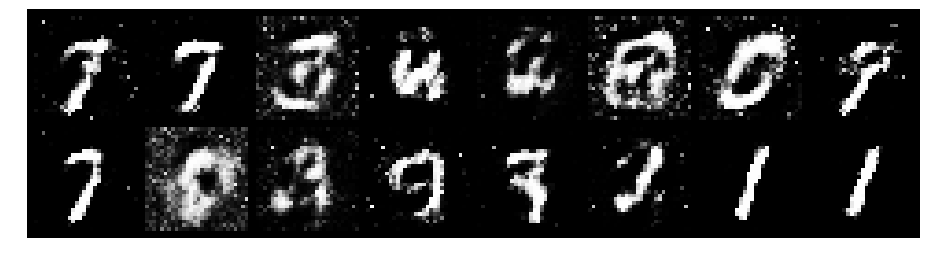

Epoch: [28/200], Batch Num: [200/600]
Discriminator Loss: 0.9794, Generator Loss: 1.4391
D(x): 0.6474, D(G(z)): 0.2798


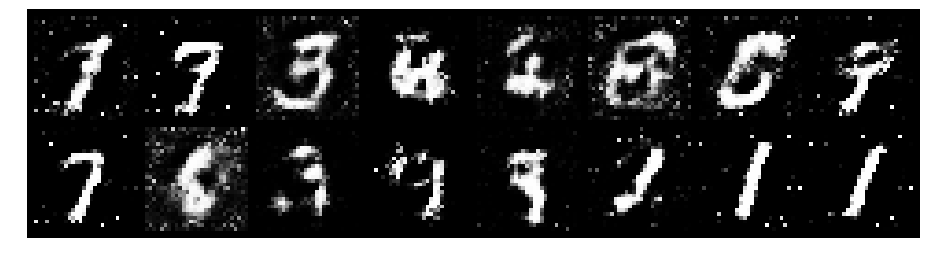

Epoch: [28/200], Batch Num: [300/600]
Discriminator Loss: 0.9364, Generator Loss: 1.5625
D(x): 0.7136, D(G(z)): 0.3269


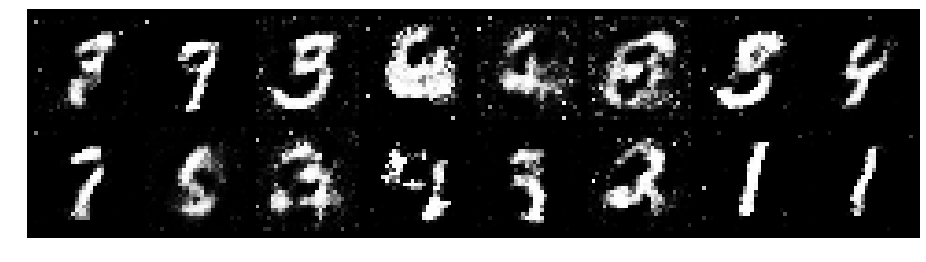

Epoch: [28/200], Batch Num: [400/600]
Discriminator Loss: 1.3504, Generator Loss: 1.4103
D(x): 0.5950, D(G(z)): 0.3870


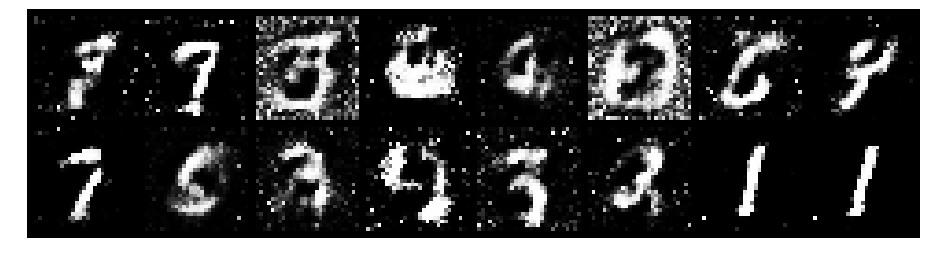

Epoch: [28/200], Batch Num: [500/600]
Discriminator Loss: 1.1330, Generator Loss: 1.6151
D(x): 0.6050, D(G(z)): 0.3290


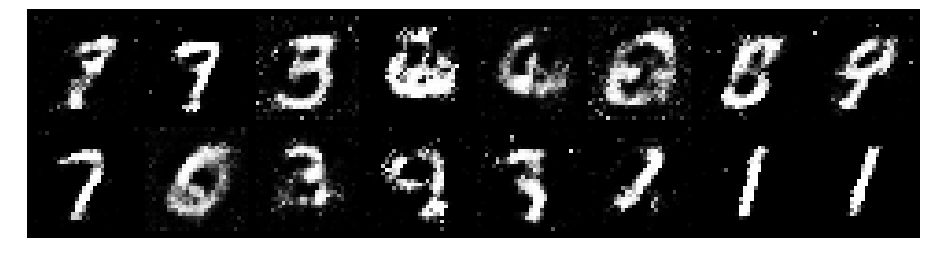

Epoch: [29/200], Batch Num: [0/600]
Discriminator Loss: 1.0407, Generator Loss: 1.1629
D(x): 0.6807, D(G(z)): 0.3908


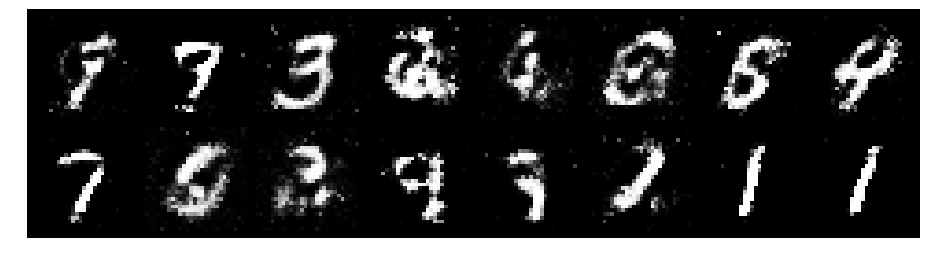

Epoch: [29/200], Batch Num: [100/600]
Discriminator Loss: 1.0554, Generator Loss: 1.3243
D(x): 0.6783, D(G(z)): 0.3430


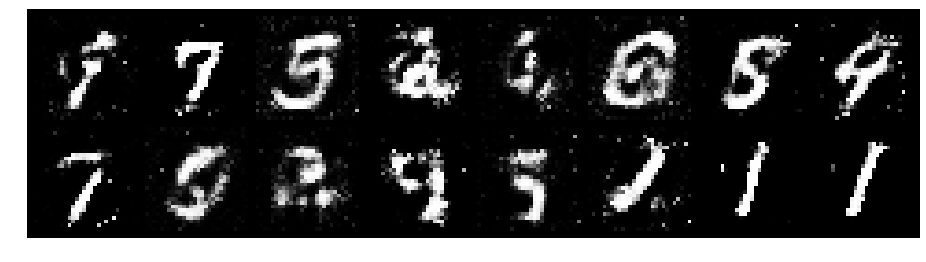

Epoch: [29/200], Batch Num: [200/600]
Discriminator Loss: 1.0703, Generator Loss: 1.2102
D(x): 0.6843, D(G(z)): 0.3584


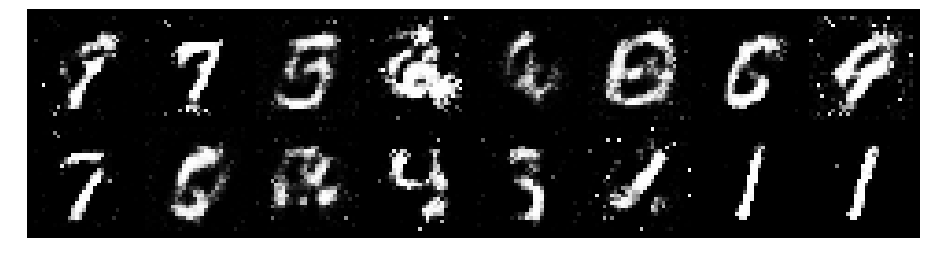

Epoch: [29/200], Batch Num: [300/600]
Discriminator Loss: 1.2113, Generator Loss: 1.0325
D(x): 0.6868, D(G(z)): 0.4400


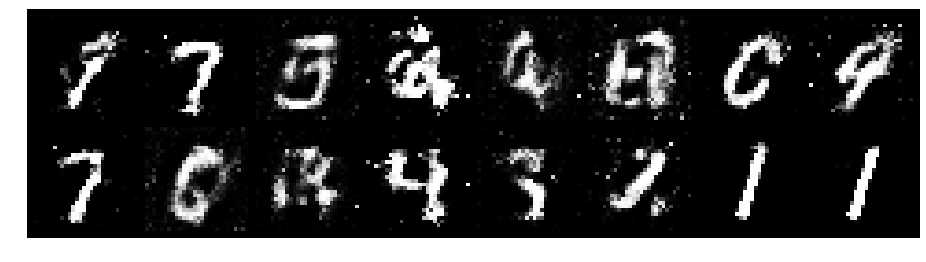

Epoch: [29/200], Batch Num: [400/600]
Discriminator Loss: 1.0735, Generator Loss: 1.3949
D(x): 0.7066, D(G(z)): 0.3818


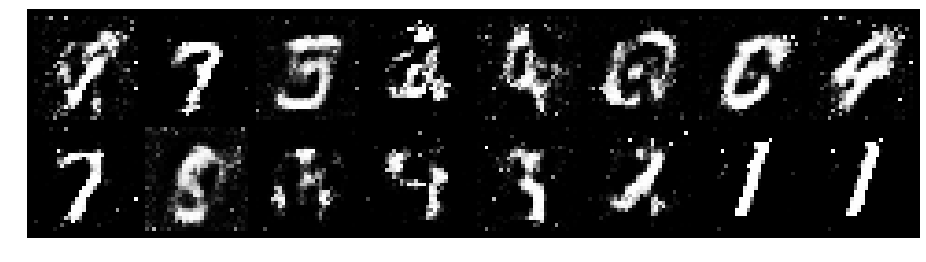

Epoch: [29/200], Batch Num: [500/600]
Discriminator Loss: 0.8143, Generator Loss: 1.6879
D(x): 0.7203, D(G(z)): 0.2795


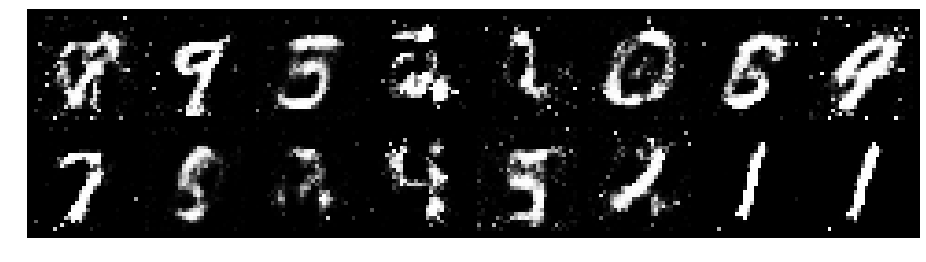

Epoch: [30/200], Batch Num: [0/600]
Discriminator Loss: 1.1895, Generator Loss: 1.0589
D(x): 0.6323, D(G(z)): 0.4084


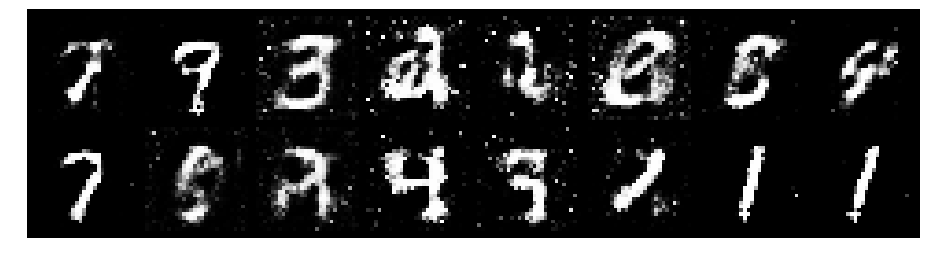

Epoch: [30/200], Batch Num: [100/600]
Discriminator Loss: 0.9296, Generator Loss: 1.1645
D(x): 0.7768, D(G(z)): 0.3913


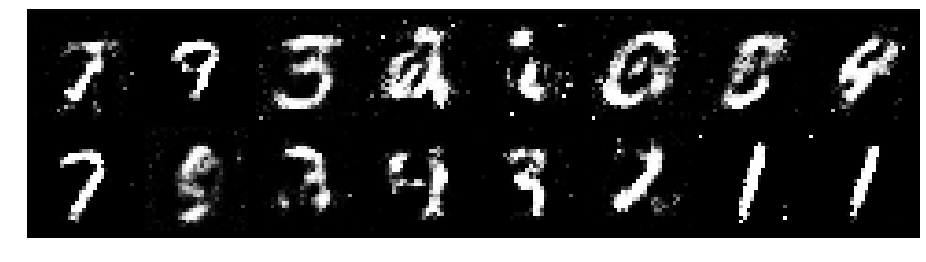

Epoch: [30/200], Batch Num: [200/600]
Discriminator Loss: 1.1776, Generator Loss: 1.1114
D(x): 0.7435, D(G(z)): 0.4689


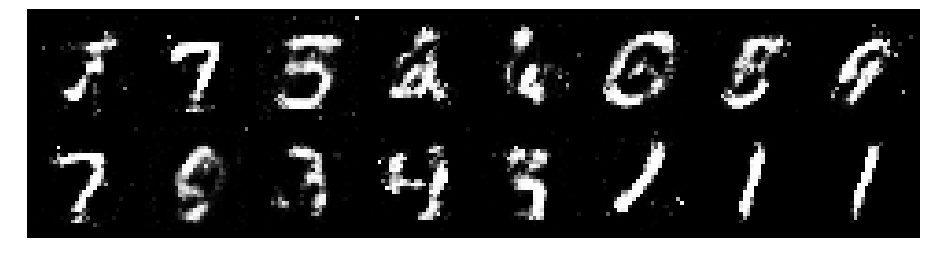

Epoch: [30/200], Batch Num: [300/600]
Discriminator Loss: 1.0208, Generator Loss: 1.3018
D(x): 0.6427, D(G(z)): 0.3654


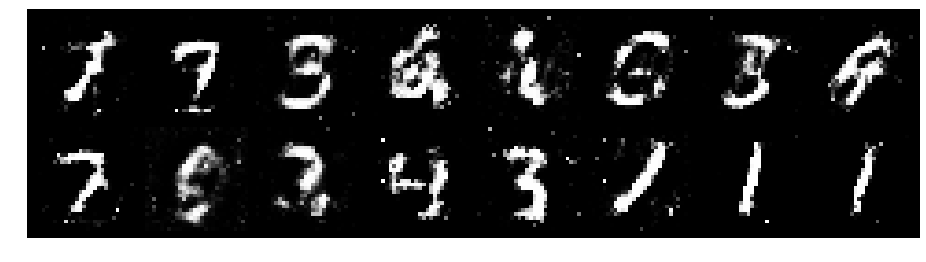

Epoch: [30/200], Batch Num: [400/600]
Discriminator Loss: 0.9001, Generator Loss: 1.7207
D(x): 0.6972, D(G(z)): 0.3005


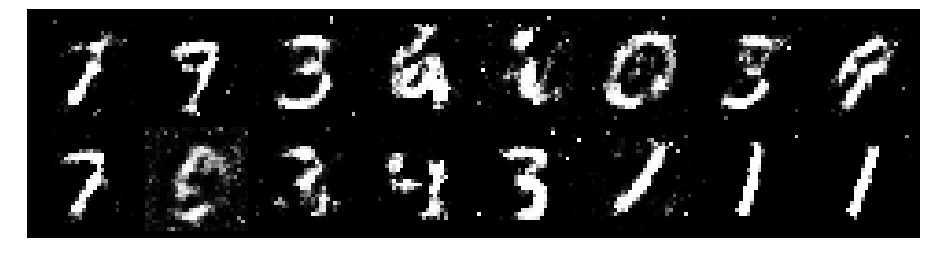

Epoch: [30/200], Batch Num: [500/600]
Discriminator Loss: 0.9362, Generator Loss: 1.5187
D(x): 0.6758, D(G(z)): 0.2769


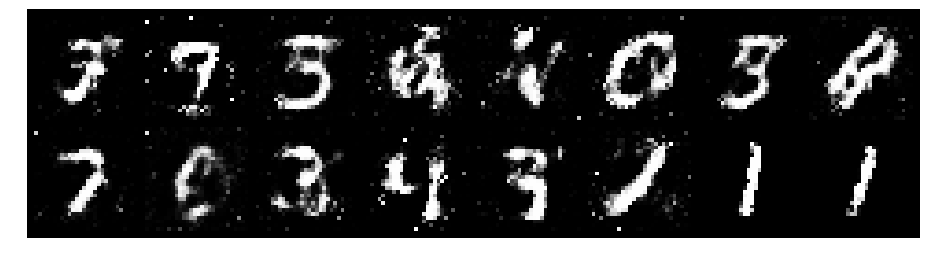

Epoch: [31/200], Batch Num: [0/600]
Discriminator Loss: 1.1413, Generator Loss: 1.4788
D(x): 0.6438, D(G(z)): 0.3002


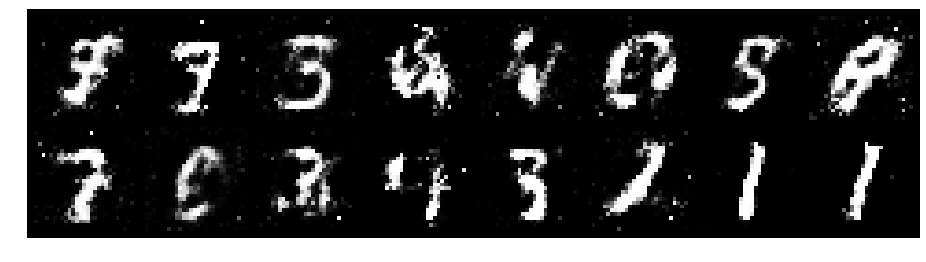

Epoch: [31/200], Batch Num: [100/600]
Discriminator Loss: 0.8976, Generator Loss: 1.4705
D(x): 0.7375, D(G(z)): 0.3480


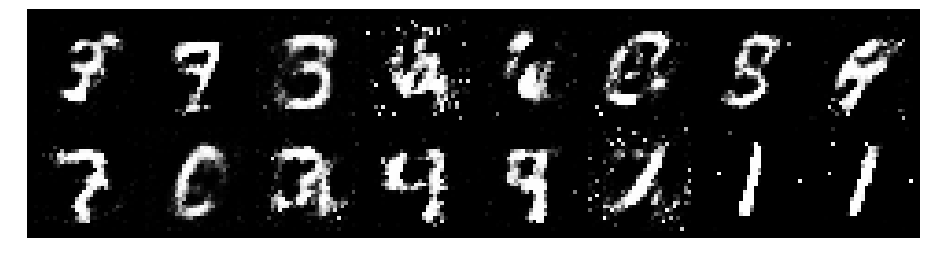

Epoch: [31/200], Batch Num: [200/600]
Discriminator Loss: 0.7744, Generator Loss: 1.7138
D(x): 0.7647, D(G(z)): 0.3152


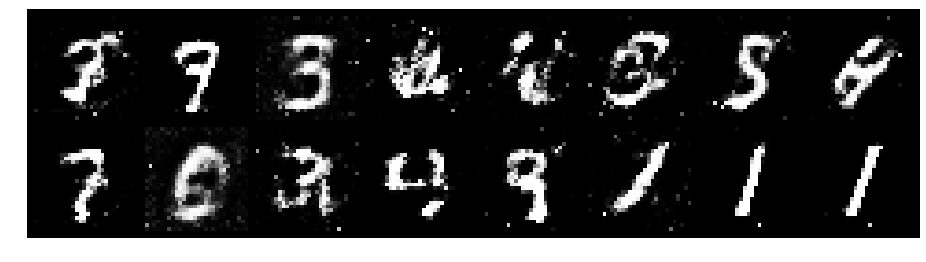

Epoch: [31/200], Batch Num: [300/600]
Discriminator Loss: 0.9777, Generator Loss: 1.2960
D(x): 0.7141, D(G(z)): 0.3635


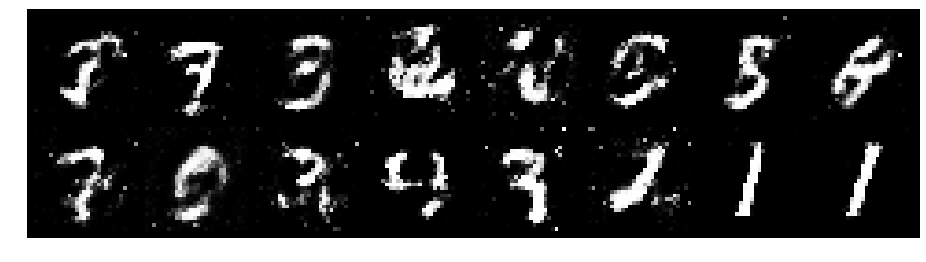

Epoch: [31/200], Batch Num: [400/600]
Discriminator Loss: 0.9731, Generator Loss: 1.1356
D(x): 0.7215, D(G(z)): 0.3929


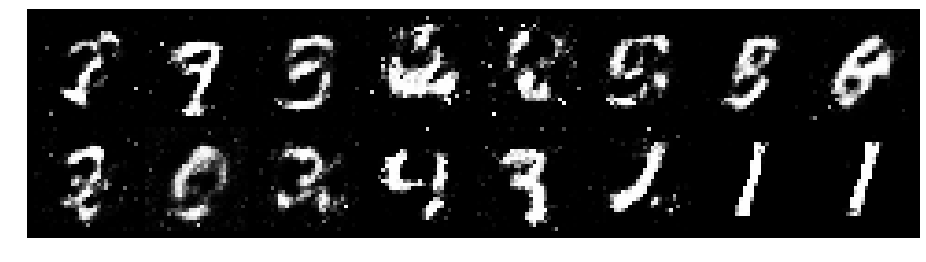

Epoch: [31/200], Batch Num: [500/600]
Discriminator Loss: 0.8991, Generator Loss: 1.4815
D(x): 0.6705, D(G(z)): 0.3018


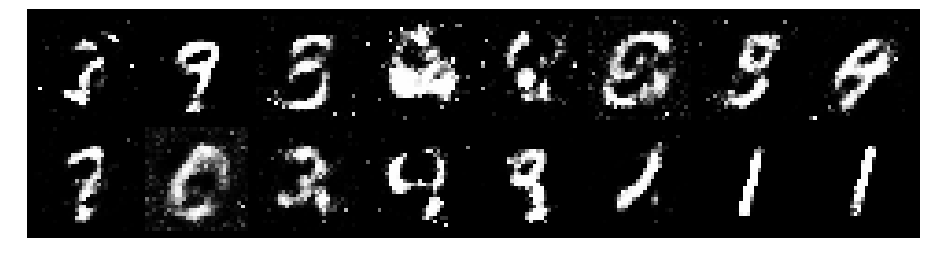

Epoch: [32/200], Batch Num: [0/600]
Discriminator Loss: 0.8666, Generator Loss: 1.4078
D(x): 0.6740, D(G(z)): 0.2967


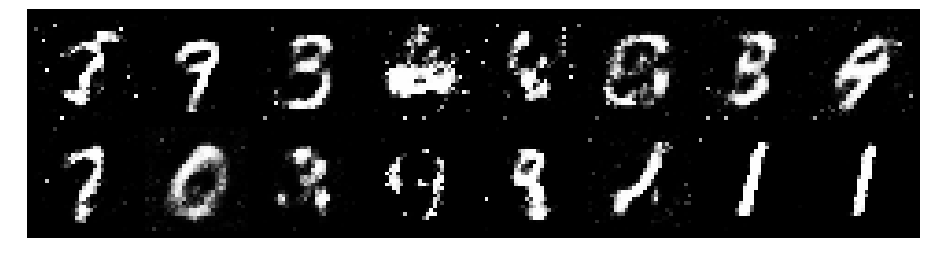

Epoch: [32/200], Batch Num: [100/600]
Discriminator Loss: 0.7689, Generator Loss: 1.7638
D(x): 0.7192, D(G(z)): 0.2538


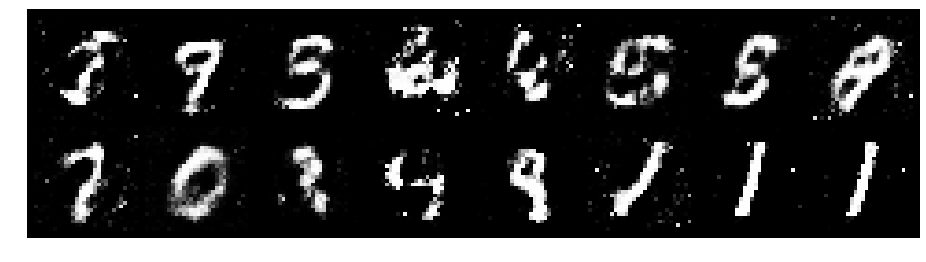

Epoch: [32/200], Batch Num: [200/600]
Discriminator Loss: 0.7858, Generator Loss: 1.7368
D(x): 0.7018, D(G(z)): 0.2521


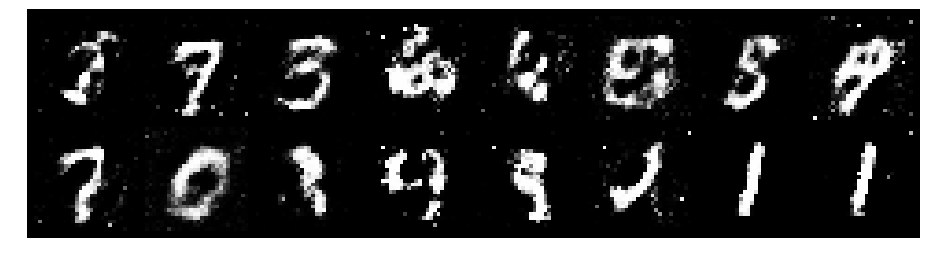

Epoch: [32/200], Batch Num: [300/600]
Discriminator Loss: 1.1400, Generator Loss: 1.3726
D(x): 0.6082, D(G(z)): 0.3585


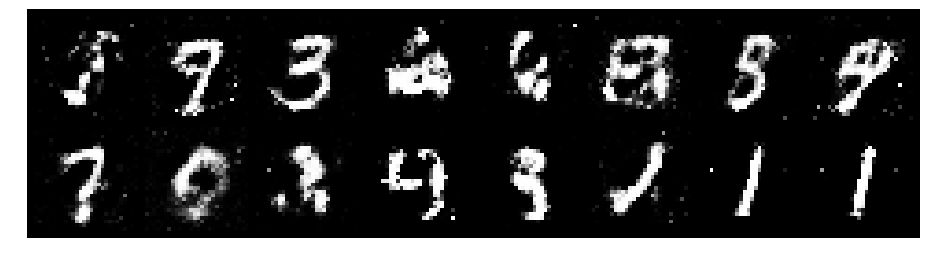

Epoch: [32/200], Batch Num: [400/600]
Discriminator Loss: 0.8850, Generator Loss: 1.3866
D(x): 0.6569, D(G(z)): 0.2745


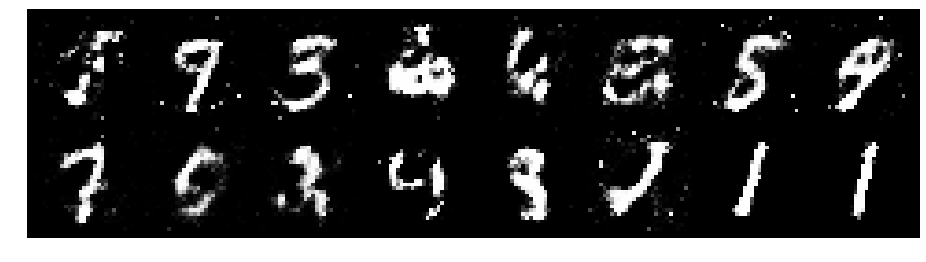

Epoch: [32/200], Batch Num: [500/600]
Discriminator Loss: 0.8631, Generator Loss: 1.4425
D(x): 0.7064, D(G(z)): 0.3266


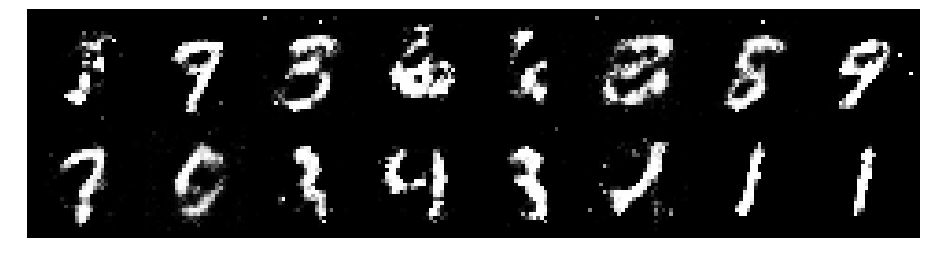

Epoch: [33/200], Batch Num: [0/600]
Discriminator Loss: 0.8269, Generator Loss: 1.4068
D(x): 0.7344, D(G(z)): 0.3160


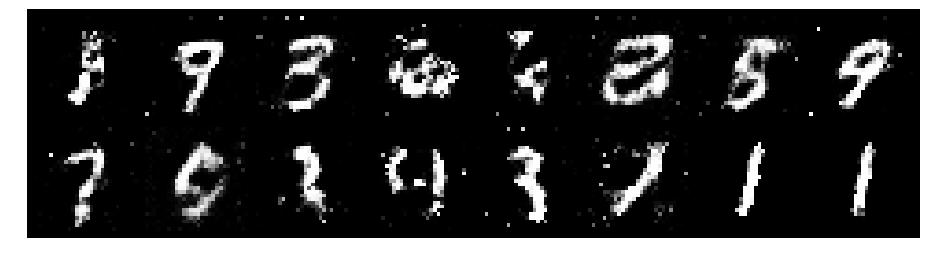

Epoch: [33/200], Batch Num: [100/600]
Discriminator Loss: 1.0923, Generator Loss: 1.1008
D(x): 0.6374, D(G(z)): 0.3748


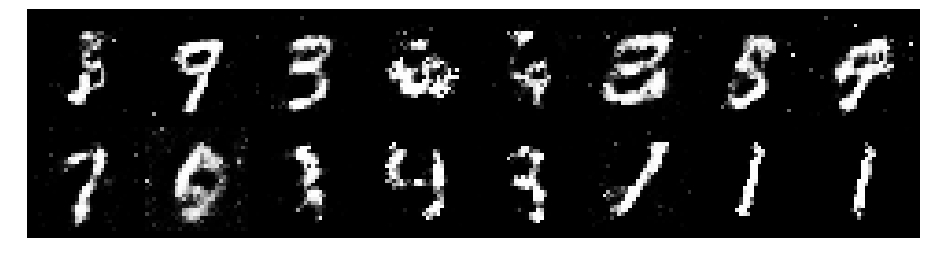

Epoch: [33/200], Batch Num: [200/600]
Discriminator Loss: 1.0957, Generator Loss: 1.2636
D(x): 0.6672, D(G(z)): 0.4002


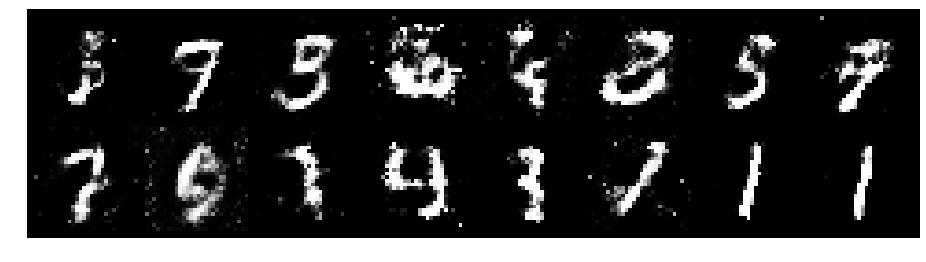

Epoch: [33/200], Batch Num: [300/600]
Discriminator Loss: 0.8997, Generator Loss: 1.1525
D(x): 0.7435, D(G(z)): 0.3624


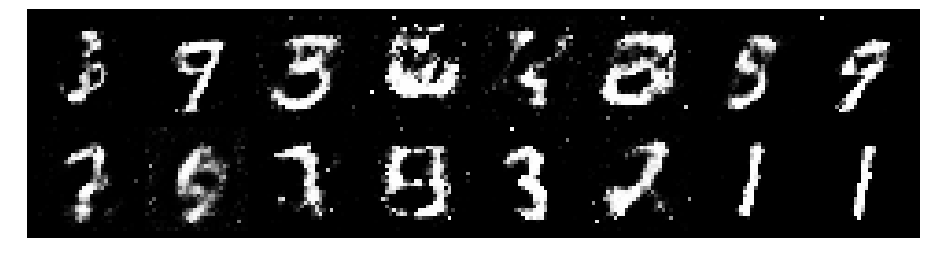

Epoch: [33/200], Batch Num: [400/600]
Discriminator Loss: 1.0836, Generator Loss: 1.2969
D(x): 0.6670, D(G(z)): 0.3704


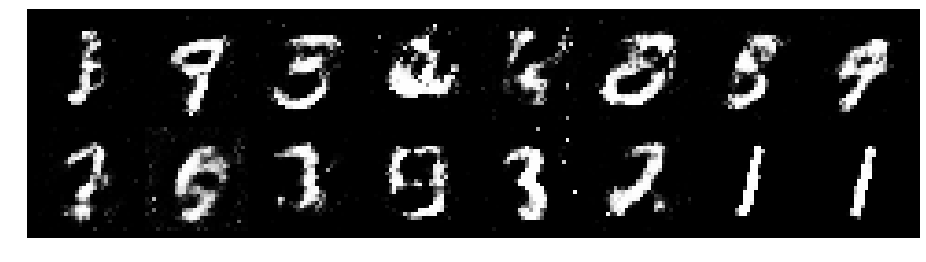

Epoch: [33/200], Batch Num: [500/600]
Discriminator Loss: 1.0775, Generator Loss: 1.3808
D(x): 0.6176, D(G(z)): 0.3254


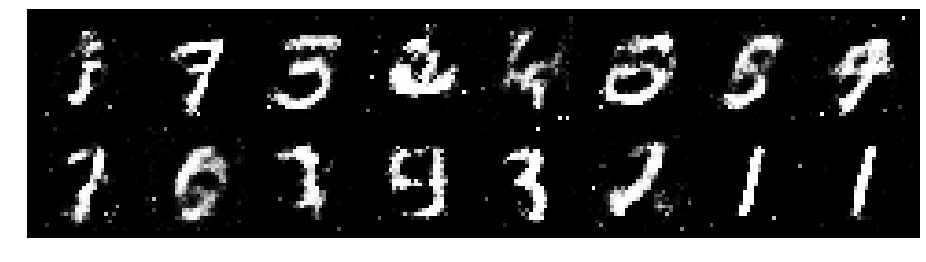

Epoch: [34/200], Batch Num: [0/600]
Discriminator Loss: 1.0245, Generator Loss: 0.9068
D(x): 0.6960, D(G(z)): 0.4097


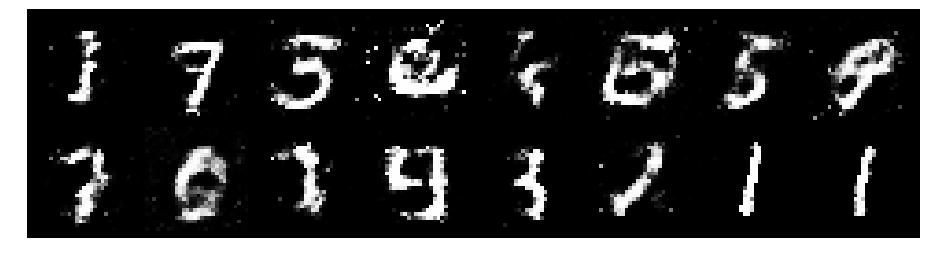

Epoch: [34/200], Batch Num: [100/600]
Discriminator Loss: 1.0245, Generator Loss: 1.2664
D(x): 0.6608, D(G(z)): 0.3753


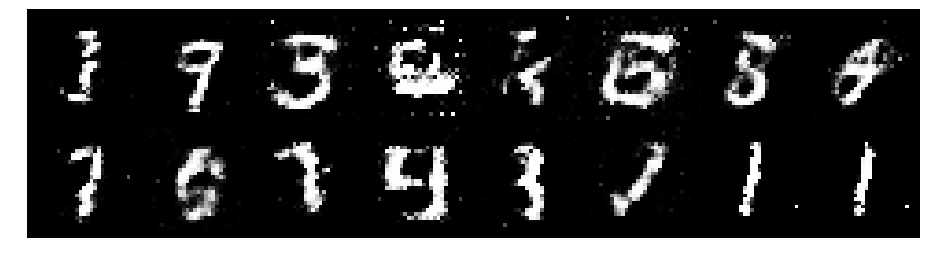

Epoch: [34/200], Batch Num: [200/600]
Discriminator Loss: 1.1391, Generator Loss: 1.1183
D(x): 0.6488, D(G(z)): 0.4068


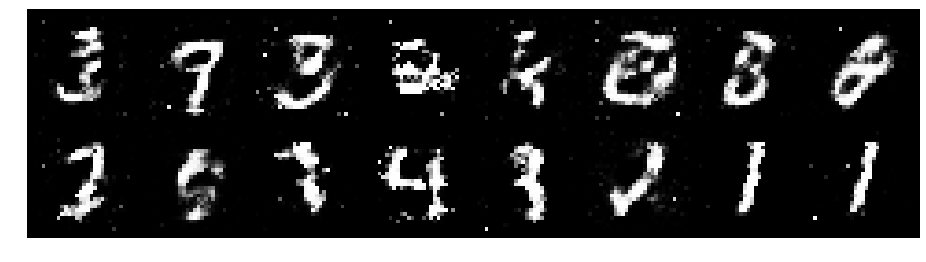

Epoch: [34/200], Batch Num: [300/600]
Discriminator Loss: 0.9344, Generator Loss: 1.5006
D(x): 0.6472, D(G(z)): 0.2844


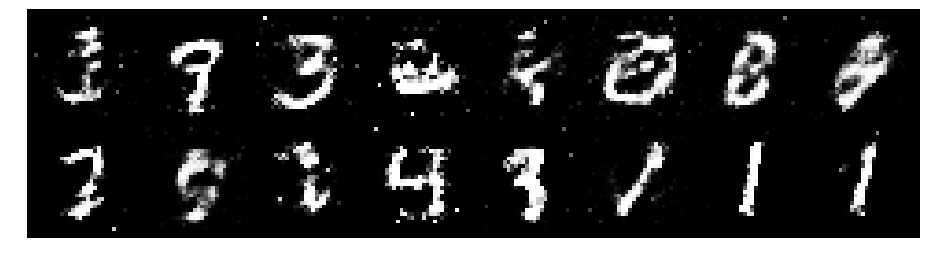

Epoch: [34/200], Batch Num: [400/600]
Discriminator Loss: 1.1128, Generator Loss: 1.9609
D(x): 0.5886, D(G(z)): 0.2629


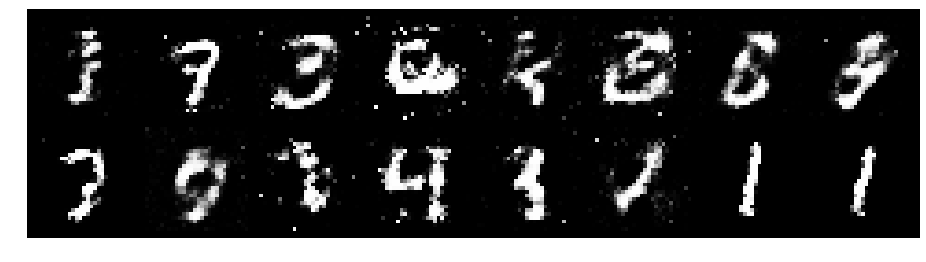

Epoch: [34/200], Batch Num: [500/600]
Discriminator Loss: 1.1361, Generator Loss: 1.1335
D(x): 0.6837, D(G(z)): 0.4112


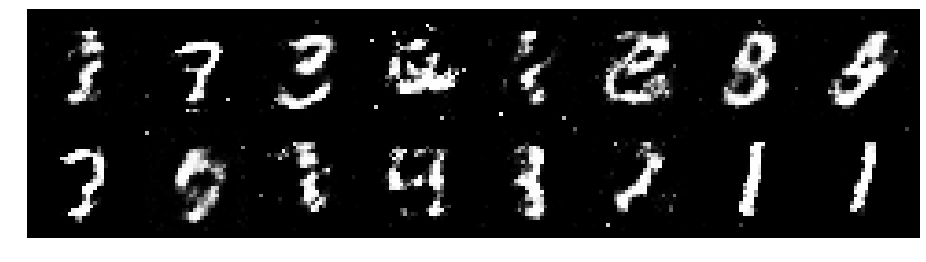

Epoch: [35/200], Batch Num: [0/600]
Discriminator Loss: 1.1490, Generator Loss: 1.3529
D(x): 0.6197, D(G(z)): 0.3621


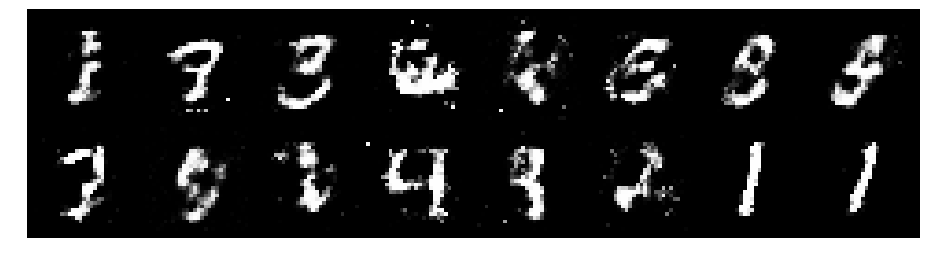

Epoch: [35/200], Batch Num: [100/600]
Discriminator Loss: 1.1017, Generator Loss: 1.2127
D(x): 0.6458, D(G(z)): 0.3576


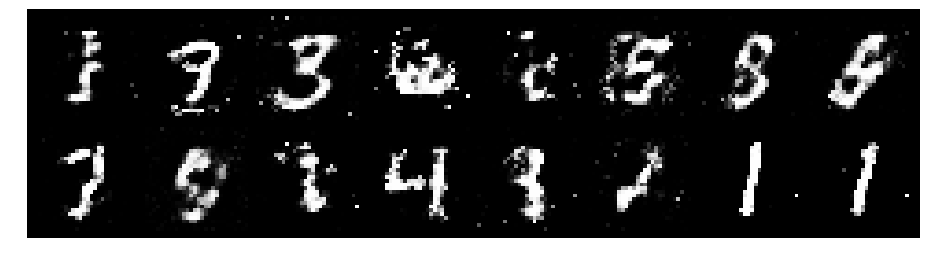

Epoch: [35/200], Batch Num: [200/600]
Discriminator Loss: 1.1859, Generator Loss: 1.0716
D(x): 0.6716, D(G(z)): 0.4506


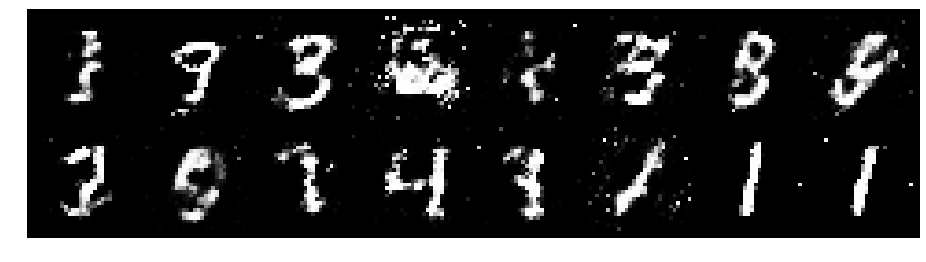

Epoch: [35/200], Batch Num: [300/600]
Discriminator Loss: 0.9728, Generator Loss: 1.6975
D(x): 0.6702, D(G(z)): 0.3195


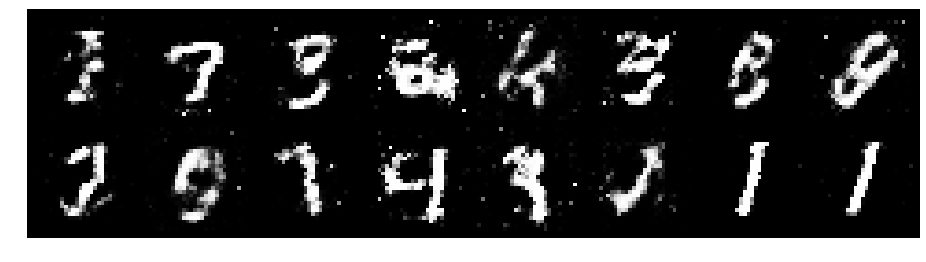

Epoch: [35/200], Batch Num: [400/600]
Discriminator Loss: 1.0885, Generator Loss: 1.4016
D(x): 0.6084, D(G(z)): 0.3165


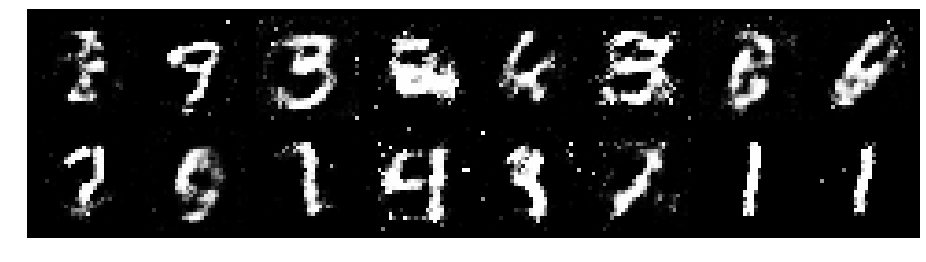

Epoch: [35/200], Batch Num: [500/600]
Discriminator Loss: 0.9860, Generator Loss: 1.3963
D(x): 0.6324, D(G(z)): 0.3472


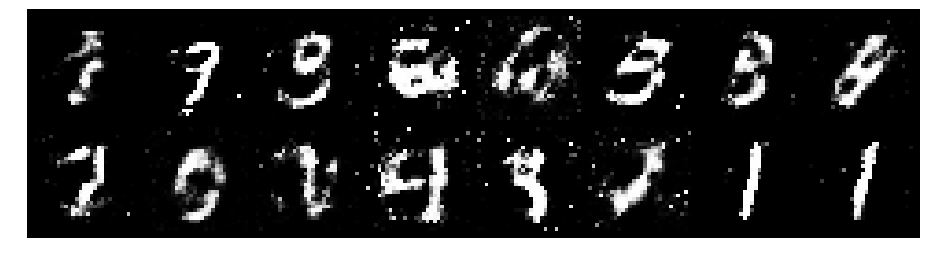

Epoch: [36/200], Batch Num: [0/600]
Discriminator Loss: 1.0608, Generator Loss: 1.3945
D(x): 0.6139, D(G(z)): 0.3295


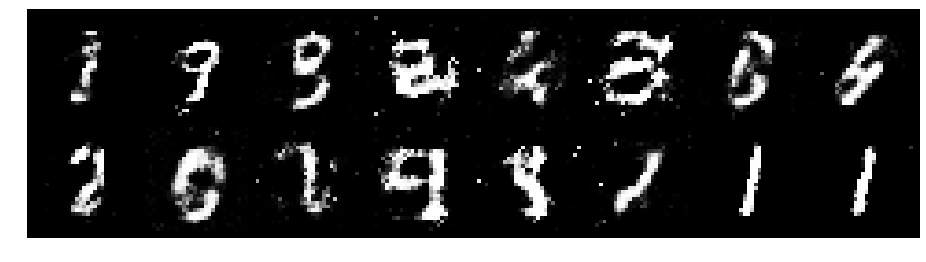

Epoch: [36/200], Batch Num: [100/600]
Discriminator Loss: 1.0386, Generator Loss: 1.2232
D(x): 0.6320, D(G(z)): 0.3291


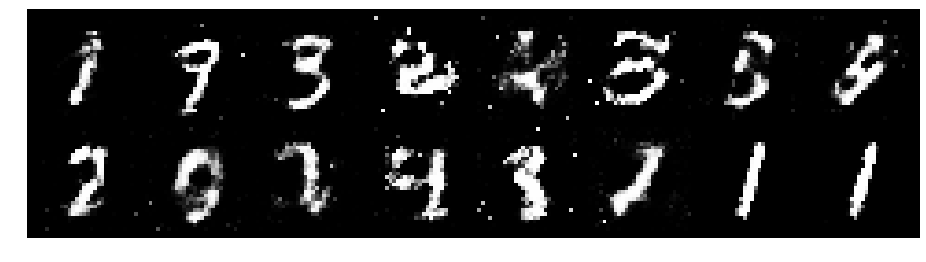

Epoch: [36/200], Batch Num: [200/600]
Discriminator Loss: 0.9875, Generator Loss: 1.3640
D(x): 0.6899, D(G(z)): 0.3541


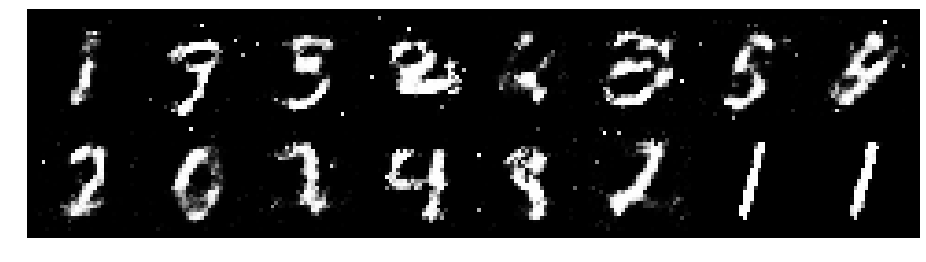

Epoch: [36/200], Batch Num: [300/600]
Discriminator Loss: 1.3066, Generator Loss: 1.1815
D(x): 0.5752, D(G(z)): 0.4028


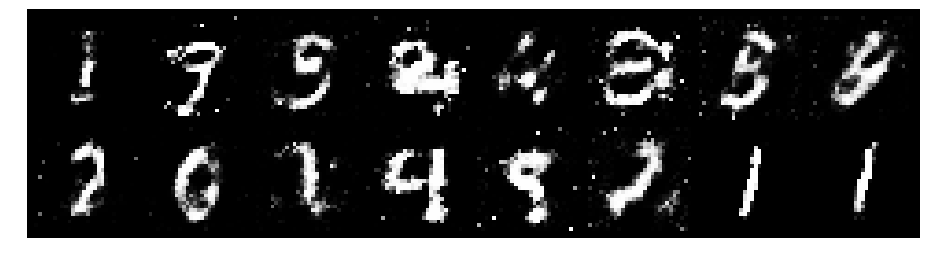

Epoch: [36/200], Batch Num: [400/600]
Discriminator Loss: 1.1186, Generator Loss: 1.2714
D(x): 0.6898, D(G(z)): 0.3655


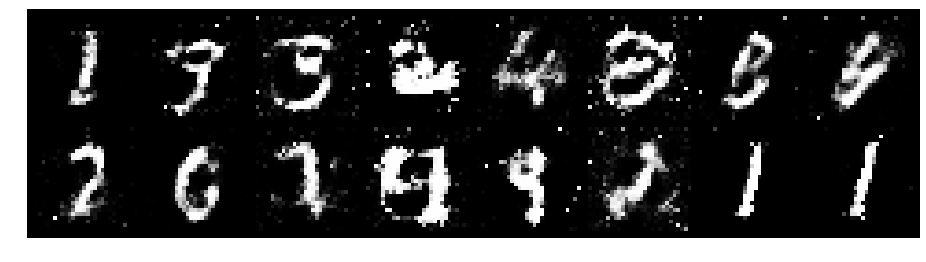

Epoch: [36/200], Batch Num: [500/600]
Discriminator Loss: 1.2888, Generator Loss: 1.1055
D(x): 0.6493, D(G(z)): 0.4587


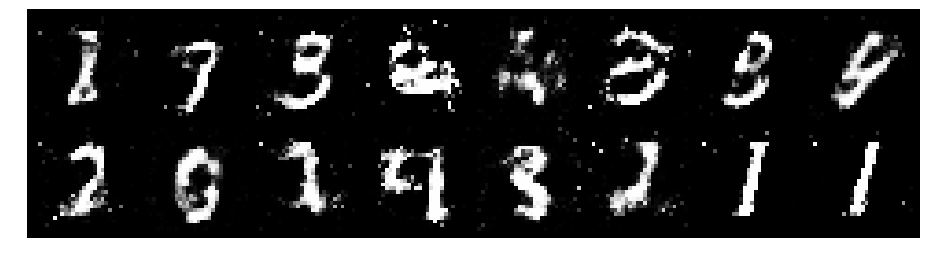

Epoch: [37/200], Batch Num: [0/600]
Discriminator Loss: 1.0888, Generator Loss: 1.1164
D(x): 0.6794, D(G(z)): 0.4159


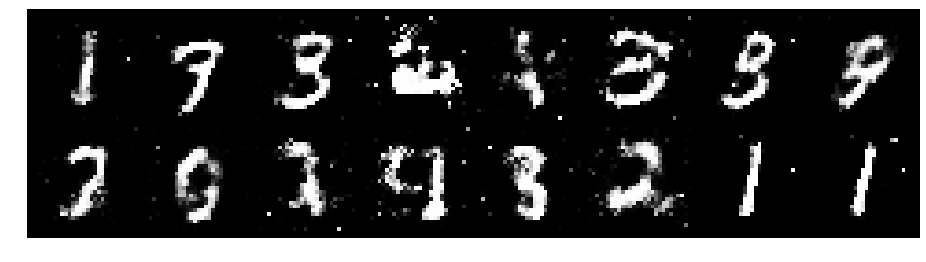

Epoch: [37/200], Batch Num: [100/600]
Discriminator Loss: 1.0318, Generator Loss: 1.1769
D(x): 0.6454, D(G(z)): 0.3365


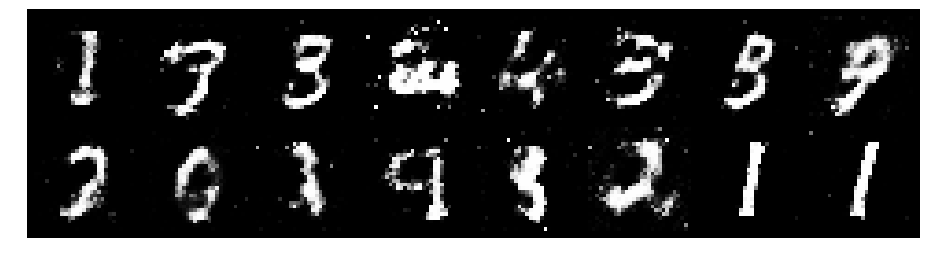

Epoch: [37/200], Batch Num: [200/600]
Discriminator Loss: 1.0935, Generator Loss: 1.0795
D(x): 0.6507, D(G(z)): 0.4015


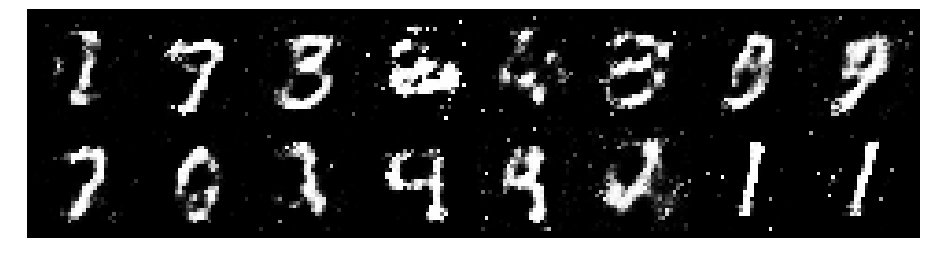

Epoch: [37/200], Batch Num: [300/600]
Discriminator Loss: 1.1111, Generator Loss: 0.9939
D(x): 0.6222, D(G(z)): 0.4076


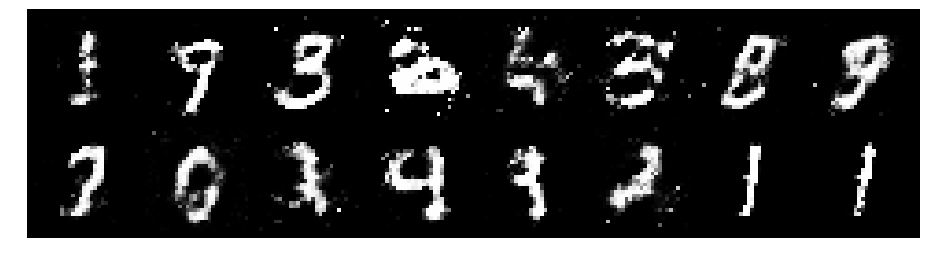

Epoch: [37/200], Batch Num: [400/600]
Discriminator Loss: 1.1236, Generator Loss: 1.3422
D(x): 0.6047, D(G(z)): 0.3573


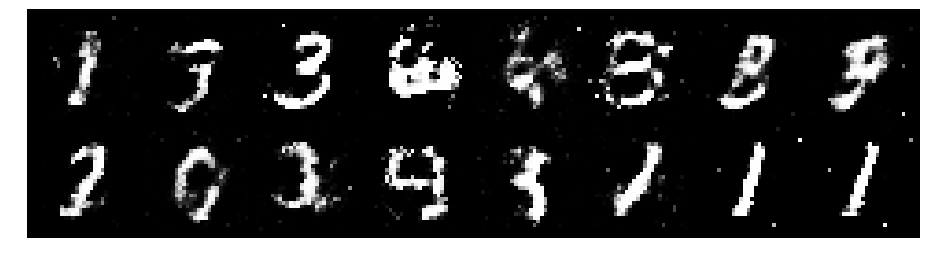

Epoch: [37/200], Batch Num: [500/600]
Discriminator Loss: 1.0461, Generator Loss: 0.8769
D(x): 0.6909, D(G(z)): 0.4462


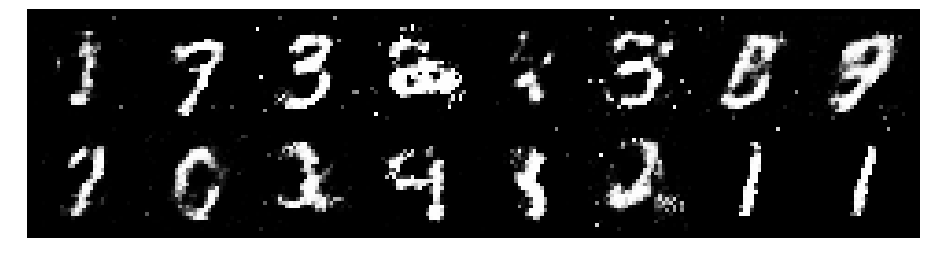

Epoch: [38/200], Batch Num: [0/600]
Discriminator Loss: 0.9266, Generator Loss: 1.2262
D(x): 0.7272, D(G(z)): 0.3752


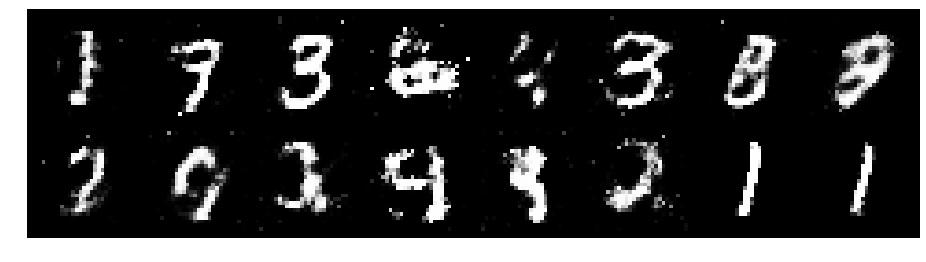

Epoch: [38/200], Batch Num: [100/600]
Discriminator Loss: 1.3465, Generator Loss: 1.3336
D(x): 0.5914, D(G(z)): 0.3921


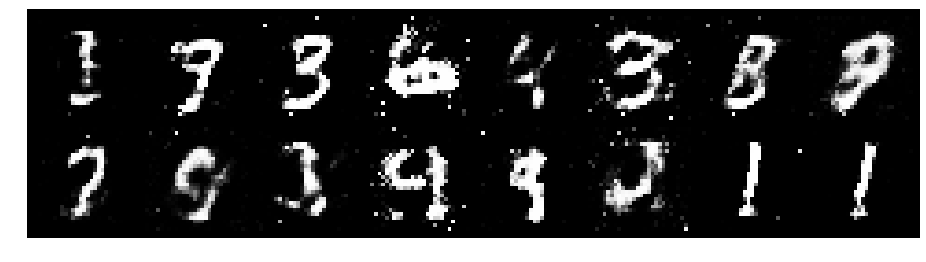

Epoch: [38/200], Batch Num: [200/600]
Discriminator Loss: 1.0447, Generator Loss: 1.4307
D(x): 0.7674, D(G(z)): 0.4554


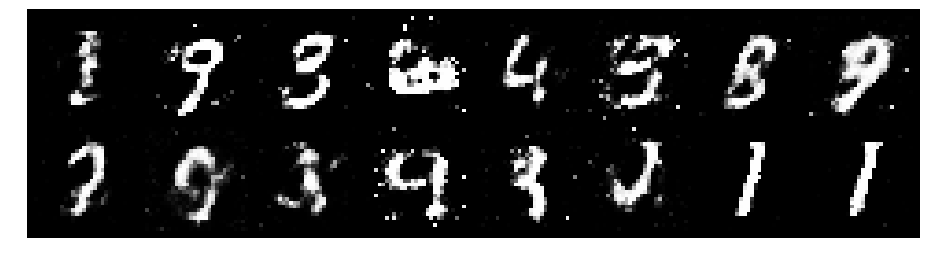

Epoch: [38/200], Batch Num: [300/600]
Discriminator Loss: 1.2973, Generator Loss: 1.5046
D(x): 0.5559, D(G(z)): 0.3640


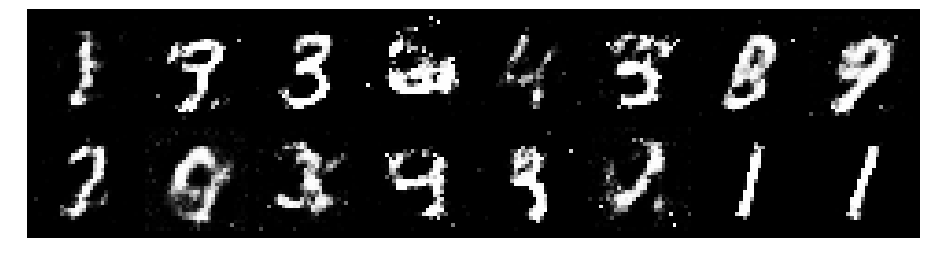

Epoch: [38/200], Batch Num: [400/600]
Discriminator Loss: 1.1234, Generator Loss: 1.0662
D(x): 0.6419, D(G(z)): 0.4111


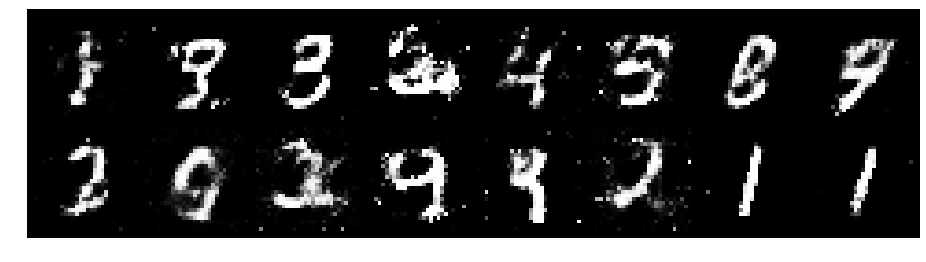

Epoch: [38/200], Batch Num: [500/600]
Discriminator Loss: 1.0344, Generator Loss: 1.1792
D(x): 0.6175, D(G(z)): 0.3558


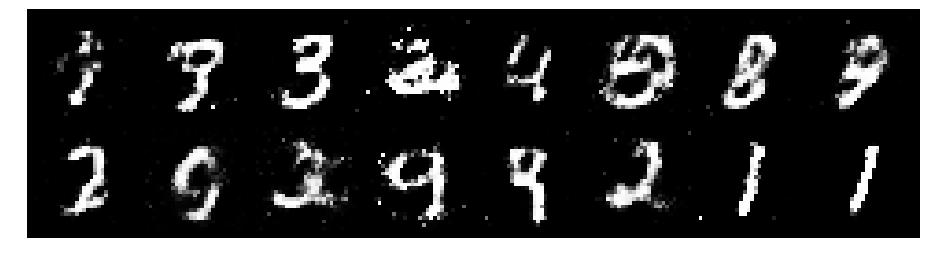

Epoch: [39/200], Batch Num: [0/600]
Discriminator Loss: 1.1486, Generator Loss: 1.0639
D(x): 0.6303, D(G(z)): 0.3941


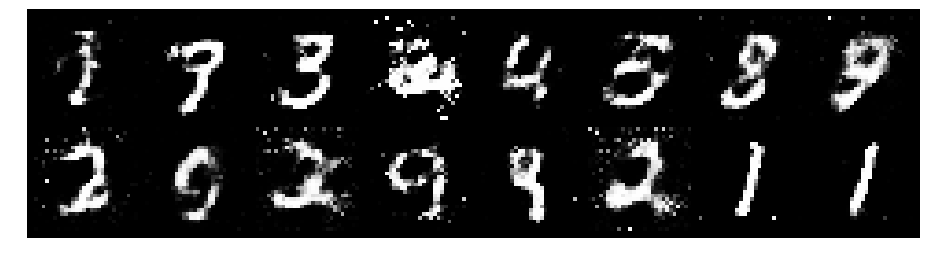

Epoch: [39/200], Batch Num: [100/600]
Discriminator Loss: 1.2447, Generator Loss: 1.2238
D(x): 0.6088, D(G(z)): 0.4281


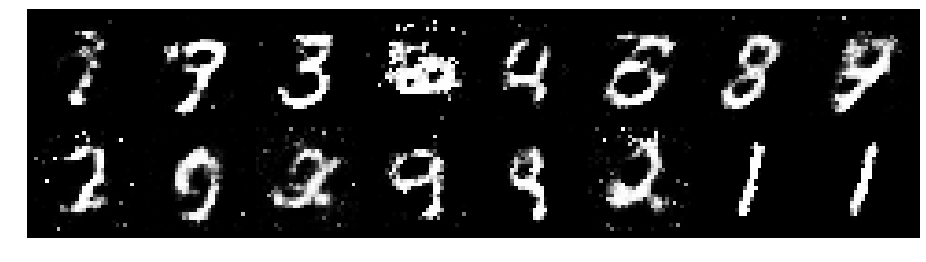

Epoch: [39/200], Batch Num: [200/600]
Discriminator Loss: 1.1382, Generator Loss: 1.3376
D(x): 0.6176, D(G(z)): 0.3921


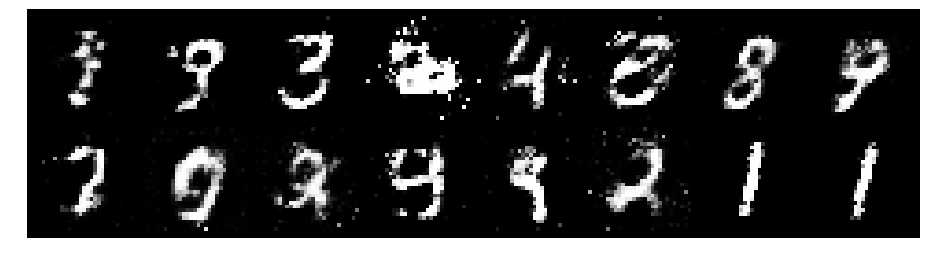

Epoch: [39/200], Batch Num: [300/600]
Discriminator Loss: 1.1042, Generator Loss: 1.1453
D(x): 0.6046, D(G(z)): 0.3598


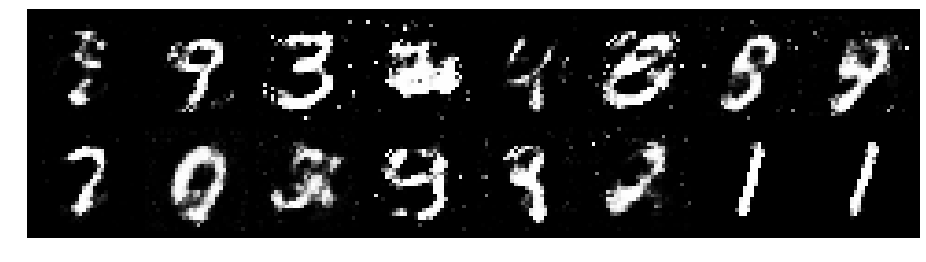

Epoch: [39/200], Batch Num: [400/600]
Discriminator Loss: 0.9559, Generator Loss: 1.4845
D(x): 0.6823, D(G(z)): 0.3371


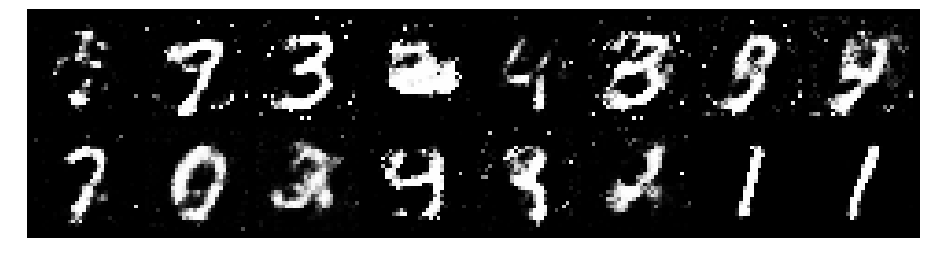

Epoch: [39/200], Batch Num: [500/600]
Discriminator Loss: 0.9373, Generator Loss: 1.3166
D(x): 0.6552, D(G(z)): 0.2800


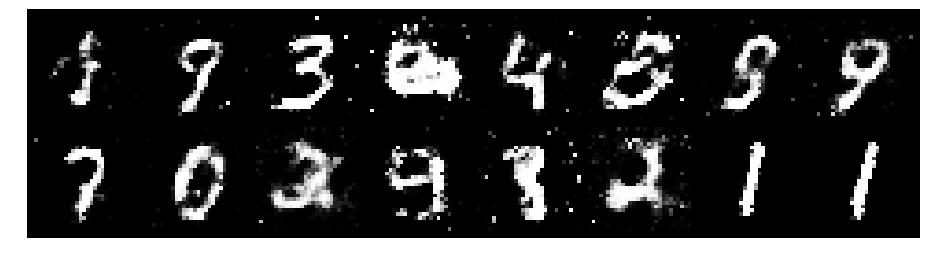

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 1.0683, Generator Loss: 1.1768
D(x): 0.6786, D(G(z)): 0.4068


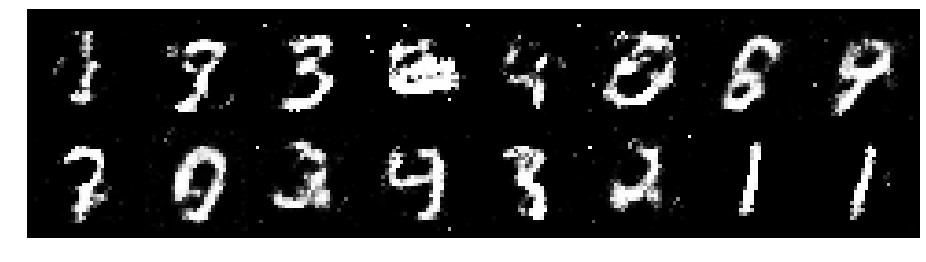

Epoch: [40/200], Batch Num: [100/600]
Discriminator Loss: 0.9929, Generator Loss: 1.2137
D(x): 0.6619, D(G(z)): 0.3529


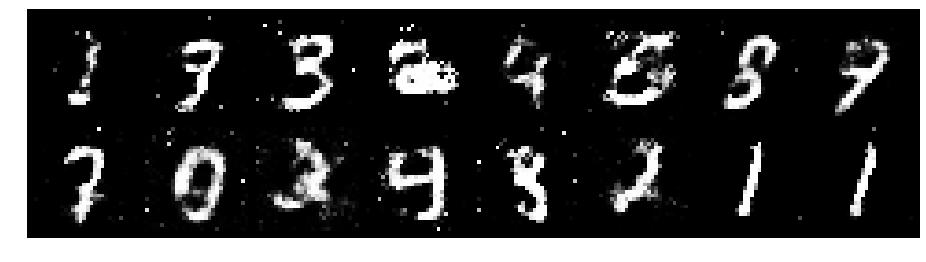

Epoch: [40/200], Batch Num: [200/600]
Discriminator Loss: 1.1737, Generator Loss: 1.2786
D(x): 0.6591, D(G(z)): 0.3800


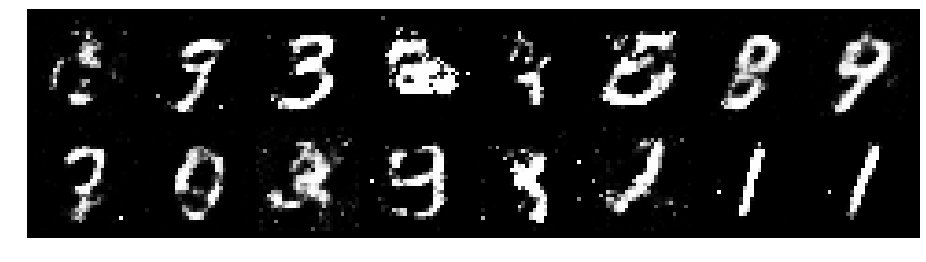

Epoch: [40/200], Batch Num: [300/600]
Discriminator Loss: 1.1155, Generator Loss: 1.2834
D(x): 0.6288, D(G(z)): 0.3673


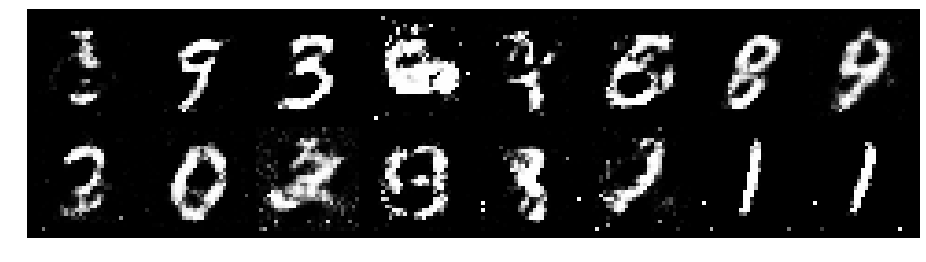

Epoch: [40/200], Batch Num: [400/600]
Discriminator Loss: 0.9842, Generator Loss: 1.4947
D(x): 0.6184, D(G(z)): 0.2819


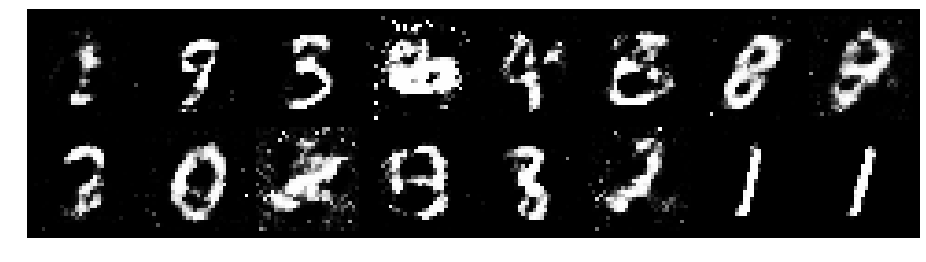

Epoch: [40/200], Batch Num: [500/600]
Discriminator Loss: 1.1232, Generator Loss: 1.3112
D(x): 0.5678, D(G(z)): 0.3017


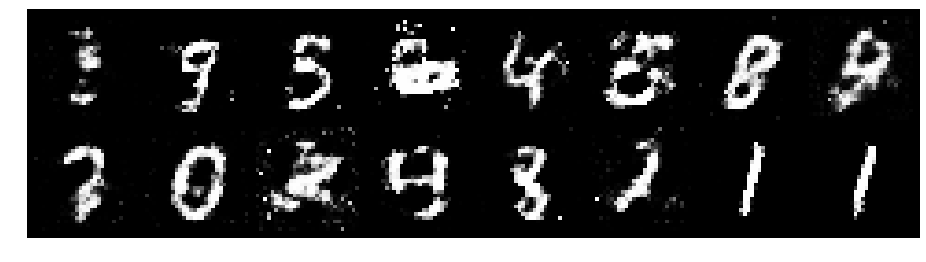

Epoch: [41/200], Batch Num: [0/600]
Discriminator Loss: 0.9369, Generator Loss: 1.3767
D(x): 0.7110, D(G(z)): 0.3584


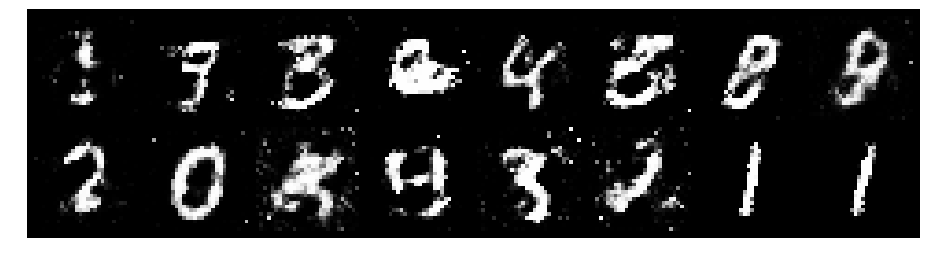

Epoch: [41/200], Batch Num: [100/600]
Discriminator Loss: 0.9051, Generator Loss: 1.6104
D(x): 0.7341, D(G(z)): 0.3325


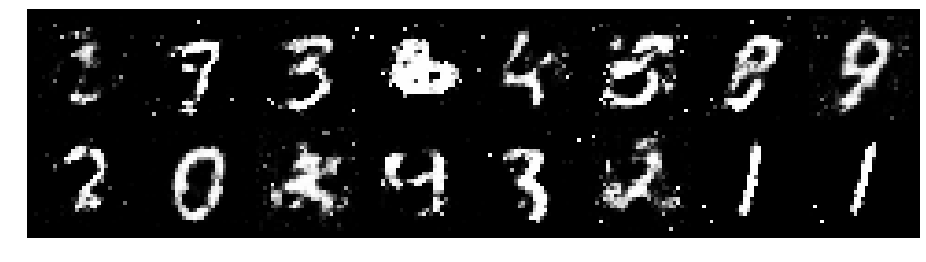

Epoch: [41/200], Batch Num: [200/600]
Discriminator Loss: 1.0101, Generator Loss: 1.2103
D(x): 0.6574, D(G(z)): 0.3864


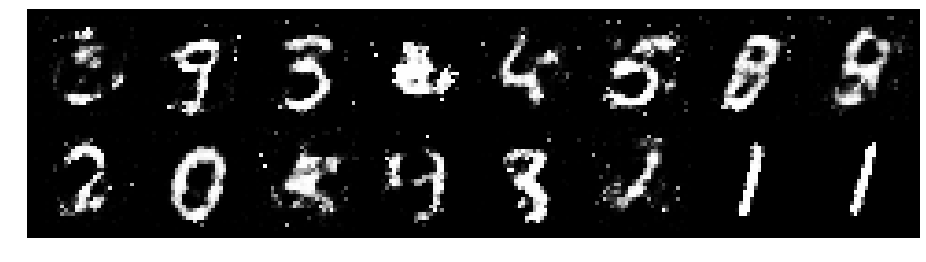

Epoch: [41/200], Batch Num: [300/600]
Discriminator Loss: 1.0610, Generator Loss: 1.4134
D(x): 0.6750, D(G(z)): 0.4054


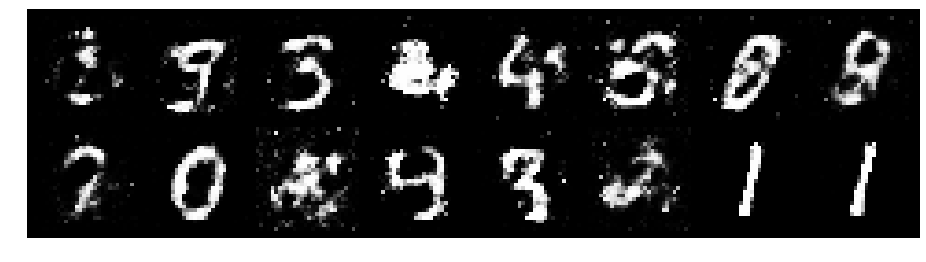

Epoch: [41/200], Batch Num: [400/600]
Discriminator Loss: 0.9001, Generator Loss: 1.1996
D(x): 0.6971, D(G(z)): 0.3270


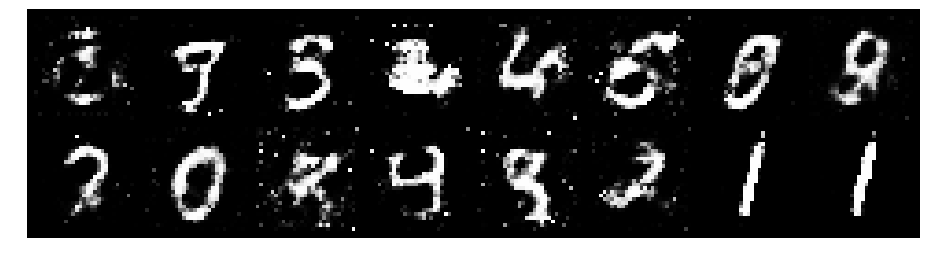

Epoch: [41/200], Batch Num: [500/600]
Discriminator Loss: 1.0276, Generator Loss: 1.5723
D(x): 0.6515, D(G(z)): 0.3398


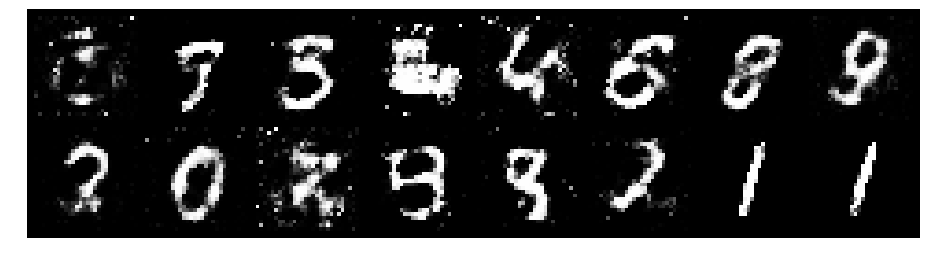

Epoch: [42/200], Batch Num: [0/600]
Discriminator Loss: 1.3903, Generator Loss: 0.9427
D(x): 0.6399, D(G(z)): 0.5165


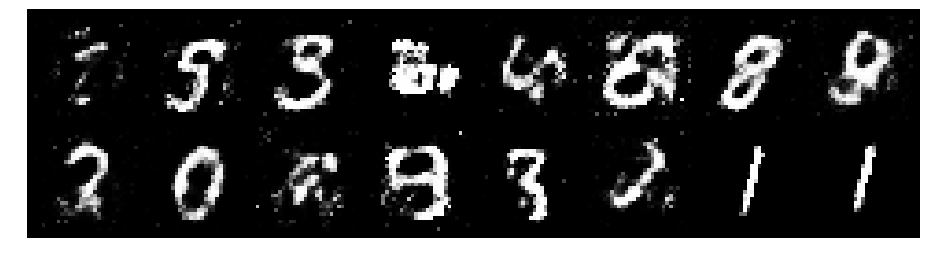

Epoch: [42/200], Batch Num: [100/600]
Discriminator Loss: 1.1236, Generator Loss: 1.0621
D(x): 0.6964, D(G(z)): 0.4527


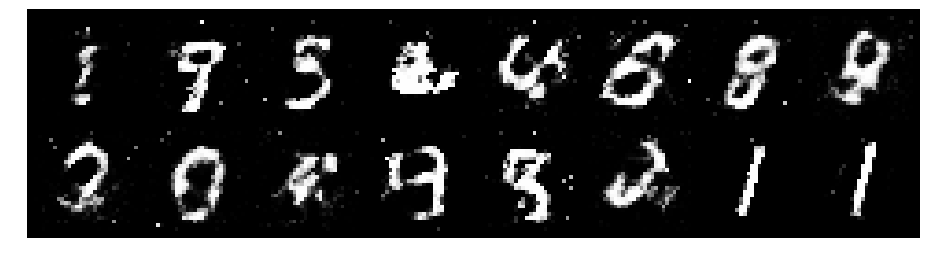

Epoch: [42/200], Batch Num: [200/600]
Discriminator Loss: 1.0957, Generator Loss: 1.0590
D(x): 0.6298, D(G(z)): 0.4021


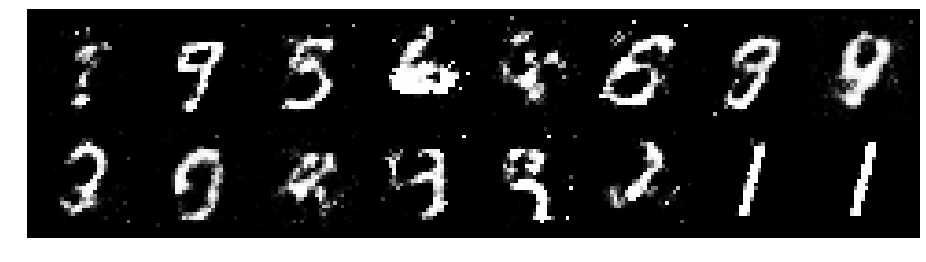

Epoch: [42/200], Batch Num: [300/600]
Discriminator Loss: 1.1785, Generator Loss: 1.1546
D(x): 0.5650, D(G(z)): 0.3692


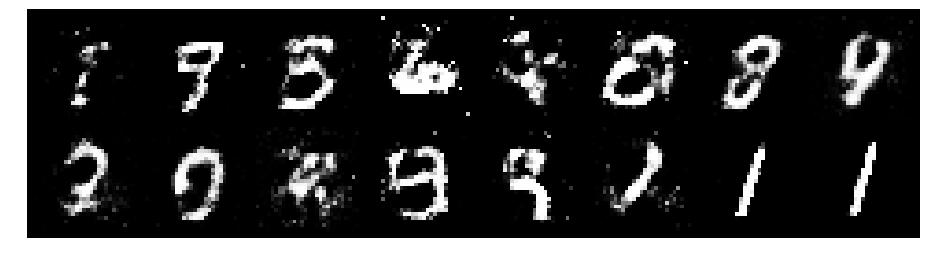

Epoch: [42/200], Batch Num: [400/600]
Discriminator Loss: 1.0594, Generator Loss: 0.8862
D(x): 0.6432, D(G(z)): 0.3842


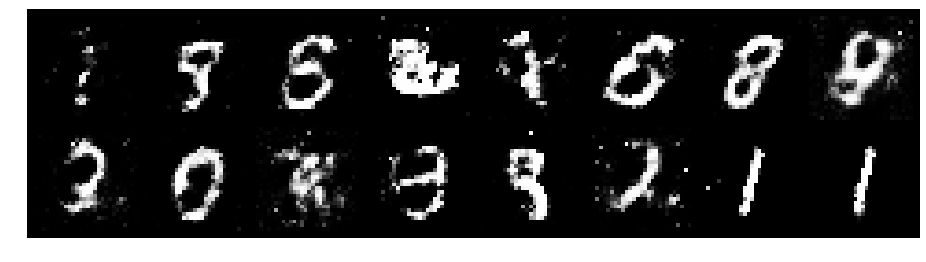

Epoch: [42/200], Batch Num: [500/600]
Discriminator Loss: 1.1234, Generator Loss: 1.0045
D(x): 0.6201, D(G(z)): 0.4078


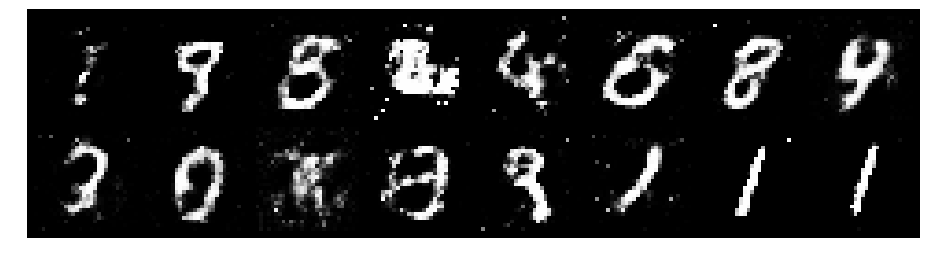

Epoch: [43/200], Batch Num: [0/600]
Discriminator Loss: 1.1924, Generator Loss: 0.9589
D(x): 0.6034, D(G(z)): 0.4200


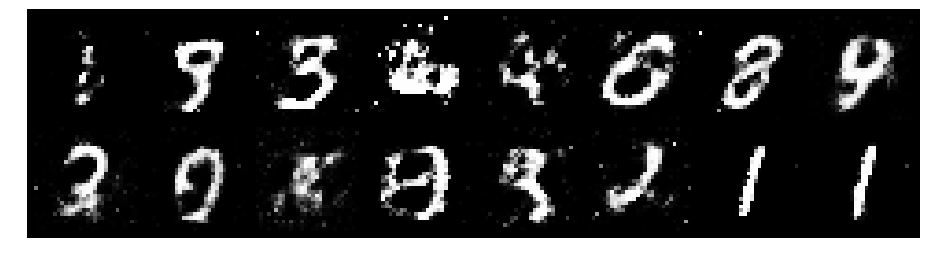

Epoch: [43/200], Batch Num: [100/600]
Discriminator Loss: 1.2679, Generator Loss: 1.3197
D(x): 0.5324, D(G(z)): 0.3639


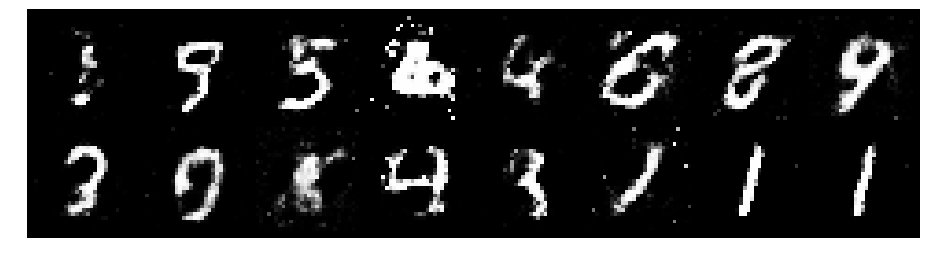

Epoch: [43/200], Batch Num: [200/600]
Discriminator Loss: 1.2114, Generator Loss: 0.9586
D(x): 0.6450, D(G(z)): 0.4525


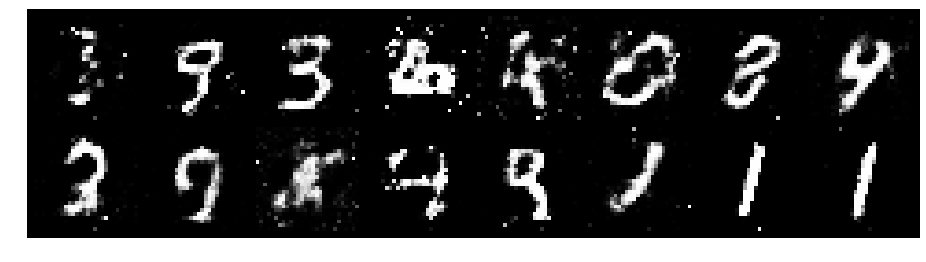

Epoch: [43/200], Batch Num: [300/600]
Discriminator Loss: 1.3003, Generator Loss: 1.1415
D(x): 0.5822, D(G(z)): 0.4082


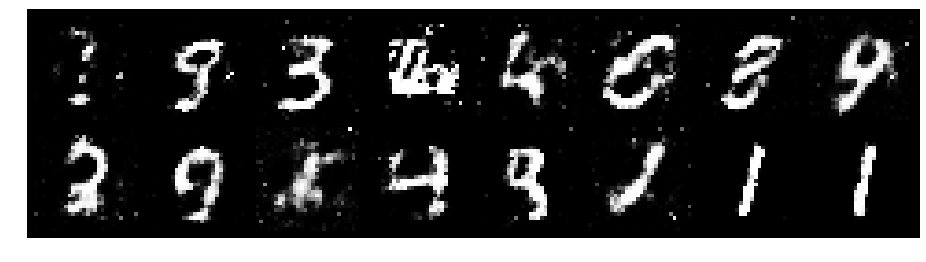

Epoch: [43/200], Batch Num: [400/600]
Discriminator Loss: 0.9256, Generator Loss: 1.2730
D(x): 0.6887, D(G(z)): 0.3472


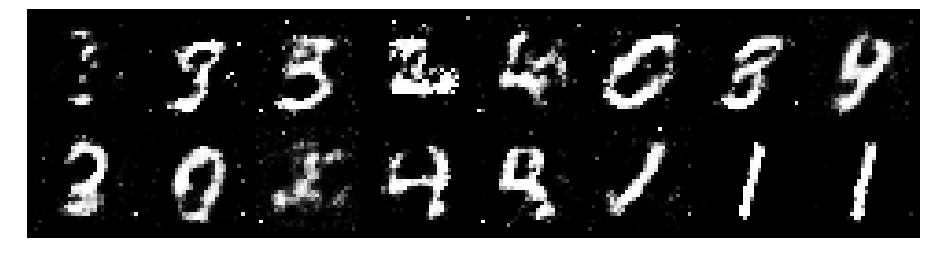

Epoch: [43/200], Batch Num: [500/600]
Discriminator Loss: 1.2526, Generator Loss: 1.1914
D(x): 0.5803, D(G(z)): 0.3881


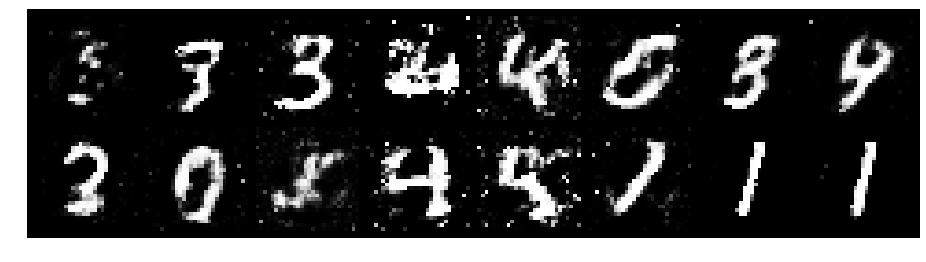

Epoch: [44/200], Batch Num: [0/600]
Discriminator Loss: 1.0549, Generator Loss: 1.1550
D(x): 0.6849, D(G(z)): 0.3991


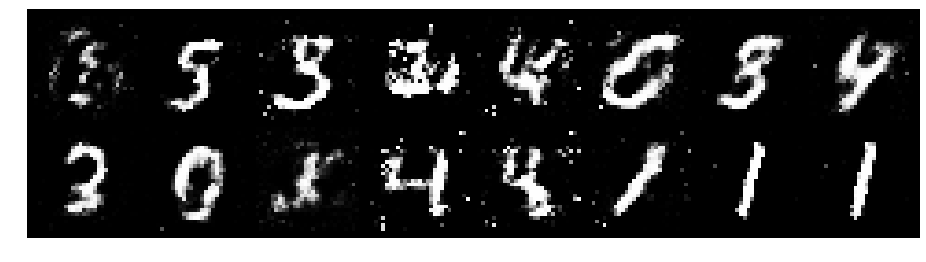

Epoch: [44/200], Batch Num: [100/600]
Discriminator Loss: 1.1685, Generator Loss: 1.2817
D(x): 0.5772, D(G(z)): 0.3350


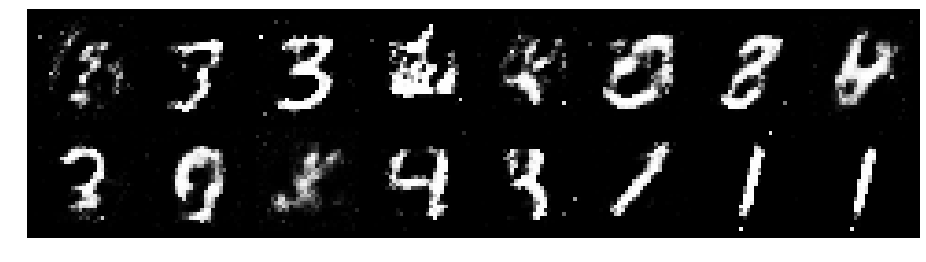

Epoch: [44/200], Batch Num: [200/600]
Discriminator Loss: 0.9713, Generator Loss: 1.2427
D(x): 0.7018, D(G(z)): 0.3671


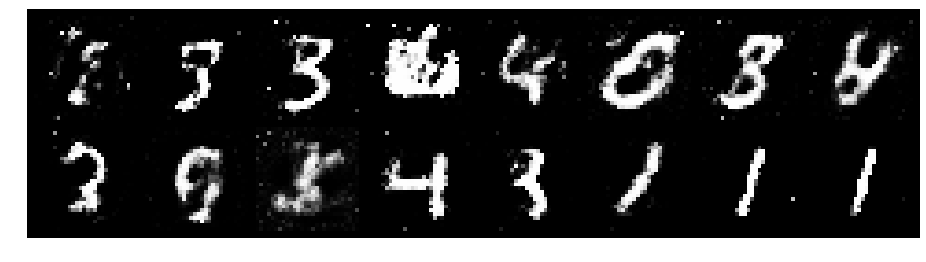

Epoch: [44/200], Batch Num: [300/600]
Discriminator Loss: 1.1388, Generator Loss: 1.1683
D(x): 0.6302, D(G(z)): 0.4030


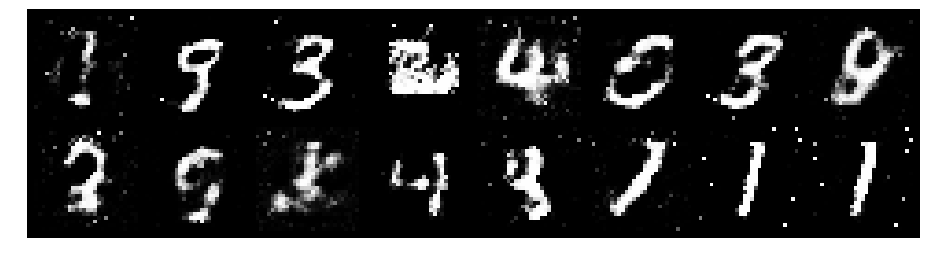

Epoch: [44/200], Batch Num: [400/600]
Discriminator Loss: 1.0595, Generator Loss: 1.2574
D(x): 0.6448, D(G(z)): 0.3736


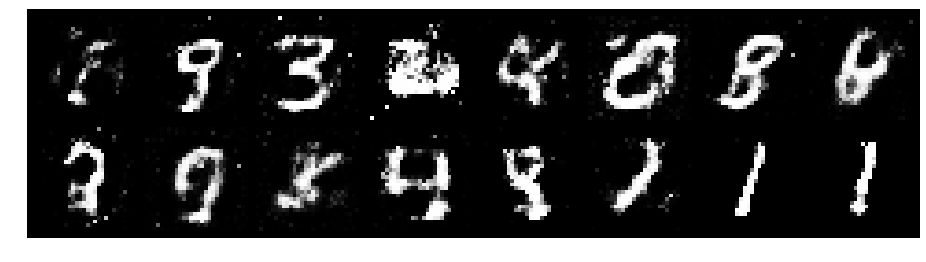

Epoch: [44/200], Batch Num: [500/600]
Discriminator Loss: 1.2566, Generator Loss: 1.2085
D(x): 0.6077, D(G(z)): 0.4143


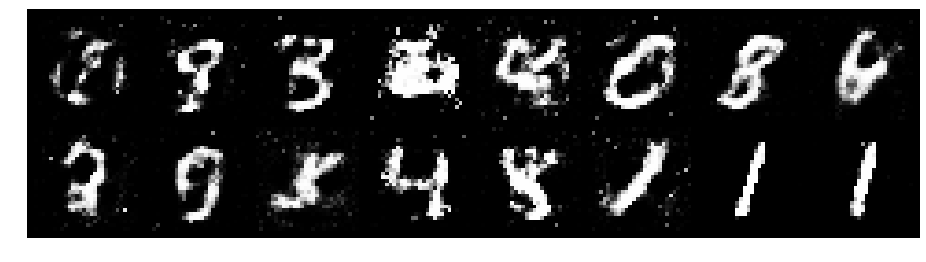

Epoch: [45/200], Batch Num: [0/600]
Discriminator Loss: 1.1460, Generator Loss: 1.4642
D(x): 0.6064, D(G(z)): 0.3447


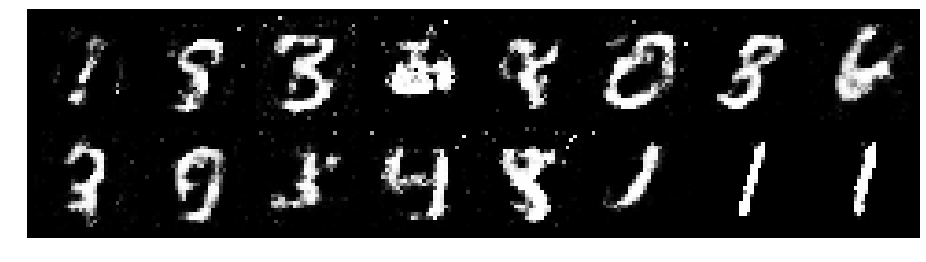

Epoch: [45/200], Batch Num: [100/600]
Discriminator Loss: 1.1755, Generator Loss: 1.5490
D(x): 0.6671, D(G(z)): 0.4247


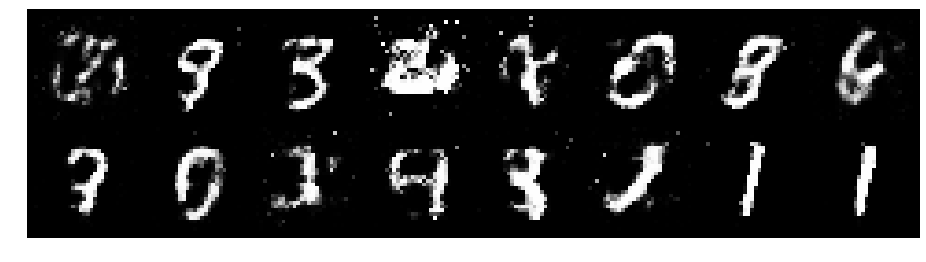

Epoch: [45/200], Batch Num: [200/600]
Discriminator Loss: 0.8560, Generator Loss: 1.4323
D(x): 0.7015, D(G(z)): 0.2868


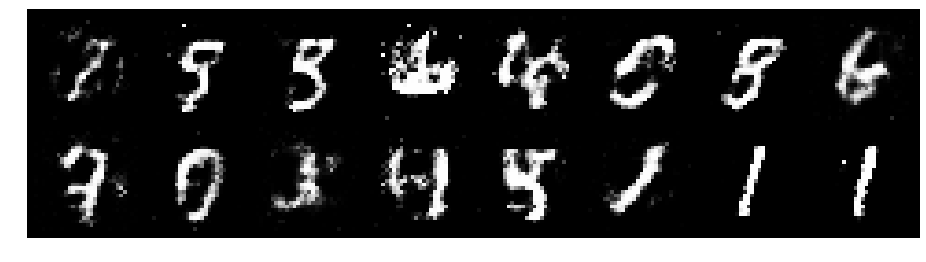

Epoch: [45/200], Batch Num: [300/600]
Discriminator Loss: 1.0895, Generator Loss: 1.2066
D(x): 0.6225, D(G(z)): 0.3715


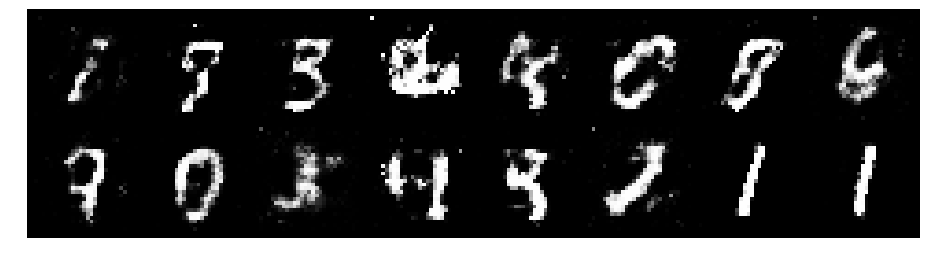

Epoch: [45/200], Batch Num: [400/600]
Discriminator Loss: 1.0289, Generator Loss: 1.1104
D(x): 0.6355, D(G(z)): 0.3754


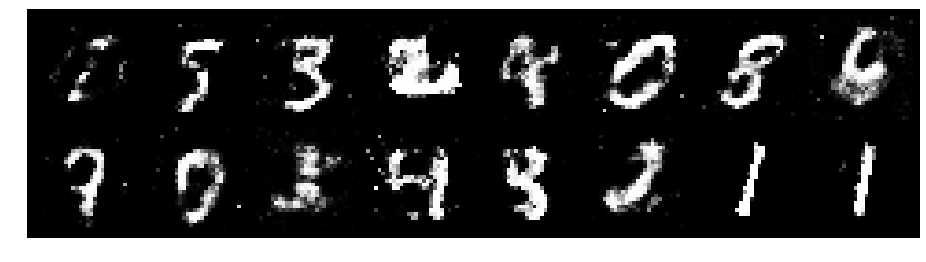

Epoch: [45/200], Batch Num: [500/600]
Discriminator Loss: 1.0640, Generator Loss: 1.1400
D(x): 0.6139, D(G(z)): 0.3652


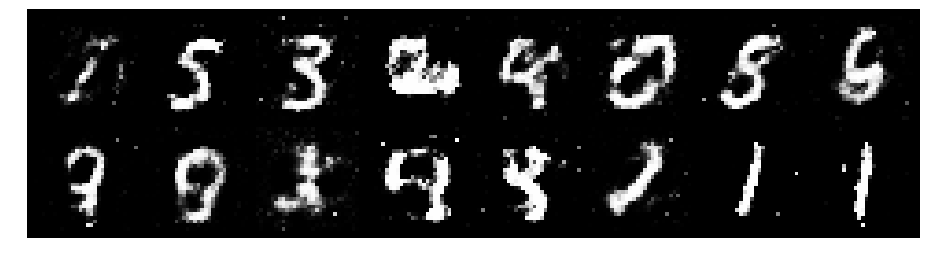

Epoch: [46/200], Batch Num: [0/600]
Discriminator Loss: 1.0609, Generator Loss: 1.0636
D(x): 0.6439, D(G(z)): 0.3907


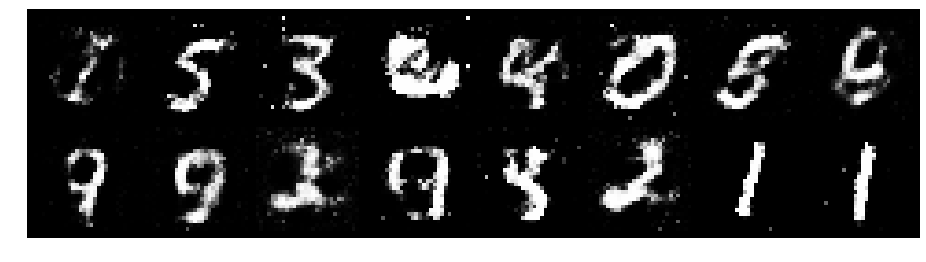

Epoch: [46/200], Batch Num: [100/600]
Discriminator Loss: 1.1586, Generator Loss: 0.9799
D(x): 0.5991, D(G(z)): 0.3872


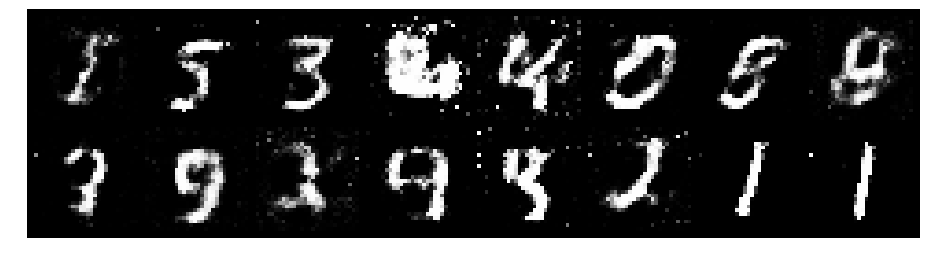

Epoch: [46/200], Batch Num: [200/600]
Discriminator Loss: 1.2109, Generator Loss: 0.8692
D(x): 0.6219, D(G(z)): 0.4690


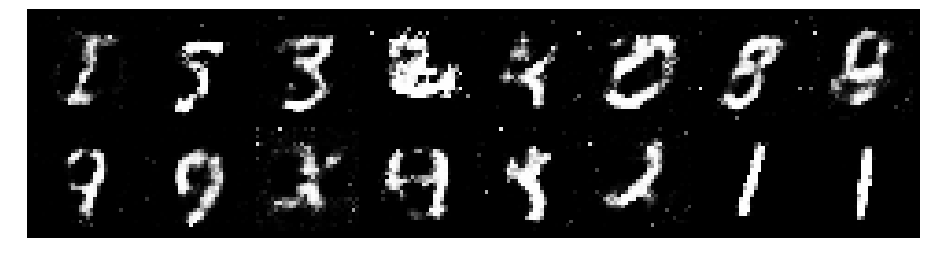

Epoch: [46/200], Batch Num: [300/600]
Discriminator Loss: 1.1586, Generator Loss: 0.9376
D(x): 0.5803, D(G(z)): 0.3866


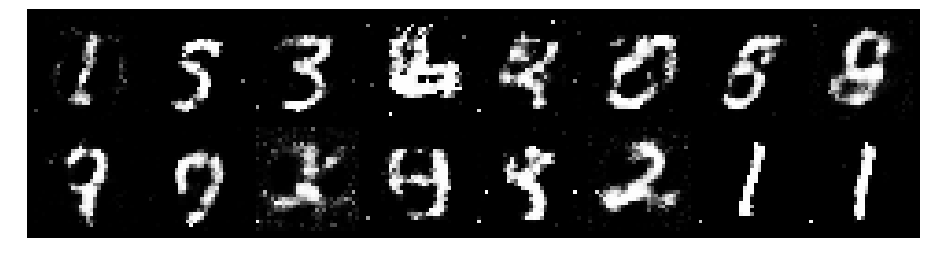

Epoch: [46/200], Batch Num: [400/600]
Discriminator Loss: 1.2601, Generator Loss: 1.1755
D(x): 0.5577, D(G(z)): 0.3638


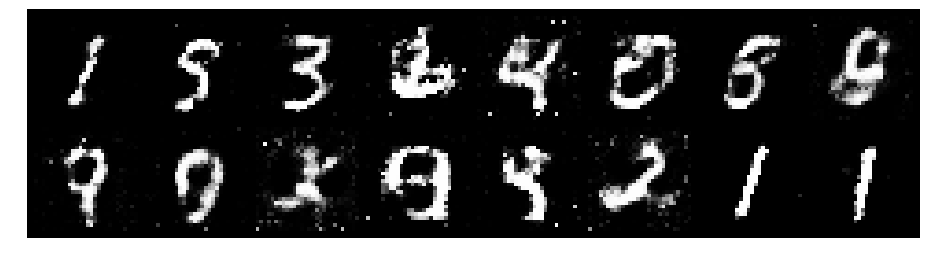

Epoch: [46/200], Batch Num: [500/600]
Discriminator Loss: 1.1660, Generator Loss: 1.2097
D(x): 0.6073, D(G(z)): 0.3247


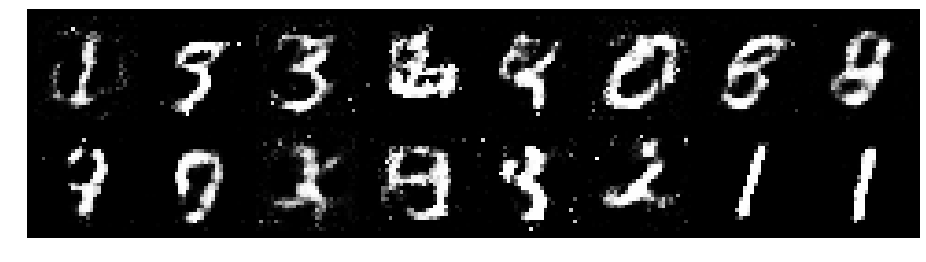

Epoch: [47/200], Batch Num: [0/600]
Discriminator Loss: 1.1073, Generator Loss: 1.1889
D(x): 0.6020, D(G(z)): 0.3651


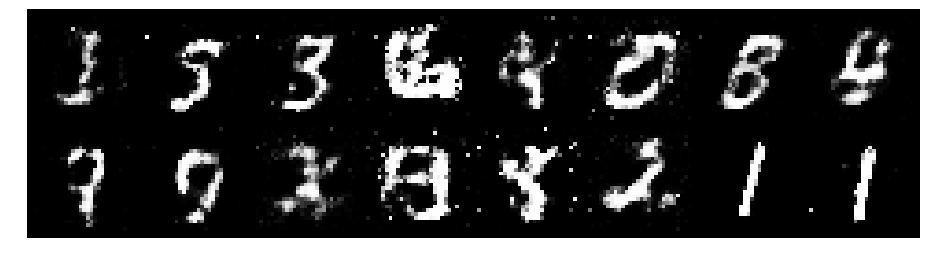

Epoch: [47/200], Batch Num: [100/600]
Discriminator Loss: 1.1080, Generator Loss: 1.1092
D(x): 0.5758, D(G(z)): 0.3455


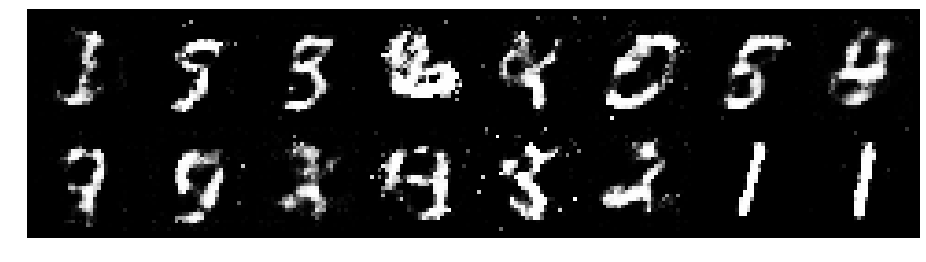

Epoch: [47/200], Batch Num: [200/600]
Discriminator Loss: 1.2114, Generator Loss: 1.2523
D(x): 0.6183, D(G(z)): 0.4044


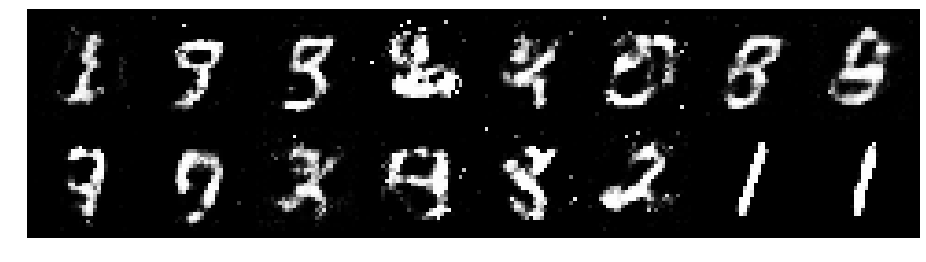

Epoch: [47/200], Batch Num: [300/600]
Discriminator Loss: 1.1572, Generator Loss: 1.1872
D(x): 0.6243, D(G(z)): 0.4101


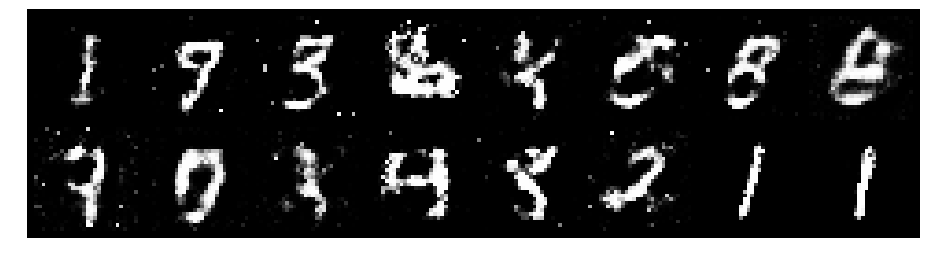

Epoch: [47/200], Batch Num: [400/600]
Discriminator Loss: 1.0940, Generator Loss: 1.2282
D(x): 0.5995, D(G(z)): 0.3616


In [0]:
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )